<a href="https://colab.research.google.com/github/marcospgp/abstraction-and-reasoning/blob/master/Neural_Cellular_Automata_for_ARC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualizing the problem

In [ ]:
!pip install --upgrade keras

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.4.3)


In [ ]:
!git clone https://github.com/fchollet/ARC.git

Cloning into 'ARC'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 1156 (delta 5), reused 10 (delta 2), pack-reused 1136
Receiving objects: 100% (1156/1156), 493.24 KiB | 4.79 MiB/s, done.
Resolving deltas: 100% (667/667), done.


In [ ]:
import os
import json

# task_file = "./ARC/data/training/00d62c1b.json"

task_files = sorted(os.listdir("./ARC/data/training"))

print("Filenames of first 3 training tasks:")
print(task_files[:3])

tasks = []

for filename in task_files:
    with open(f"./ARC/data/training/{filename}", "r") as f:
        tasks.append(json.load(f))

print("\nFirst task's keys:")
display(tasks[0].keys())

Filenames of first 3 training tasks:
['007bbfb7.json', '00d62c1b.json', '017c7c7b.json']

First task's keys:


dict_keys(['test', 'train'])

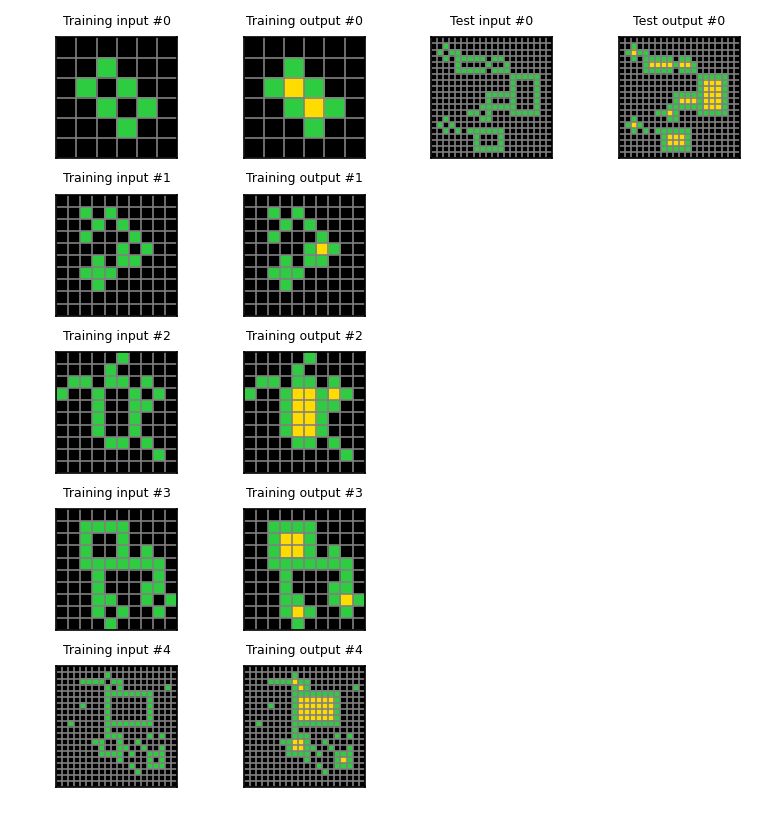

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import colors

cmap = colors.ListedColormap(['#000000', '#0074D9','#FF4136','#2ECC40',
        '#FFDC00', '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)

# Draws a grid using pyplot.
# The grid wil be drawn wherever pyplot is currently pointed - so to draw inside
# a particular subplot, for example, simply call plt.subplot() before calling
# this function.
def plot_one_grid(grid):
    plt.imshow(grid, cmap=cmap, norm=norm, extent=(0, len(grid[0]), 0, len(grid)))
    plt.grid(True, color="gray")
    plt.tick_params(colors=(0, 0, 0, 0))
    plt.xticks(range(len(grid[0])))
    plt.yticks(range(len(grid)))

def display_grid(grid):
    """ Display a single grid """
    plt.figure()
    plot_one_grid(grid)
    plt.show()

def display_grid_pairs(xs, ys):
    rows = len(xs)
    cols = 2
    pos = 1
    plt.figure()
    for i, grid in enumerate(xs):
        plt.subplot(rows, cols, pos)
        plot_one_grid(grid)
        pos += 1
        plt.subplot(rows, cols, pos)
        plot_one_grid(ys[i])
        pos += 1
    plt.show()

def display_task(task, show_labels=True, size=(5, 5)):
    """
    Display a task's example and test grids
    """
    number_of_examples = len(task["train"])
    number_of_test_grids = len(task["test"])
    rows = max(number_of_examples, number_of_test_grids)

    # Adjust figsize and dpi to avoid misaligned grid lines
    # (https://stackoverflow.com/questions/53998166/python-matplotlib-misaligned-grid-lines-and-color-fills)
    plt.figure(figsize=size, dpi=150)
    
    # Reduce margins
    if show_labels:
        plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0.3)
    else:
        plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0.2)

    def draw_subplot(title, rows, cols, y, x, grid):
        i = cols * y + x + 1
        plt.subplot(rows, cols, i)
        if (show_labels):
            plt.title(title, fontsize=6)
        plot_one_grid(grid)

    for i in range(number_of_examples):
        input = task["train"][i]["input"]
        output = task["train"][i]["output"]
        draw_subplot(f"Training input #{i}", rows, 4, i, 0, input)
        draw_subplot(f"Training output #{i}", rows, 4, i, 1, output)

    for i in range(number_of_test_grids):
        input = task["test"][i]["input"]
        output = task["test"][i]["output"]
        draw_subplot(f"Test input #{i}", rows, 4, i, 2, input)
        draw_subplot(f"Test output #{i}", rows, 4, i, 3, output)

    plt.show()

display_task(tasks[1])

# Vectorizing tasks

In [ ]:
# Defining constants

# The number of channels appended to each square of the grid for the network
# to use arbitrarily as a means of communication between neighboring squares.
# These channels do not apply to the loss.
NUM_COMMUNICATION_CHANNELS = 4

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

def vectorize_grid(grid):
    g = grid

    # Fix for when grid has width 1
    if len(grid[0]) == 1:
        g = []
        for line in grid:
            g.append([line])
    
    # Begin by one hot encoding grid
    g = keras.utils.to_categorical(g, num_classes=10)
    # Now add zeros to each square's vector corresponding to the number of
    # arbitrary communication channels
    new_grid = []
    height = len(g)
    width = len(g[0])
    for i in range(height):
        new_grid.append([])
        for j in range(width):
            zeros = np.zeros(NUM_COMMUNICATION_CHANNELS)
            new_grid[len(new_grid) - 1].append(np.concatenate((g[i][j], zeros)))
    return np.array(new_grid, dtype="float32")

def devectorize_grid(grid):
    new_grid = []
    for line in grid:
        new_grid.append([])
        for square in line:
            new_grid[len(new_grid) - 1].append(np.argmax(square[:10]))
    return np.array(new_grid)

def vectorize_task(task):
    result = {
        "train_x": [],
        "train_y": [],
        "test_x": [],
        "test_y": []
    }
    for x in task["train"]:

        result["train_x"].append(vectorize_grid(x["input"]))
        result["train_y"].append(vectorize_grid(x["output"]))

    for x in task["test"]:
        result["test_x"].append(vectorize_grid(x["input"]))
        result["test_y"].append(vectorize_grid(x["output"]))
    
    return result

def devectorize_task(task):
    result = { "train": [], "test": [] }

    for i, grid in enumerate(task["train_x"]):
        x = devectorize_grid(grid)
        y = devectorize_grid(task["train_y"][i])
        result["train"].append({ "input": x, "output": y })

    for i, grid in enumerate(task["test_x"]):
        x = devectorize_grid(grid)
        y = devectorize_grid(task["test_y"][i])
        result["test"].append({ "input": x, "output": y })
    
    return result

# Returns true if all the input/output pairs of a vectorized task have the same
# grid dimensions 
def has_constant_grid_sizes(vectorized_task):
    v = vectorized_task
    def check(x, y):
        x_height = len(x)
        x_width = len(x[0])
        y_height = len(y)
        y_width = len(y[0])

        if (x_height != y_height or x_width != y_width):
            return False
        else:
            return True

    for i, x in enumerate(v["train_x"]):
        y = v["train_y"][i]
        if not check(x, y): return False
    
    for i, x in enumerate(v["test_x"]):
        y = v["test_y"][i]
        if not check(x, y): return False
    
    return True

# Vectorize grids of tasks where input/output pairs have same dimensions
# (our model is not prepared to handle varying grid sizes)
vectorized_tasks = []
task_names = []
for i, task in enumerate(tasks):
    x = vectorize_task(task)
    if has_constant_grid_sizes(x):
        vectorized_tasks.append(x)
        task_names.append(task_files[i])
        
print(f"Vectorized {len(vectorized_tasks)} tasks with constant input/output dimensions, out of a total of {len(tasks)}.")

Vectorized 262 tasks with constant input/output dimensions, out of a total of 400.


# Running our model

Model: "Cellular Automata for ARC"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 1 16256       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 1 1806        conv2d[0][0]                     
__________________________________________________________________________________________________
add (Add)                       (None, None, None, 1 0           conv2d_1[0][0]                   
                                                                 input_1[0

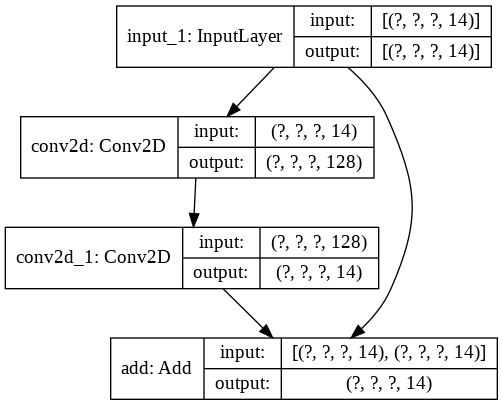

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def createAutomataModel(initializer, name="Cellular Automata for ARC"):
    # Free up RAM when creating a model multiple times
    keras.backend.clear_session()

    input = keras.Input(shape=(None, None, 10 + NUM_COMMUNICATION_CHANNELS))

    x = layers.Conv2D(
        filters=128,
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_initializer=initializer,
        bias_initializer=initializer
    )(input)

    x = layers.Conv2D(
        filters=10 + NUM_COMMUNICATION_CHANNELS,
        kernel_size=1,
        padding="valid",
        activation=None,
        kernel_initializer=initializer,
        bias_initializer=initializer
    )(x)

    x = layers.Add()([x, input])

    return keras.Model(inputs=input, outputs=x, name=name)

# Create a model just to display a summary (it won't be used)
initializer = keras.initializers.RandomNormal(mean=0.0, stddev=3e-3, seed=1337)
model = createAutomataModel(initializer)
model.summary()
display(keras.utils.plot_model(model, show_shapes=True))


In [ ]:
# Custom loss function that ignores arbitrary communication channels
def custom_loss(y_true, y_pred):
    (a, b, c) = y_true[0].shape
    new_y_true = tf.slice(y_true[0], [0, 0, 0], [a, b, 10])
    new_y_pred = tf.slice(y_pred[0], [0, 0, 0], [a, b, 10])
    # Mean squared error
    # return keras.losses.MeanSquaredError()(new_y_true, new_y_pred)
    # Cross entropy
    # return tf.math.reduce_sum(
    #     tf.nn.softmax_cross_entropy_with_logits(labels=new_y_true, logits=new_y_pred))
    # Non-mean squared error
    return tf.math.reduce_sum(
        tf.math.squared_difference(new_y_true, new_y_pred))
    
def train_one_step(model, train_x, train_y, num_iterations, optimizer):
    # The model will be fed its previous predictions on each iteration,
    # so we define the first y_pred as the original inputs
    # (y_pred is a list and not a numpy array because grid sizes may differ)
    y_pred = list(map(lambda x: np.copy(x), train_x))

    # Accumulate gradient over all iterations so it can be applied in the end
    # (backpropagation through time)
    accumulated_gradient = []

    for layer in model.trainable_variables:
        accumulated_gradient.append(tf.zeros(layer.shape))

    # print("Training losses:")

    for iteration in range(num_iterations):
        avg_gradient = [] # Total gradient over all training examples

        for layer in model.trainable_variables:
            avg_gradient.append(tf.zeros(layer.shape))

        # Feed forward all example grids
        for i, grid in enumerate(y_pred):
            # Turn input and target grids into batch of 1
            input = np.array([grid])
            y = np.array([train_y[i]])

            with tf.GradientTape() as tape:
                out = model(input, training=True)
                loss = custom_loss(y, out)
                # if iteration == (num_iterations - 1):
                #     print(f"#{i}: {loss}")

            gradient = tape.gradient(loss, model.trainable_variables)
            # Replace next input with this step's output
            # (index 0 to extract from batch of size 1)
            y_pred[i] = np.array(out[0])

            for i, layer in enumerate(gradient):
                avg_gradient[i] += layer

        # Accumulate gradient
        for i, layer in enumerate(avg_gradient):
            avg_gradient[i] /= len(y_pred)
            accumulated_gradient[i] += avg_gradient[i]

    # Update weights
    optimizer.apply_gradients(zip(accumulated_gradient, model.trainable_variables))

def train(model, task, num_iterations, optimizer, max_epochs, display_result=False):
    """
    @param model: The model to be trained
    @param task: A vectorized task in the format
        { train_x: [], train_y: [], test_x: [], test_y: []}, where the lists
        are 3-dimensional.
    @param num_iterations: How many times to iterate the grid through the model
        before updating the weights.
    @param optimizer: The optimizer to use when updating the weights.
    @param max_epochs: The maximum number of times the model will be updated
        after running the input grid through it `num_iterations` times.
        This is a maximum because the model will stop training as soon as it
        has solved the test grids correctly.
    @return True as soon as the model solves the test grids correctly, otherwise
        returns False after training for `max_epochs` epochs.
    """
    print(f"Training model {model.name} for a max of {max_epochs} epochs, with {num_iterations} iterations per epoch...")
    
    for i in range(max_epochs):
        # Train model once
        train_one_step(model, task["train_x"], task["train_y"], num_iterations, optimizer)
        # Check if test grids are completed successfully
        success = evaluate(model, task["test_x"], task["test_y"], num_iterations, display_result=display_result)
        # Stop training if model is successful
        if success: return True
    
    return False

def evaluate(model, test_x, test_y, num_iterations, display_result=False):
    """
    @return True if the model completes the test grids correctly, False otherwise
    """

    # Local copy of input so we can iterate over it
    y_pred = np.copy(test_x)

    for iteration in range(num_iterations):
        for i, grid in enumerate(y_pred):
            out = model(np.array([grid]), training=False) # Batch size of 1
            y_pred[i] = out[0] # Extract result from batch

    if display_result:
        print("\nEvaluation result:")
        xs = []
        ys = []
        for i, grid in enumerate(y_pred):
            xs.append(devectorize_grid(test_x[i]))
            ys.append(devectorize_grid(test_y[i]))
            xs.append(devectorize_grid(test_x[i]))
            ys.append(devectorize_grid(grid))
        display_grid_pairs(xs, ys)
    
    # Calculate avg test loss
    loss = 0
    for i, grid in enumerate(y_pred):
        prediction = np.array([grid])
        y = np.array([test_y[i]])
        loss += custom_loss(y, prediction)
    loss /= len(y_pred)
    if (display_result):
        print(f"Average test loss: {loss}")

    # Check if test output grid predictions are correct
    for i, grid in enumerate(y_pred):
        prediction = devectorize_grid(grid)
        y = devectorize_grid(test_y[i])
        if not np.array_equal(y, prediction):
            return False

    return True

Training model 00d62c1b.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


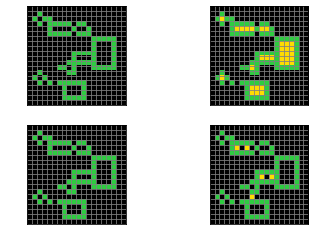

Average test loss: 79.12056732177734
Failed to solve task 00d62c1b.json.
Attempted 1 out of 262 tasks.

Solved 0 tasks so far:
[]
Training model 025d127b.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


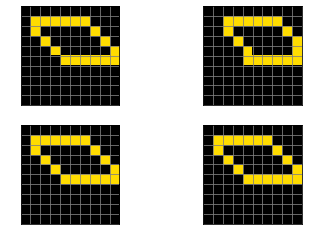

Average test loss: 49.988319396972656
Failed to solve task 025d127b.json.
Attempted 2 out of 262 tasks.

Solved 0 tasks so far:
[]
Training model 045e512c.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


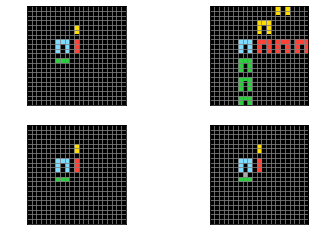

Average test loss: 123.68604278564453
Failed to solve task 045e512c.json.
Attempted 3 out of 262 tasks.

Solved 0 tasks so far:
[]
Training model 05269061.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


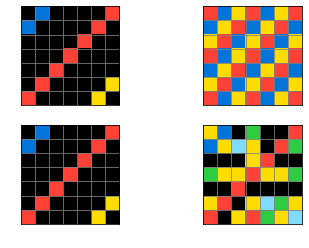

Average test loss: 63.82015609741211
Failed to solve task 05269061.json.
Attempted 4 out of 262 tasks.

Solved 0 tasks so far:
[]
Training model 05f2a901.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


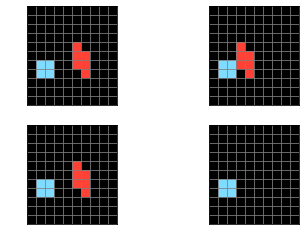

Average test loss: 21.86536979675293
Failed to solve task 05f2a901.json.
Attempted 5 out of 262 tasks.

Solved 0 tasks so far:
[]
Training model 06df4c85.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


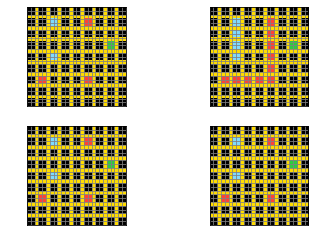

Average test loss: 137.3004608154297
Failed to solve task 06df4c85.json.
Attempted 6 out of 262 tasks.

Solved 0 tasks so far:
[]
Training model 08ed6ac7.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


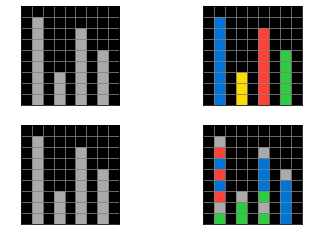

Average test loss: 28.000789642333984
Failed to solve task 08ed6ac7.json.
Attempted 7 out of 262 tasks.

Solved 0 tasks so far:
[]
Training model 09629e4f.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


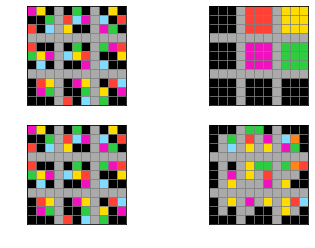

Average test loss: 83.30469512939453
Failed to solve task 09629e4f.json.
Attempted 8 out of 262 tasks.

Solved 0 tasks so far:
[]
Training model 0962bcdd.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


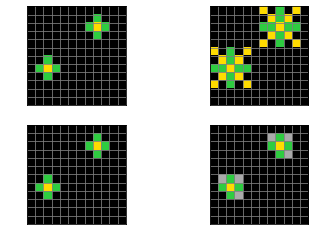

Average test loss: 81.4635009765625
Failed to solve task 0962bcdd.json.
Attempted 9 out of 262 tasks.

Solved 0 tasks so far:
[]
Training model 0a938d79.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


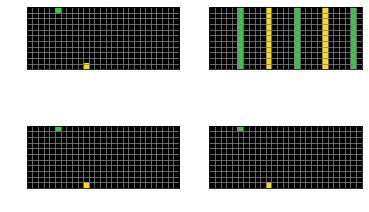

Average test loss: 112.27854919433594
Failed to solve task 0a938d79.json.
Attempted 10 out of 262 tasks.

Solved 0 tasks so far:
[]
Training model 0ca9ddb6.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


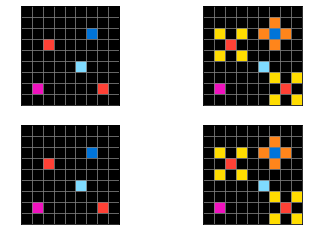

Average test loss: 15.633684158325195
Solved task 0ca9ddb6.json successfully!
Attempted 11 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 0d3d703e.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


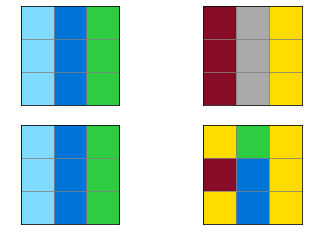

Average test loss: 18.359437942504883
Failed to solve task 0d3d703e.json.
Attempted 12 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 0dfd9992.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


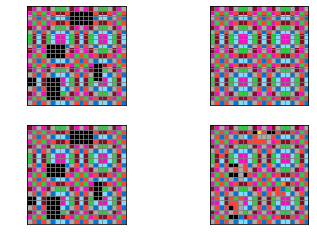

Average test loss: 162.5022735595703
Failed to solve task 0dfd9992.json.
Attempted 13 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 0e206a2e.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


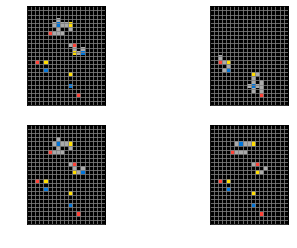

Average test loss: 70.864013671875
Failed to solve task 0e206a2e.json.
Attempted 14 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 11852cab.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


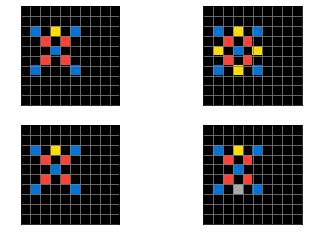

Average test loss: 21.314800262451172
Failed to solve task 11852cab.json.
Attempted 15 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 150deff5.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


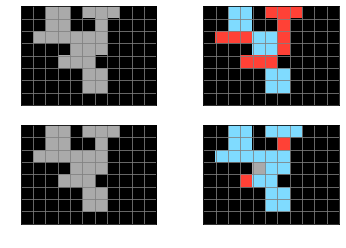

Average test loss: 24.376338958740234
Failed to solve task 150deff5.json.
Attempted 16 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 178fcbfb.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


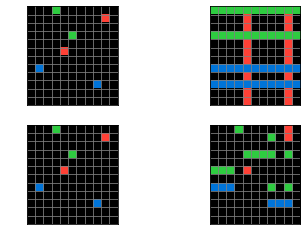

Average test loss: 90.65765380859375
Failed to solve task 178fcbfb.json.
Attempted 17 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 1a07d186.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


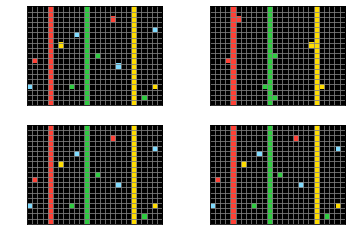

Average test loss: 60.6717414855957
Failed to solve task 1a07d186.json.
Attempted 18 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 1b60fb0c.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


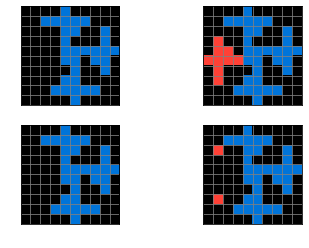

Average test loss: 22.211875915527344
Failed to solve task 1b60fb0c.json.
Attempted 19 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 1bfc4729.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


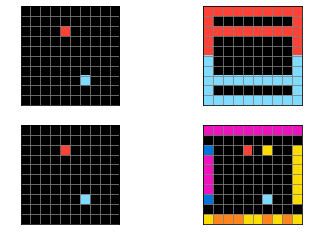

Average test loss: 116.57308959960938
Failed to solve task 1bfc4729.json.
Attempted 20 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 1caeab9d.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


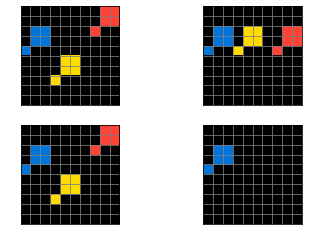

Average test loss: 27.508516311645508
Failed to solve task 1caeab9d.json.
Attempted 21 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 1e0a9b12.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


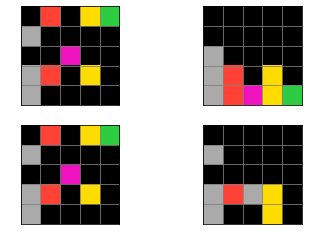

Average test loss: 18.91240119934082
Failed to solve task 1e0a9b12.json.
Attempted 22 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 1e32b0e9.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


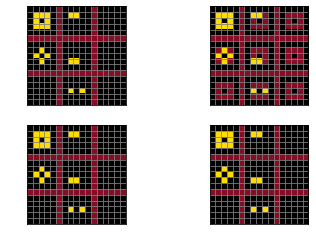

Average test loss: 128.35202026367188
Failed to solve task 1e32b0e9.json.
Attempted 23 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 1f0c79e5.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


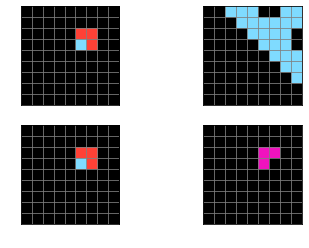

Average test loss: 50.29669952392578
Failed to solve task 1f0c79e5.json.
Attempted 24 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 1f642eb9.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


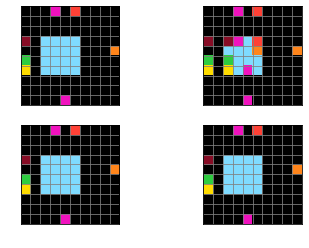

Average test loss: 18.146259307861328
Failed to solve task 1f642eb9.json.
Attempted 25 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 1f876c06.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


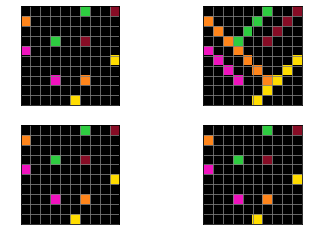

Average test loss: 36.03657913208008
Failed to solve task 1f876c06.json.
Attempted 26 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 2204b7a8.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


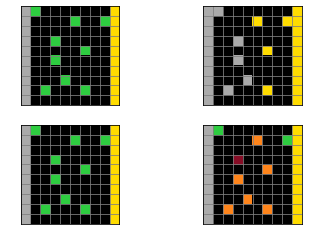

Average test loss: 25.740680694580078
Failed to solve task 2204b7a8.json.
Attempted 27 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 22168020.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


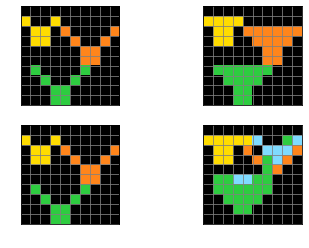

Average test loss: 52.09935760498047
Failed to solve task 22168020.json.
Attempted 28 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 22233c11.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


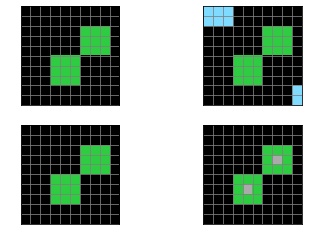

Average test loss: 34.753028869628906
Failed to solve task 22233c11.json.
Attempted 29 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 2281f1f4.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


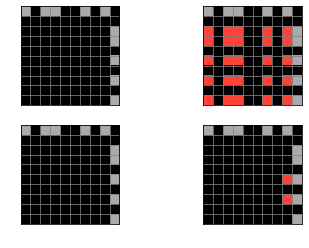

Average test loss: 50.125789642333984
Failed to solve task 2281f1f4.json.
Attempted 30 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 228f6490.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


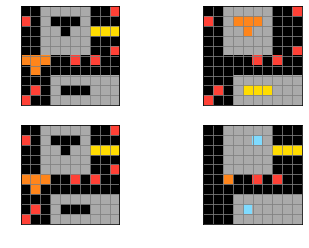

Average test loss: 40.74447250366211
Failed to solve task 228f6490.json.
Attempted 31 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 22eb0ac0.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


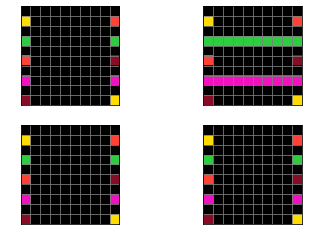

Average test loss: 38.36386489868164
Failed to solve task 22eb0ac0.json.
Attempted 32 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 23581191.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


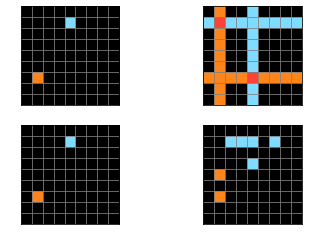

Average test loss: 47.511260986328125
Failed to solve task 23581191.json.
Attempted 33 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 253bf280.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


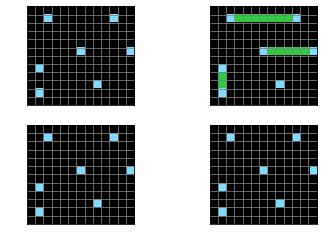

Average test loss: 31.212154388427734
Failed to solve task 253bf280.json.
Attempted 34 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 25d487eb.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


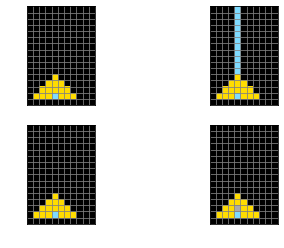

Average test loss: 34.987674713134766
Failed to solve task 25d487eb.json.
Attempted 35 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 25d8a9c8.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


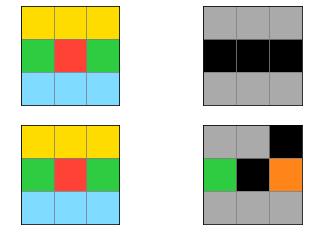

Average test loss: 11.706979751586914
Failed to solve task 25d8a9c8.json.
Attempted 36 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 25ff71a9.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


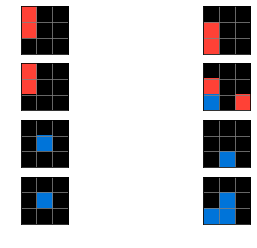

Average test loss: 4.11012077331543
Failed to solve task 25ff71a9.json.
Attempted 37 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 264363fd.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


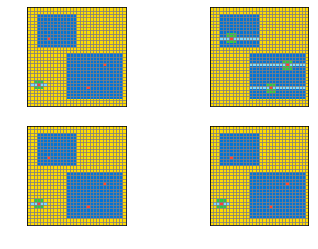

Average test loss: 301.43841552734375
Failed to solve task 264363fd.json.
Attempted 38 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 272f95fa.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


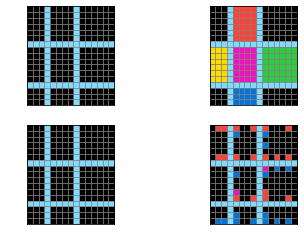

Average test loss: 191.6854248046875
Failed to solve task 272f95fa.json.
Attempted 39 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 28e73c20.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


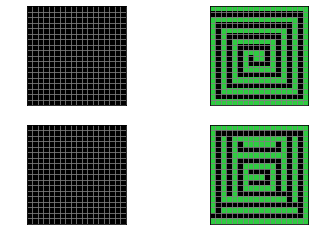

Average test loss: 125.59248352050781
Failed to solve task 28e73c20.json.
Attempted 40 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 29623171.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


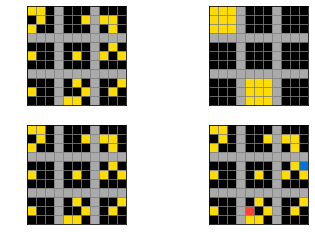

Average test loss: 56.96616744995117
Failed to solve task 29623171.json.
Attempted 41 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 29c11459.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


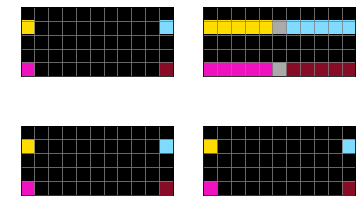

Average test loss: 39.289798736572266
Failed to solve task 29c11459.json.
Attempted 42 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 29ec7d0e.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


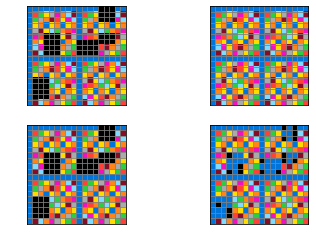

Average test loss: 100.30021667480469
Failed to solve task 29ec7d0e.json.
Attempted 43 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 2bcee788.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


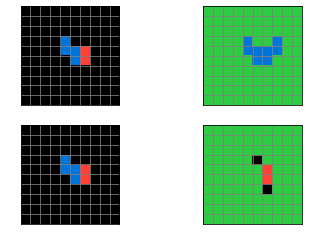

Average test loss: 34.097537994384766
Failed to solve task 2bcee788.json.
Attempted 44 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 2bee17df.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


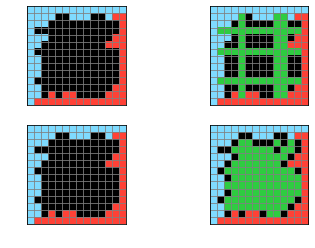

Average test loss: 76.90750122070312
Failed to solve task 2bee17df.json.
Attempted 45 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 2c608aff.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


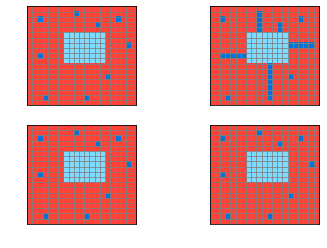

Average test loss: 53.183021545410156
Failed to solve task 2c608aff.json.
Attempted 46 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 2dd70a9a.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


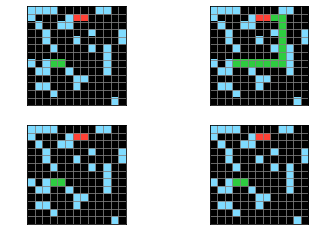

Average test loss: 33.89424133300781
Failed to solve task 2dd70a9a.json.
Attempted 47 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 31aa019c.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


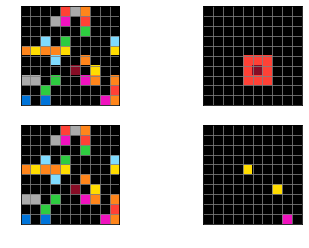

Average test loss: 39.54240417480469
Failed to solve task 31aa019c.json.
Attempted 48 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 321b1fc6.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


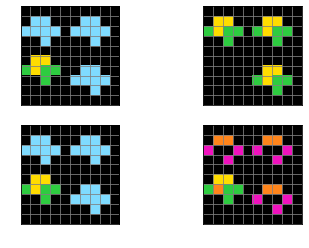

Average test loss: 46.25306701660156
Failed to solve task 321b1fc6.json.
Attempted 49 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 32597951.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


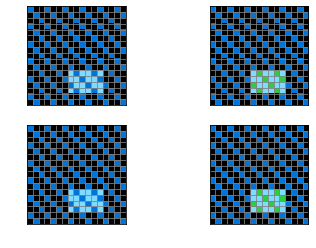

Average test loss: 56.04362487792969
Solved task 32597951.json successfully!
Attempted 50 out of 262 tasks.

Solved 2 tasks so far:
['0ca9ddb6.json', '32597951.json']
Training model 3345333e.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


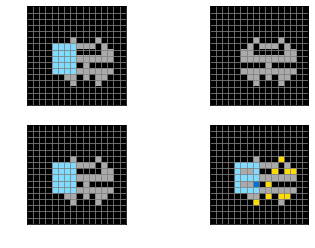

Average test loss: 179.78713989257812
Failed to solve task 3345333e.json.
Attempted 51 out of 262 tasks.

Solved 2 tasks so far:
['0ca9ddb6.json', '32597951.json']
Training model 3618c87e.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


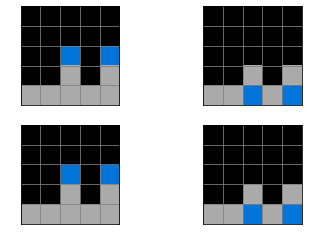

Average test loss: 6.861595153808594
Solved task 3618c87e.json successfully!
Attempted 52 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json']
Training model 3631a71a.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


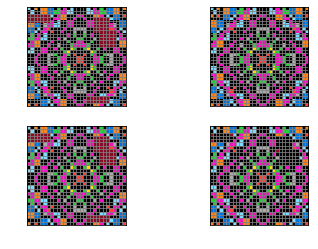

Average test loss: 135.9180450439453
Failed to solve task 3631a71a.json.
Attempted 53 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json']
Training model 363442ee.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


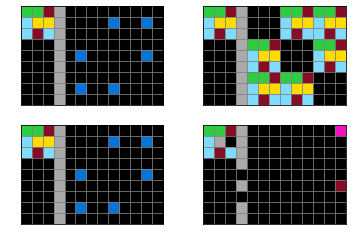

Average test loss: 123.58734893798828
Failed to solve task 363442ee.json.
Attempted 54 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json']
Training model 36d67576.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


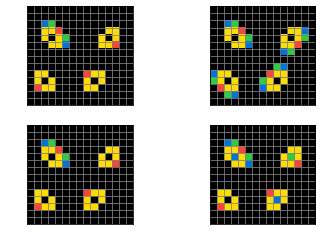

Average test loss: 34.967987060546875
Failed to solve task 36d67576.json.
Attempted 55 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json']
Training model 36fdfd69.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


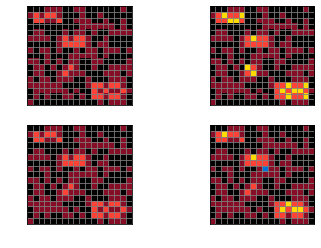

Average test loss: 85.90187072753906
Failed to solve task 36fdfd69.json.
Attempted 56 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json']
Training model 3906de3d.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


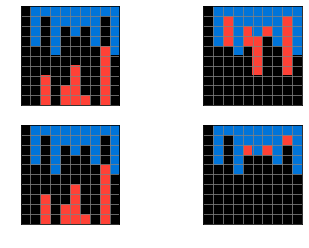

Average test loss: 24.814424514770508
Failed to solve task 3906de3d.json.
Attempted 57 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json']
Training model 39e1d7f9.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


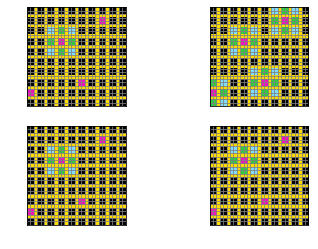

Average test loss: 264.71533203125
Failed to solve task 39e1d7f9.json.
Attempted 58 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json']
Training model 3aa6fb7a.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


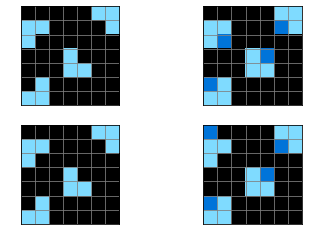

Average test loss: 8.405471801757812
Failed to solve task 3aa6fb7a.json.
Attempted 59 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json']
Training model 3ac3eb23.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


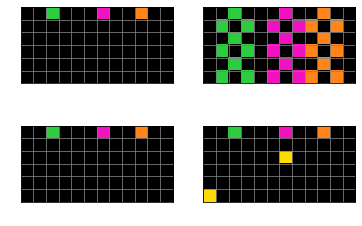

Average test loss: 60.40959930419922
Failed to solve task 3ac3eb23.json.
Attempted 60 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json']
Training model 3bd67248.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


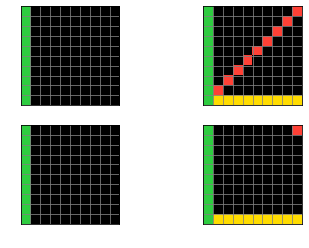

Average test loss: 29.558591842651367
Failed to solve task 3bd67248.json.
Attempted 61 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json']
Training model 3bdb4ada.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


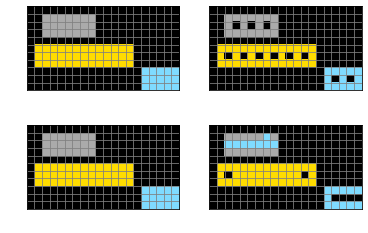

Average test loss: 51.599037170410156
Failed to solve task 3bdb4ada.json.
Attempted 62 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json']
Training model 3befdf3e.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


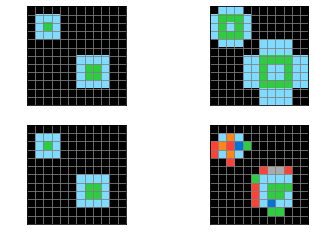

Average test loss: 200.6966552734375
Failed to solve task 3befdf3e.json.
Attempted 63 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json']
Training model 3c9b0459.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


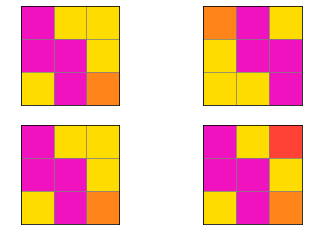

Average test loss: 14.7752685546875
Failed to solve task 3c9b0459.json.
Attempted 64 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json']
Training model 3e980e27.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


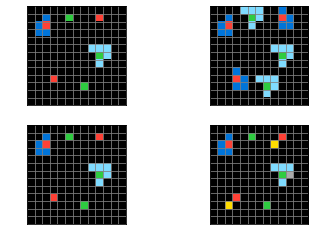

Average test loss: 48.51166534423828
Failed to solve task 3e980e27.json.
Attempted 65 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json']
Training model 3eda0437.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


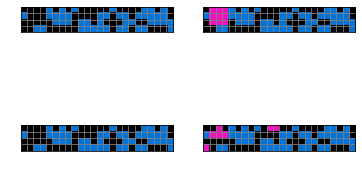

Average test loss: 20.54694366455078
Failed to solve task 3eda0437.json.
Attempted 66 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json']
Training model 40853293.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


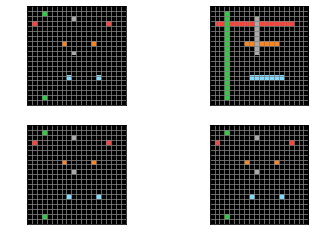

Average test loss: 99.28927612304688
Failed to solve task 40853293.json.
Attempted 67 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json']
Training model 4093f84a.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


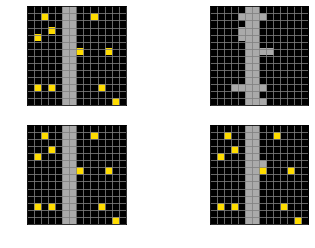

Average test loss: 41.33673858642578
Failed to solve task 4093f84a.json.
Attempted 68 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json']
Training model 41e4d17e.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


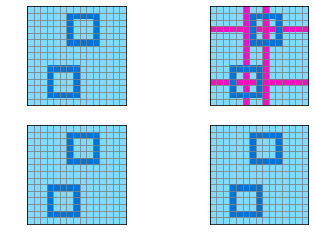

Average test loss: 77.84416198730469
Failed to solve task 41e4d17e.json.
Attempted 69 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json']
Training model 4258a5f9.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


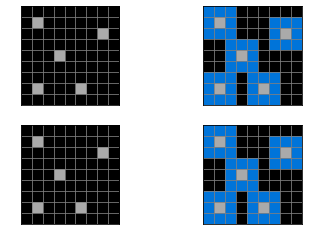

Average test loss: 22.47658348083496
Solved task 4258a5f9.json successfully!
Attempted 70 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json']
Training model 42a50994.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


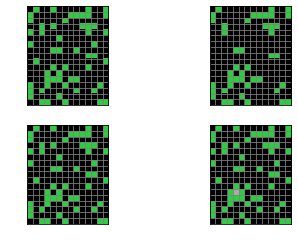

Average test loss: 56.72765350341797
Failed to solve task 42a50994.json.
Attempted 71 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json']
Training model 4347f46a.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


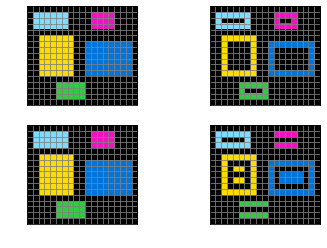

Average test loss: 91.88321685791016
Failed to solve task 4347f46a.json.
Attempted 72 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json']
Training model 444801d8.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


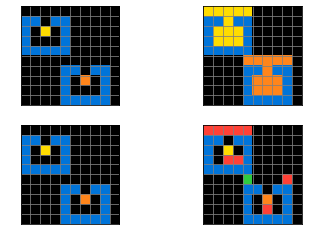

Average test loss: 47.561553955078125
Failed to solve task 444801d8.json.
Attempted 73 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json']
Training model 447fd412.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


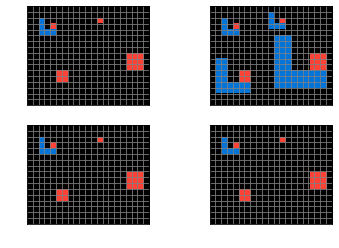

Average test loss: 133.45755004882812
Failed to solve task 447fd412.json.
Attempted 74 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json']
Training model 44d8ac46.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


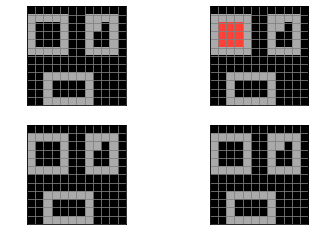

Average test loss: 22.789459228515625
Failed to solve task 44d8ac46.json.
Attempted 75 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json']
Training model 4612dd53.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


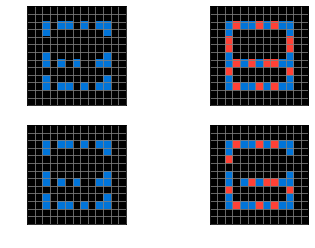

Average test loss: 18.993974685668945
Failed to solve task 4612dd53.json.
Attempted 76 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json']
Training model 484b58aa.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


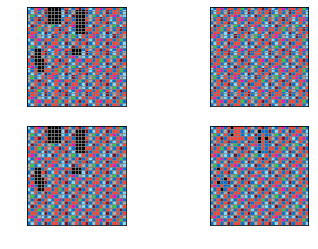

Average test loss: 141.39613342285156
Failed to solve task 484b58aa.json.
Attempted 77 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json']
Training model 4938f0c2.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


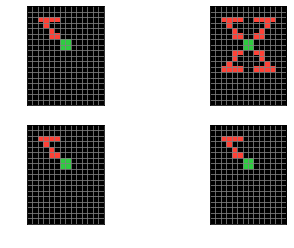

Average test loss: 52.201698303222656
Failed to solve task 4938f0c2.json.
Attempted 78 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json']
Training model 496994bd.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


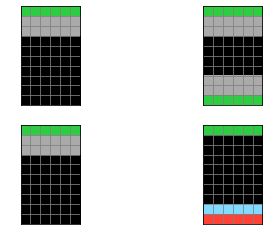

Average test loss: 71.65631103515625
Failed to solve task 496994bd.json.
Attempted 79 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json']
Training model 4c5c2cf0.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


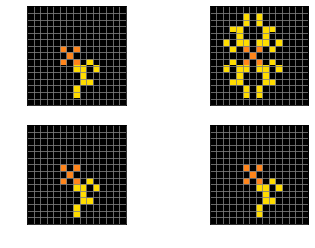

Average test loss: 62.26895523071289
Failed to solve task 4c5c2cf0.json.
Attempted 80 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json']
Training model 50846271.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


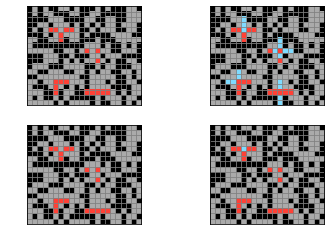

Average test loss: 51.512969970703125
Failed to solve task 50846271.json.
Attempted 81 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json']
Training model 508bd3b6.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


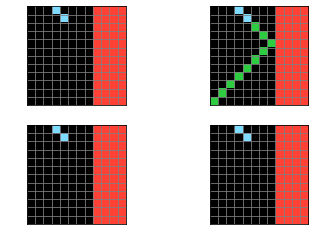

Average test loss: 25.520177841186523
Failed to solve task 508bd3b6.json.
Attempted 82 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json']
Training model 50cb2852.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


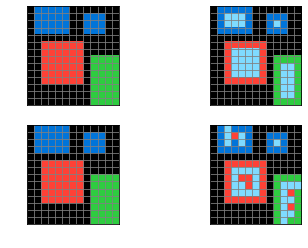

Average test loss: 37.25535202026367
Failed to solve task 50cb2852.json.
Attempted 83 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json']
Training model 5168d44c.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


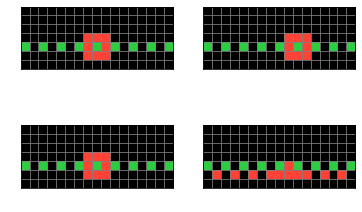

Average test loss: 26.36731719970703
Failed to solve task 5168d44c.json.
Attempted 84 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json']
Training model 543a7ed5.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


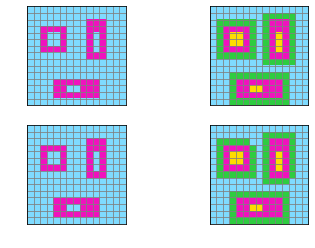

Average test loss: 51.58635711669922
Failed to solve task 543a7ed5.json.
Attempted 85 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json']
Training model 54d82841.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


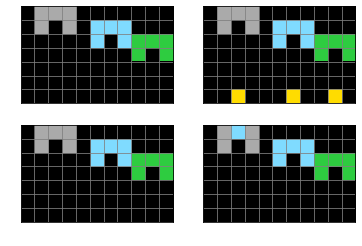

Average test loss: 14.135359764099121
Failed to solve task 54d82841.json.
Attempted 86 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json']
Training model 54d9e175.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


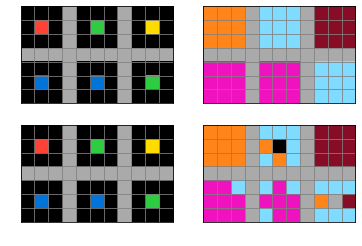

Average test loss: 65.50212097167969
Failed to solve task 54d9e175.json.
Attempted 87 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json']
Training model 5521c0d9.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


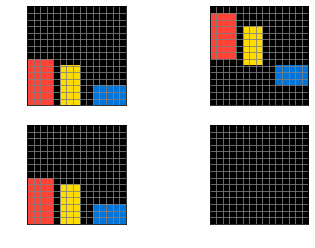

Average test loss: 110.65132141113281
Failed to solve task 5521c0d9.json.
Attempted 88 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json']
Training model 5582e5ca.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


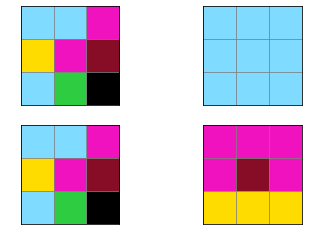

Average test loss: 14.310245513916016
Failed to solve task 5582e5ca.json.
Attempted 89 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json']
Training model 56dc2b01.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


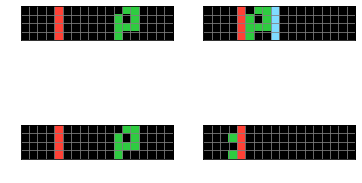

Average test loss: 32.281089782714844
Failed to solve task 56dc2b01.json.
Attempted 90 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json']
Training model 56ff96f3.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


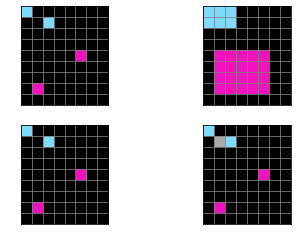

Average test loss: 54.71746063232422
Failed to solve task 56ff96f3.json.
Attempted 91 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json']
Training model 57aa92db.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


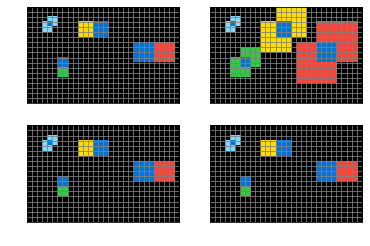

Average test loss: 328.6465148925781
Failed to solve task 57aa92db.json.
Attempted 92 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json']
Training model 5c0a986e.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


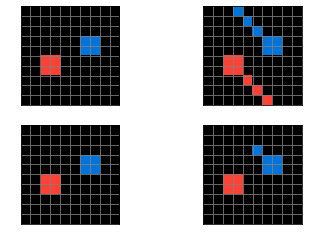

Average test loss: 13.94325065612793
Failed to solve task 5c0a986e.json.
Attempted 93 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json']
Training model 5c2c9af4.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


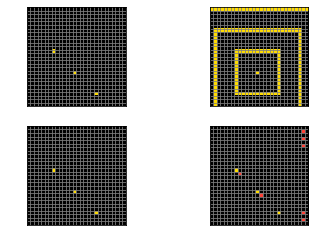

Average test loss: 403.3150939941406
Failed to solve task 5c2c9af4.json.
Attempted 94 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json']
Training model 60b61512.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


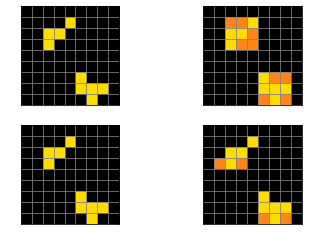

Average test loss: 17.095413208007812
Failed to solve task 60b61512.json.
Attempted 95 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json']
Training model 6150a2bd.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


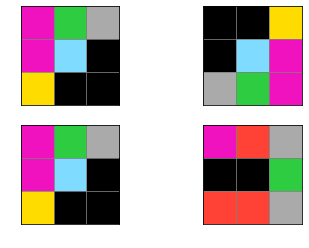

Average test loss: 49.69355773925781
Failed to solve task 6150a2bd.json.
Attempted 96 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json']
Training model 623ea044.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


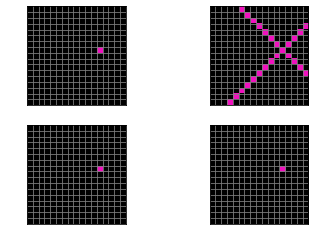

Average test loss: 62.23891830444336
Failed to solve task 623ea044.json.
Attempted 97 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json']
Training model 63613498.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


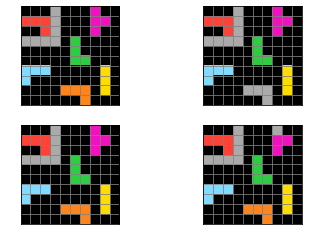

Average test loss: 23.042701721191406
Failed to solve task 63613498.json.
Attempted 98 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json']
Training model 6455b5f5.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


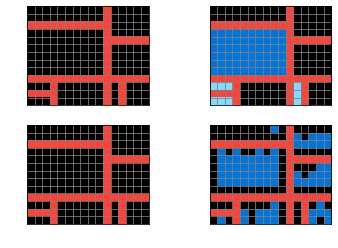

Average test loss: 118.52891540527344
Failed to solve task 6455b5f5.json.
Attempted 99 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json']
Training model 67385a82.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


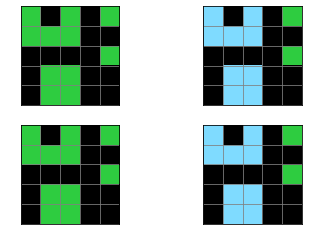

Average test loss: 8.044502258300781
Solved task 67385a82.json successfully!
Attempted 100 out of 262 tasks.

Solved 5 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json']
Training model 673ef223.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


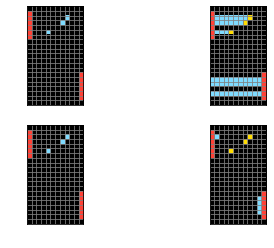

Average test loss: 100.79242706298828
Failed to solve task 673ef223.json.
Attempted 101 out of 262 tasks.

Solved 5 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json']
Training model 67a3c6ac.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


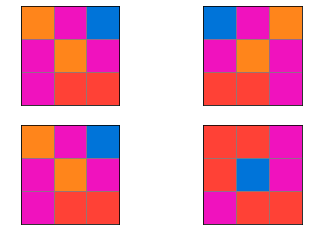

Average test loss: 7.490665435791016
Failed to solve task 67a3c6ac.json.
Attempted 102 out of 262 tasks.

Solved 5 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json']
Training model 67a423a3.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


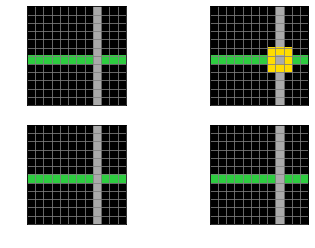

Average test loss: 48.053192138671875
Failed to solve task 67a423a3.json.
Attempted 103 out of 262 tasks.

Solved 5 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json']
Training model 6855a6e4.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


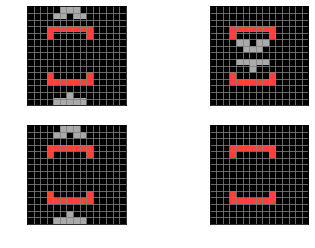

Average test loss: 38.93318176269531
Failed to solve task 6855a6e4.json.
Attempted 104 out of 262 tasks.

Solved 5 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json']
Training model 68b16354.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


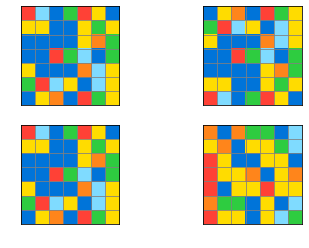

Average test loss: 73.08968353271484
Failed to solve task 68b16354.json.
Attempted 105 out of 262 tasks.

Solved 5 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json']
Training model 694f12f3.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


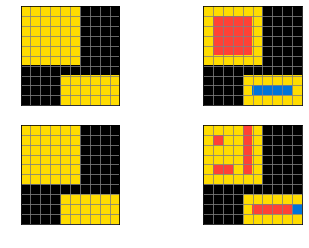

Average test loss: 24.3896427154541
Failed to solve task 694f12f3.json.
Attempted 106 out of 262 tasks.

Solved 5 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json']
Training model 6a1e5592.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


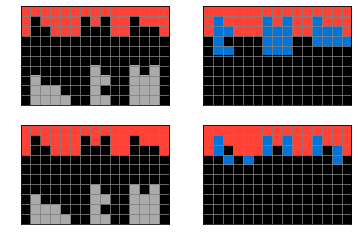

Average test loss: 41.811893463134766
Failed to solve task 6a1e5592.json.
Attempted 107 out of 262 tasks.

Solved 5 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json']
Training model 6aa20dc0.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


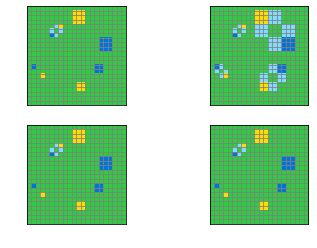

Average test loss: 228.9150390625
Failed to solve task 6aa20dc0.json.
Attempted 108 out of 262 tasks.

Solved 5 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json']
Training model 6c434453.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


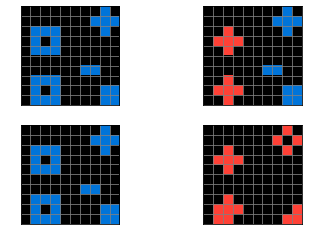

Average test loss: 29.306171417236328
Failed to solve task 6c434453.json.
Attempted 109 out of 262 tasks.

Solved 5 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json']
Training model 6cdd2623.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


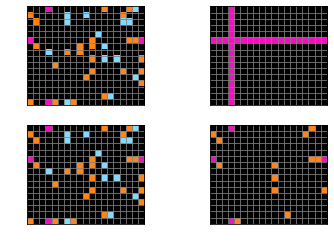

Average test loss: 112.56455993652344
Failed to solve task 6cdd2623.json.
Attempted 110 out of 262 tasks.

Solved 5 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json']
Training model 6cf79266.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


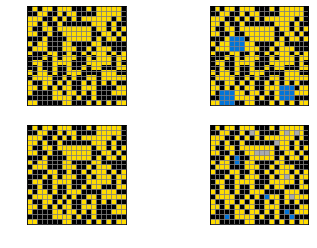

Average test loss: 121.59552001953125
Failed to solve task 6cf79266.json.
Attempted 111 out of 262 tasks.

Solved 5 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json']
Training model 6d0160f0.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


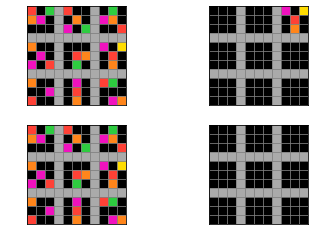

Average test loss: 28.2910213470459
Failed to solve task 6d0160f0.json.
Attempted 112 out of 262 tasks.

Solved 5 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json']
Training model 6d58a25d.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


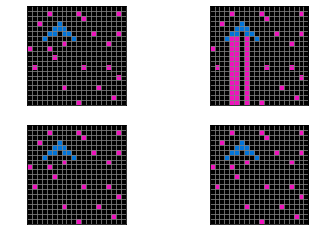

Average test loss: 111.98443603515625
Failed to solve task 6d58a25d.json.
Attempted 113 out of 262 tasks.

Solved 5 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json']
Training model 6d75e8bb.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


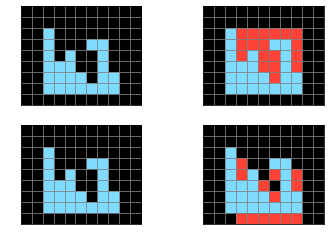

Average test loss: 34.80461120605469
Failed to solve task 6d75e8bb.json.
Attempted 114 out of 262 tasks.

Solved 5 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json']
Training model 6e02f1e3.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


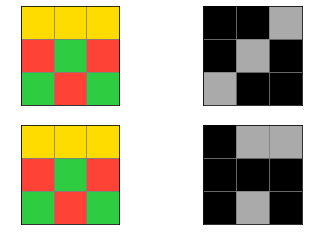

Average test loss: 19.313663482666016
Failed to solve task 6e02f1e3.json.
Attempted 115 out of 262 tasks.

Solved 5 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json']
Training model 6e19193c.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


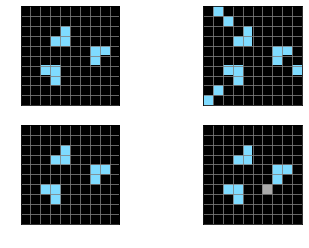

Average test loss: 28.99638557434082
Failed to solve task 6e19193c.json.
Attempted 116 out of 262 tasks.

Solved 5 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json']
Training model 6e82a1ae.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


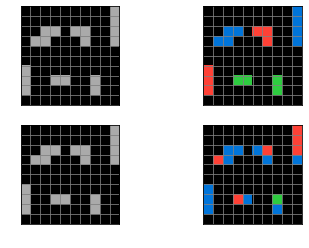

Average test loss: 22.469058990478516
Failed to solve task 6e82a1ae.json.
Attempted 117 out of 262 tasks.

Solved 5 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json']
Training model 6f8cd79b.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


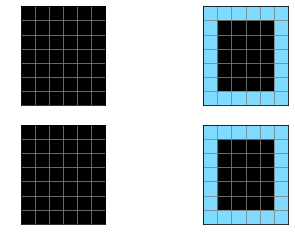

Average test loss: 13.056087493896484
Solved task 6f8cd79b.json successfully!
Attempted 118 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 72322fa7.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


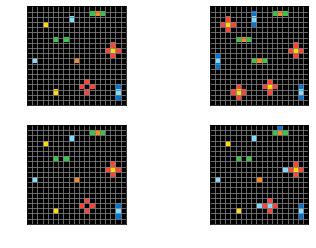

Average test loss: 52.04869079589844
Failed to solve task 72322fa7.json.
Attempted 119 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 73251a56.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


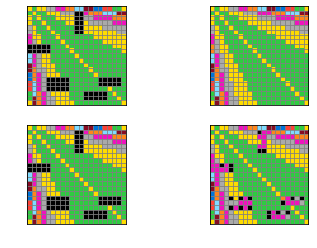

Average test loss: 174.45664978027344
Failed to solve task 73251a56.json.
Attempted 120 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 7447852a.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


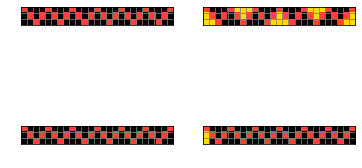

Average test loss: 33.763362884521484
Failed to solve task 7447852a.json.
Attempted 121 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 74dd1130.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


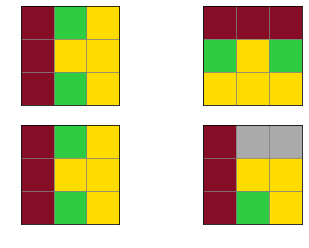

Average test loss: 26.598180770874023
Failed to solve task 74dd1130.json.
Attempted 122 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 760b3cac.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


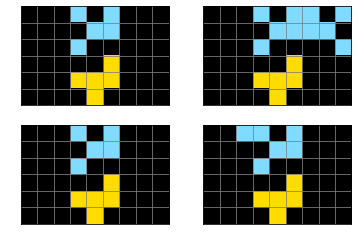

Average test loss: 12.303272247314453
Failed to solve task 760b3cac.json.
Attempted 123 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 776ffc46.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


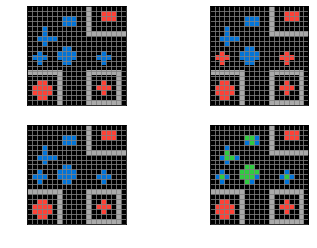

Average test loss: 63.17327117919922
Failed to solve task 776ffc46.json.
Attempted 124 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 794b24be.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


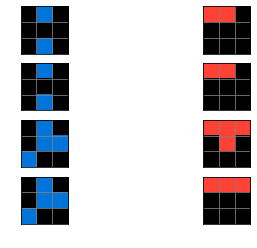

Average test loss: 1.7882518768310547
Failed to solve task 794b24be.json.
Attempted 125 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 7b6016b9.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


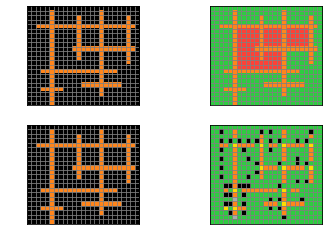

Average test loss: 465.0148620605469
Failed to solve task 7b6016b9.json.
Attempted 126 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 7ddcd7ec.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


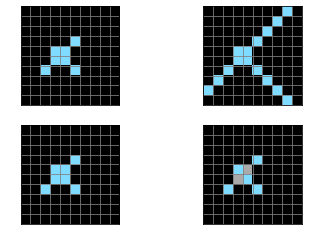

Average test loss: 30.135112762451172
Failed to solve task 7ddcd7ec.json.
Attempted 127 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 7df24a62.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


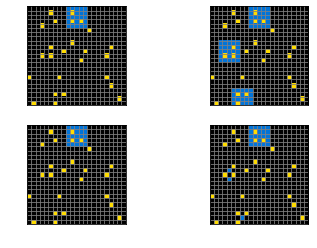

Average test loss: 91.30673217773438
Failed to solve task 7df24a62.json.
Attempted 128 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 7e0986d6.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


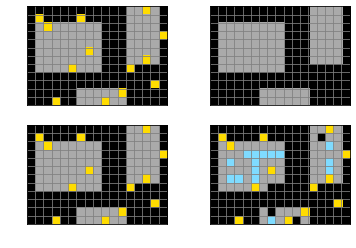

Average test loss: 97.19534301757812
Failed to solve task 7e0986d6.json.
Attempted 129 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 7f4411dc.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


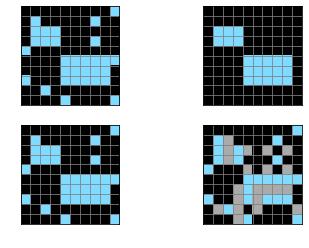

Average test loss: 120.71398162841797
Failed to solve task 7f4411dc.json.
Attempted 130 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 810b9b61.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


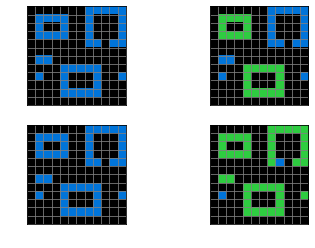

Average test loss: 37.66511917114258
Failed to solve task 810b9b61.json.
Attempted 131 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 82819916.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


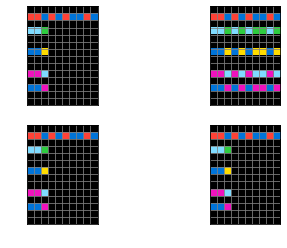

Average test loss: 57.016319274902344
Failed to solve task 82819916.json.
Attempted 132 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 83302e8f.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


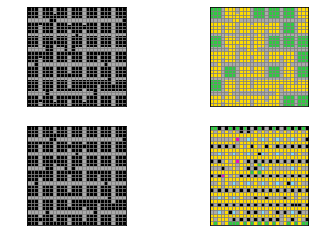

Average test loss: 1516.4964599609375
Failed to solve task 83302e8f.json.
Attempted 133 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 834ec97d.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


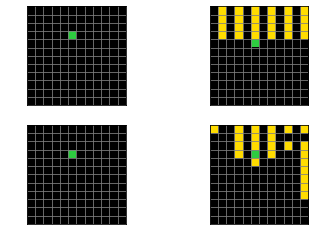

Average test loss: 43.54901123046875
Failed to solve task 834ec97d.json.
Attempted 134 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 8403a5d5.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


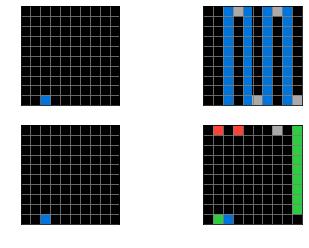

Average test loss: 112.06370544433594
Failed to solve task 8403a5d5.json.
Attempted 135 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 855e0971.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


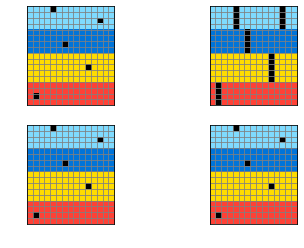

Average test loss: 41.92390823364258
Failed to solve task 855e0971.json.
Attempted 136 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 85c4e7cd.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


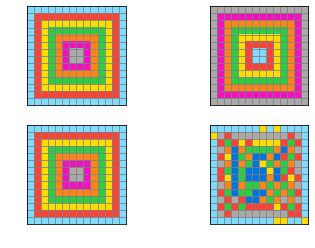

Average test loss: 558.6360473632812
Failed to solve task 85c4e7cd.json.
Attempted 137 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 868de0fa.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


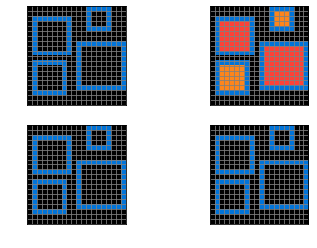

Average test loss: 222.80014038085938
Failed to solve task 868de0fa.json.
Attempted 138 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 88a10436.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


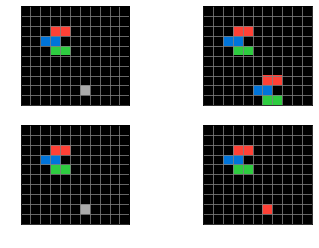

Average test loss: 14.298471450805664
Failed to solve task 88a10436.json.
Attempted 139 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 890034e9.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


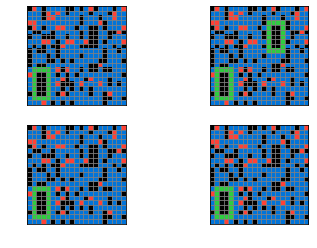

Average test loss: 61.575496673583984
Failed to solve task 890034e9.json.
Attempted 140 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 8d510a79.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


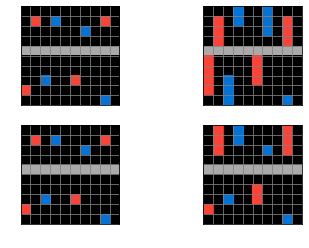

Average test loss: 26.980695724487305
Failed to solve task 8d510a79.json.
Attempted 141 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 8e5a5113.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


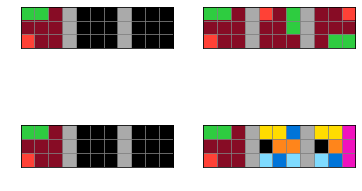

Average test loss: 26.125408172607422
Failed to solve task 8e5a5113.json.
Attempted 142 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 8eb1be9a.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


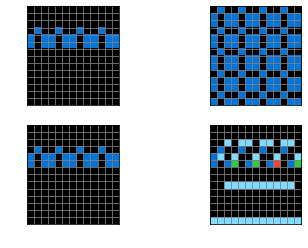

Average test loss: 184.6181182861328
Failed to solve task 8eb1be9a.json.
Attempted 143 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 8f2ea7aa.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


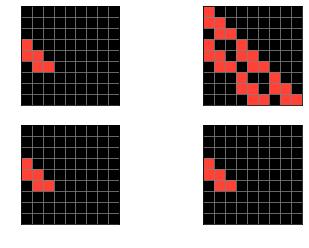

Average test loss: 42.47710418701172
Failed to solve task 8f2ea7aa.json.
Attempted 144 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 90f3ed37.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


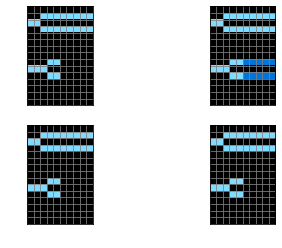

Average test loss: 34.542755126953125
Failed to solve task 90f3ed37.json.
Attempted 145 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 913fb3ed.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


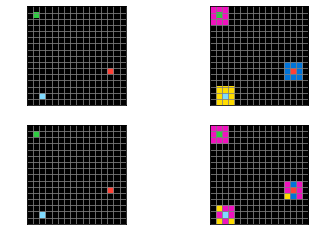

Average test loss: 33.32461166381836
Failed to solve task 913fb3ed.json.
Attempted 146 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 91714a58.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


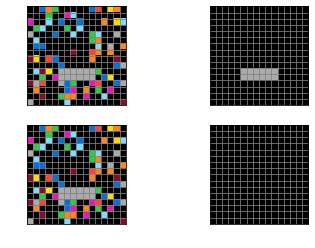

Average test loss: 62.3714599609375
Failed to solve task 91714a58.json.
Attempted 147 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 928ad970.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


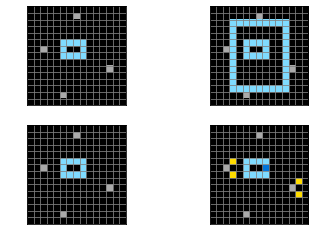

Average test loss: 107.57991790771484
Failed to solve task 928ad970.json.
Attempted 148 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 93b581b8.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


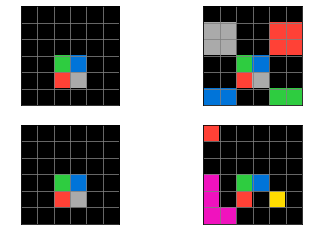

Average test loss: 36.986236572265625
Failed to solve task 93b581b8.json.
Attempted 149 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 941d9a10.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


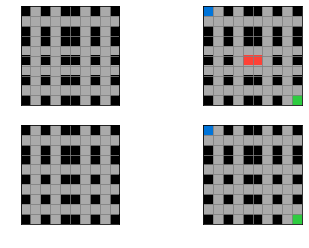

Average test loss: 17.84956169128418
Failed to solve task 941d9a10.json.
Attempted 150 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 952a094c.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


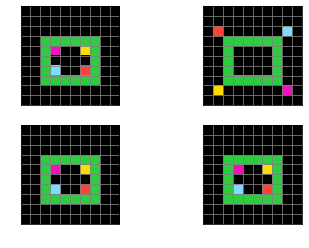

Average test loss: 29.786746978759766
Failed to solve task 952a094c.json.
Attempted 151 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 9565186b.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


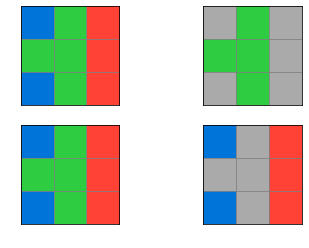

Average test loss: 18.765621185302734
Failed to solve task 9565186b.json.
Attempted 152 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 95990924.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


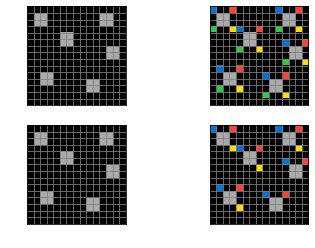

Average test loss: 33.46037292480469
Failed to solve task 95990924.json.
Attempted 153 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 97999447.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


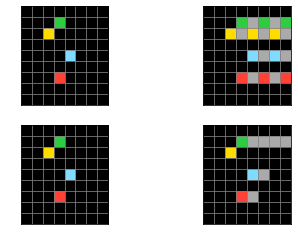

Average test loss: 33.56144714355469
Failed to solve task 97999447.json.
Attempted 154 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 98cf29f8.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


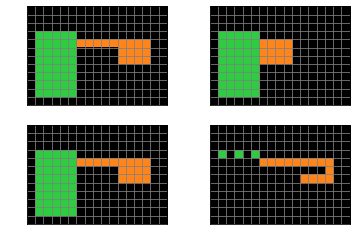

Average test loss: 81.85296630859375
Failed to solve task 98cf29f8.json.
Attempted 155 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 99fa7670.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


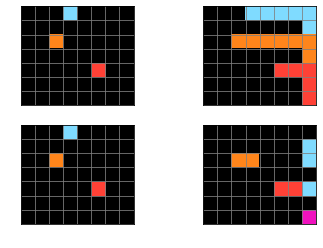

Average test loss: 26.281204223632812
Failed to solve task 99fa7670.json.
Attempted 156 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 9d9215db.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


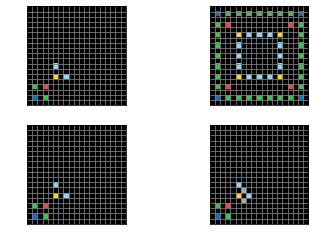

Average test loss: 106.28380584716797
Failed to solve task 9d9215db.json.
Attempted 157 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 9dfd6313.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


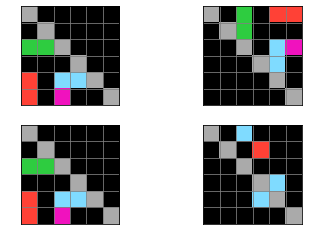

Average test loss: 20.591224670410156
Failed to solve task 9dfd6313.json.
Attempted 158 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 9edfc990.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


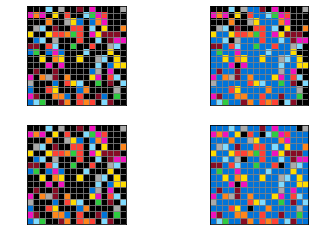

Average test loss: 125.00330352783203
Failed to solve task 9edfc990.json.
Attempted 159 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model a1570a43.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


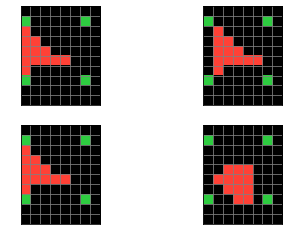

Average test loss: 21.204458236694336
Failed to solve task a1570a43.json.
Attempted 160 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model a2fd1cf0.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


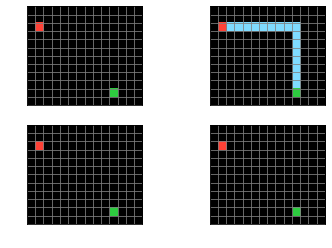

Average test loss: 34.69955062866211
Failed to solve task a2fd1cf0.json.
Attempted 161 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model a3df8b1e.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


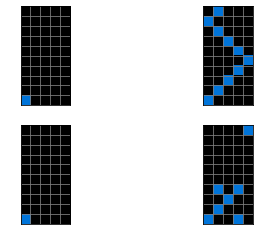

Average test loss: 20.15924072265625
Failed to solve task a3df8b1e.json.
Attempted 162 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model a48eeaf7.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


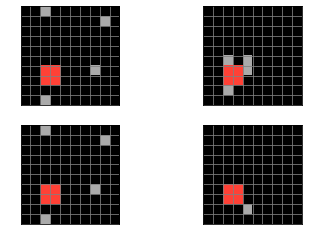

Average test loss: 11.40860366821289
Failed to solve task a48eeaf7.json.
Attempted 163 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model a5313dff.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


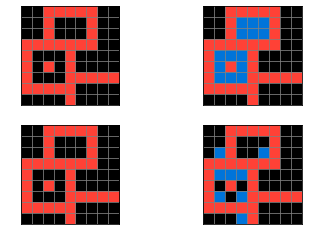

Average test loss: 22.40672492980957
Failed to solve task a5313dff.json.
Attempted 164 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model a5f85a15.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


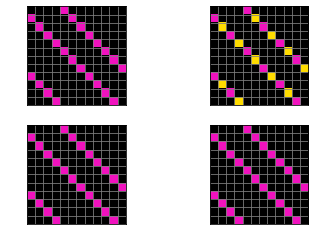

Average test loss: 36.51702117919922
Failed to solve task a5f85a15.json.
Attempted 165 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model a61f2674.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


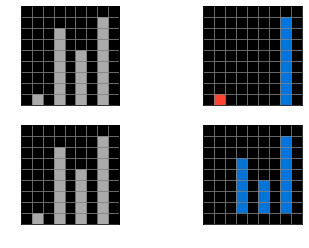

Average test loss: 24.813766479492188
Failed to solve task a61f2674.json.
Attempted 166 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model a64e4611.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


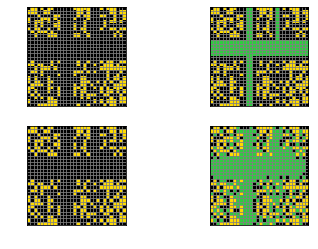

Average test loss: 430.48779296875
Failed to solve task a64e4611.json.
Attempted 167 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model a65b410d.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


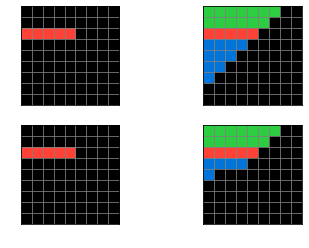

Average test loss: 25.402122497558594
Failed to solve task a65b410d.json.
Attempted 168 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model a699fb00.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


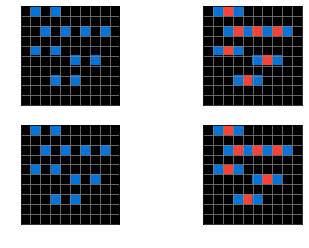

Average test loss: 27.620101928710938
Solved task a699fb00.json successfully!
Attempted 169 out of 262 tasks.

Solved 7 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json']
Training model a78176bb.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


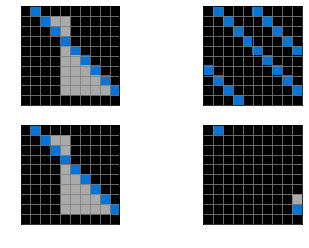

Average test loss: 38.74816131591797
Failed to solve task a78176bb.json.
Attempted 170 out of 262 tasks.

Solved 7 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json']
Training model a79310a0.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


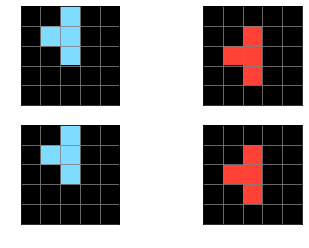

Average test loss: 6.225015163421631
Solved task a79310a0.json successfully!
Attempted 171 out of 262 tasks.

Solved 8 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json']
Training model a85d4709.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


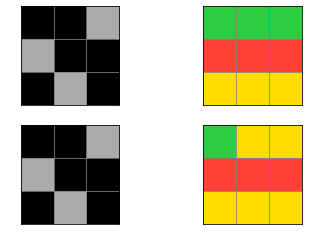

Average test loss: 5.09304141998291
Failed to solve task a85d4709.json.
Attempted 172 out of 262 tasks.

Solved 8 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json']
Training model a8d7556c.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


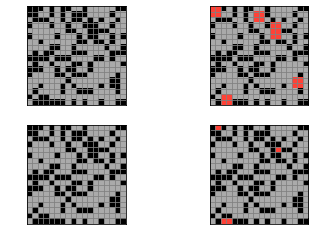

Average test loss: 48.710445404052734
Failed to solve task a8d7556c.json.
Attempted 173 out of 262 tasks.

Solved 8 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json']
Training model a9f96cdd.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


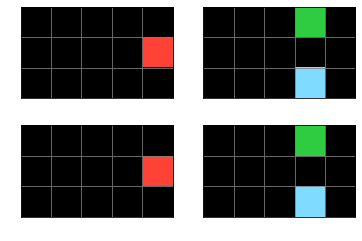

Average test loss: 3.827575922012329
Solved task a9f96cdd.json successfully!
Attempted 174 out of 262 tasks.

Solved 9 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json']
Training model aabf363d.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


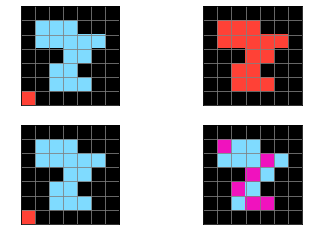

Average test loss: 42.642154693603516
Failed to solve task aabf363d.json.
Attempted 175 out of 262 tasks.

Solved 9 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json']
Training model aba27056.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


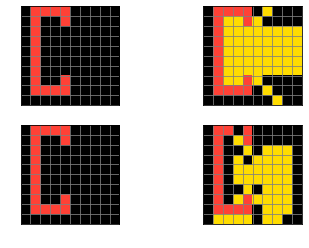

Average test loss: 52.03744888305664
Failed to solve task aba27056.json.
Attempted 176 out of 262 tasks.

Solved 9 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json']
Training model ae3edfdc.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


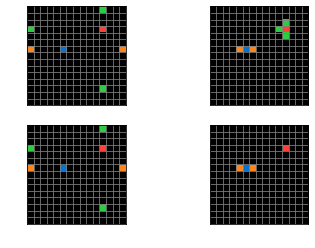

Average test loss: 24.728801727294922
Failed to solve task ae3edfdc.json.
Attempted 177 out of 262 tasks.

Solved 9 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json']
Training model aedd82e4.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


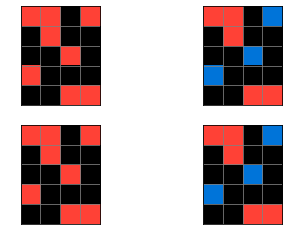

Average test loss: 4.883687973022461
Solved task aedd82e4.json successfully!
Attempted 178 out of 262 tasks.

Solved 10 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json']
Training model af902bf9.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


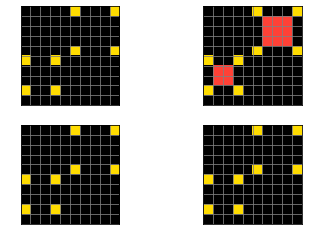

Average test loss: 25.12263298034668
Failed to solve task af902bf9.json.
Attempted 179 out of 262 tasks.

Solved 10 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json']
Training model b1948b0a.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


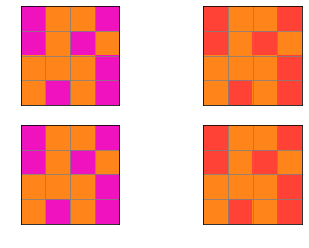

Average test loss: 9.502527236938477
Solved task b1948b0a.json successfully!
Attempted 180 out of 262 tasks.

Solved 11 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json']
Training model b230c067.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


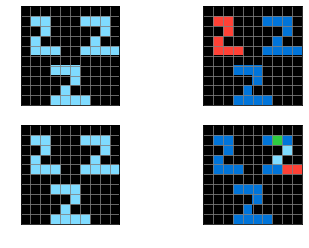

Average test loss: 31.781997680664062
Failed to solve task b230c067.json.
Attempted 181 out of 262 tasks.

Solved 11 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json']
Training model b27ca6d3.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


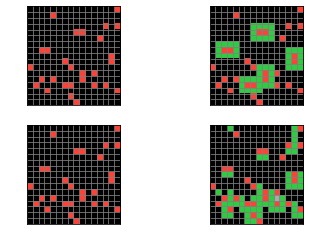

Average test loss: 101.57257080078125
Failed to solve task b27ca6d3.json.
Attempted 182 out of 262 tasks.

Solved 11 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json']
Training model b2862040.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


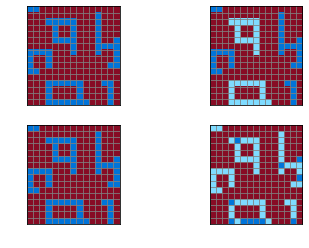

Average test loss: 45.38878631591797
Failed to solve task b2862040.json.
Attempted 183 out of 262 tasks.

Solved 11 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json']
Training model b527c5c6.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


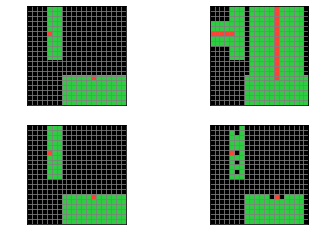

Average test loss: 318.18511962890625
Failed to solve task b527c5c6.json.
Attempted 184 out of 262 tasks.

Solved 11 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json']
Training model b548a754.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


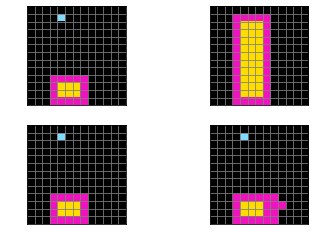

Average test loss: 92.31224060058594
Failed to solve task b548a754.json.
Attempted 185 out of 262 tasks.

Solved 11 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json']
Training model b60334d2.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


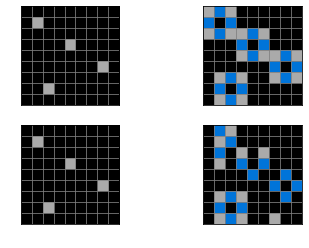

Average test loss: 43.78840637207031
Failed to solve task b60334d2.json.
Attempted 186 out of 262 tasks.

Solved 11 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json']
Training model b6afb2da.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


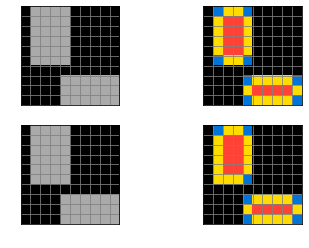

Average test loss: 27.40984344482422
Failed to solve task b6afb2da.json.
Attempted 187 out of 262 tasks.

Solved 11 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json']
Training model b7249182.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


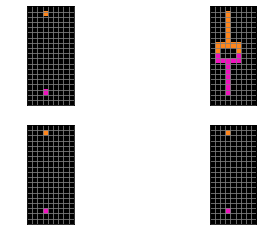

Average test loss: 56.22309875488281
Failed to solve task b7249182.json.
Attempted 188 out of 262 tasks.

Solved 11 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json']
Training model b775ac94.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


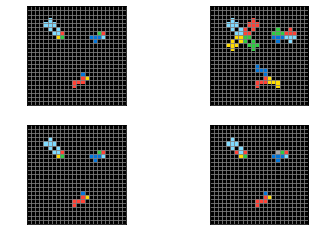

Average test loss: 111.79672241210938
Failed to solve task b775ac94.json.
Attempted 189 out of 262 tasks.

Solved 11 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json']
Training model b782dc8a.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


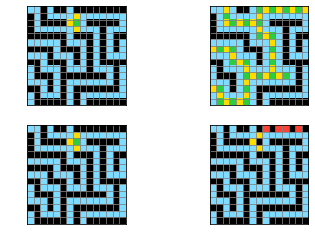

Average test loss: 85.84388732910156
Failed to solve task b782dc8a.json.
Attempted 190 out of 262 tasks.

Solved 11 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json']
Training model b8825c91.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


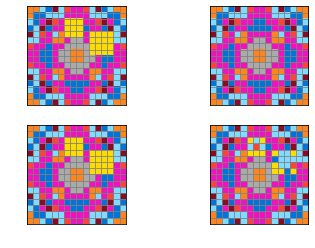

Average test loss: 48.834327697753906
Failed to solve task b8825c91.json.
Attempted 191 out of 262 tasks.

Solved 11 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json']
Training model b8cdaf2b.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


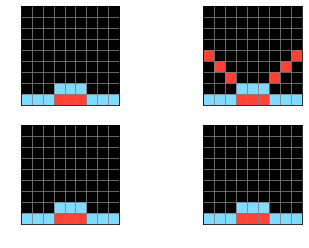

Average test loss: 20.10205078125
Failed to solve task b8cdaf2b.json.
Attempted 192 out of 262 tasks.

Solved 11 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json']
Training model ba26e723.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


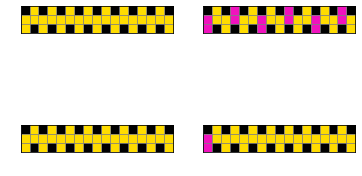

Average test loss: 18.414447784423828
Failed to solve task ba26e723.json.
Attempted 193 out of 262 tasks.

Solved 11 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json']
Training model ba97ae07.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


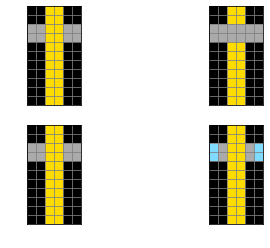

Average test loss: 22.22966766357422
Failed to solve task ba97ae07.json.
Attempted 194 out of 262 tasks.

Solved 11 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json']
Training model bb43febb.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


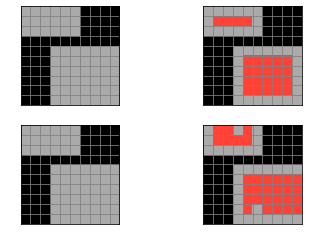

Average test loss: 21.919404983520508
Failed to solve task bb43febb.json.
Attempted 195 out of 262 tasks.

Solved 11 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json']
Training model bd4472b8.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


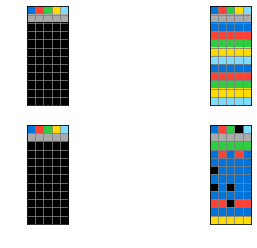

Average test loss: 91.8823471069336
Failed to solve task bd4472b8.json.
Attempted 196 out of 262 tasks.

Solved 11 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json']
Training model bda2d7a6.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


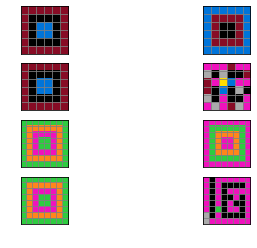

Average test loss: 138.86019897460938
Failed to solve task bda2d7a6.json.
Attempted 197 out of 262 tasks.

Solved 11 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json']
Training model bdad9b1f.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


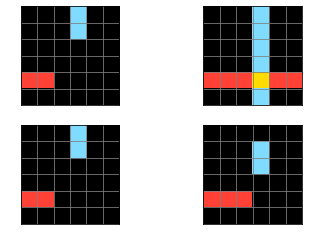

Average test loss: 15.817359924316406
Failed to solve task bdad9b1f.json.
Attempted 198 out of 262 tasks.

Solved 11 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json']
Training model beb8660c.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


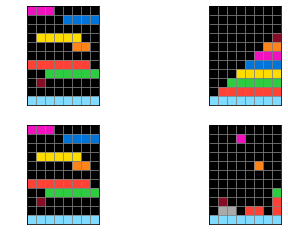

Average test loss: 75.40086364746094
Failed to solve task beb8660c.json.
Attempted 199 out of 262 tasks.

Solved 11 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json']
Training model c0f76784.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


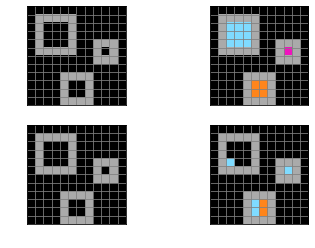

Average test loss: 30.350923538208008
Failed to solve task c0f76784.json.
Attempted 200 out of 262 tasks.

Solved 11 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json']
Training model c1d99e64.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


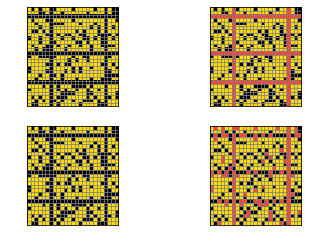

Average test loss: 263.11004638671875
Failed to solve task c1d99e64.json.
Attempted 201 out of 262 tasks.

Solved 11 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json']
Training model c3f564a4.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


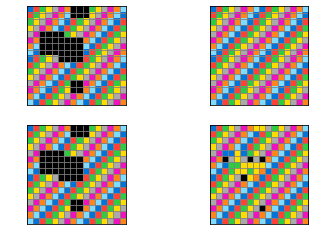

Average test loss: 63.97555923461914
Failed to solve task c3f564a4.json.
Attempted 202 out of 262 tasks.

Solved 11 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json']
Training model c444b776.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


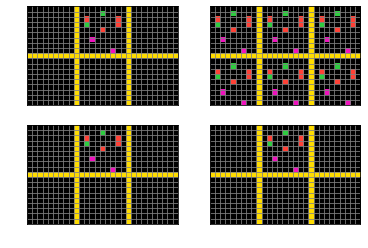

Average test loss: 94.32476043701172
Failed to solve task c444b776.json.
Attempted 203 out of 262 tasks.

Solved 11 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json']
Training model c8f0f002.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


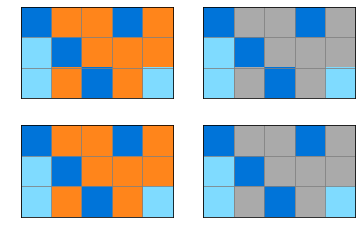

Average test loss: 4.753030776977539
Solved task c8f0f002.json successfully!
Attempted 204 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json']
Training model c9f8e694.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


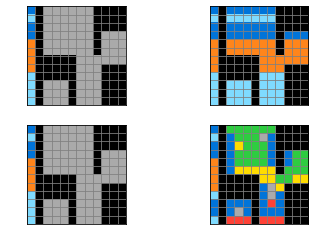

Average test loss: 134.03506469726562
Failed to solve task c9f8e694.json.
Attempted 205 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json']
Training model caa06a1f.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


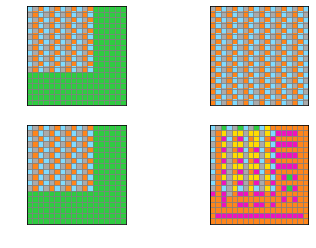

Average test loss: 520.1212768554688
Failed to solve task caa06a1f.json.
Attempted 206 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json']
Training model cbded52d.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


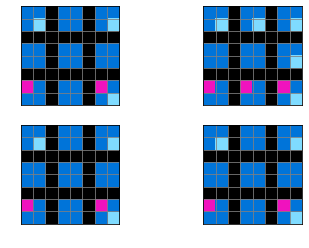

Average test loss: 11.690191268920898
Failed to solve task cbded52d.json.
Attempted 207 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json']
Training model ce22a75a.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


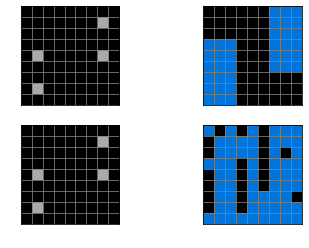

Average test loss: 53.14202880859375
Failed to solve task ce22a75a.json.
Attempted 208 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json']
Training model ce9e57f2.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


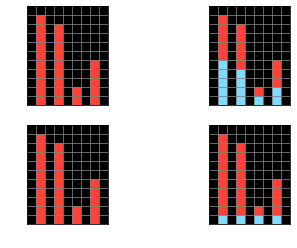

Average test loss: 17.475940704345703
Failed to solve task ce9e57f2.json.
Attempted 209 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json']
Training model d037b0a7.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


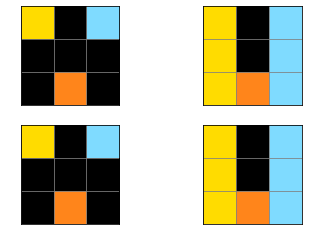

Average test loss: 5.797327995300293
Solved task d037b0a7.json successfully!
Attempted 210 out of 262 tasks.

Solved 13 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json']
Training model d06dbe63.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


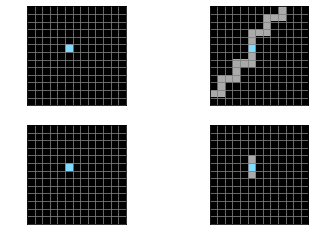

Average test loss: 40.83484649658203
Failed to solve task d06dbe63.json.
Attempted 211 out of 262 tasks.

Solved 13 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json']
Training model d07ae81c.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


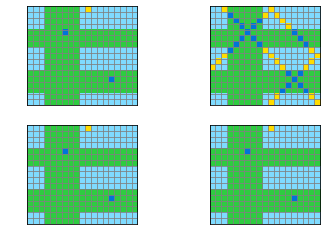

Average test loss: 111.99683380126953
Failed to solve task d07ae81c.json.
Attempted 212 out of 262 tasks.

Solved 13 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json']
Training model d22278a0.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


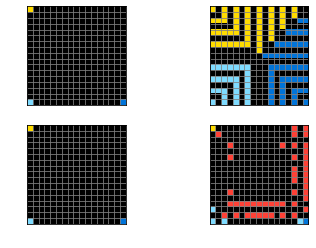

Average test loss: 252.6206512451172
Failed to solve task d22278a0.json.
Attempted 213 out of 262 tasks.

Solved 13 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json']
Training model d23f8c26.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


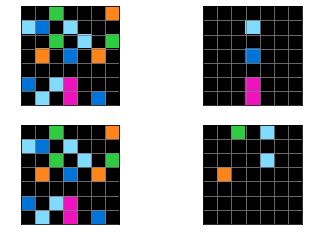

Average test loss: 26.260910034179688
Failed to solve task d23f8c26.json.
Attempted 214 out of 262 tasks.

Solved 13 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json']
Training model d2abd087.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


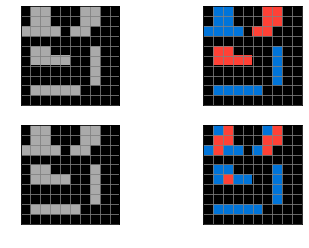

Average test loss: 22.926939010620117
Failed to solve task d2abd087.json.
Attempted 215 out of 262 tasks.

Solved 13 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json']
Training model d364b489.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


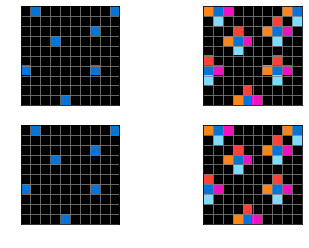

Average test loss: 28.577577590942383
Solved task d364b489.json successfully!
Attempted 216 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']
Training model d406998b.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


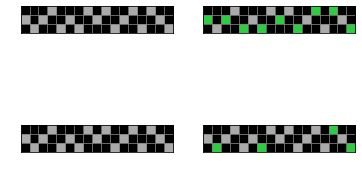

Average test loss: 12.362556457519531
Failed to solve task d406998b.json.
Attempted 217 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']
Training model d43fd935.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


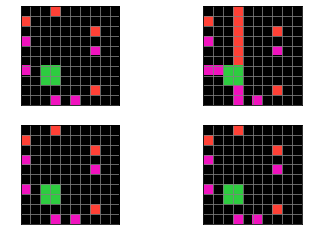

Average test loss: 22.338703155517578
Failed to solve task d43fd935.json.
Attempted 218 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']
Training model d4a91cb9.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


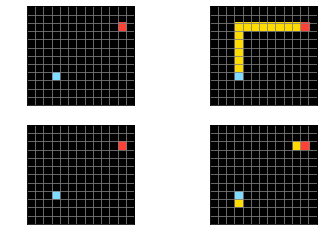

Average test loss: 31.04092025756836
Failed to solve task d4a91cb9.json.
Attempted 219 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']
Training model d4f3cd78.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


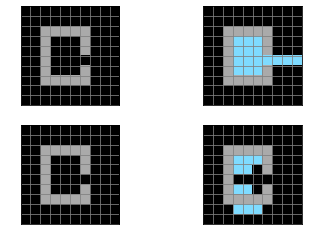

Average test loss: 33.836631774902344
Failed to solve task d4f3cd78.json.
Attempted 220 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']
Training model d511f180.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


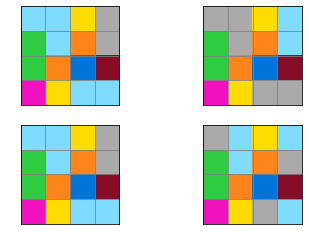

Average test loss: 10.140029907226562
Failed to solve task d511f180.json.
Attempted 221 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']
Training model d5d6de2d.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


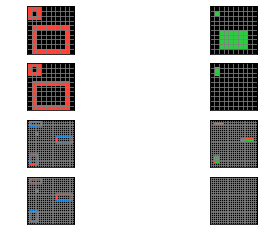

Average test loss: 66.69026184082031
Failed to solve task d5d6de2d.json.
Attempted 222 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']
Training model d687bc17.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


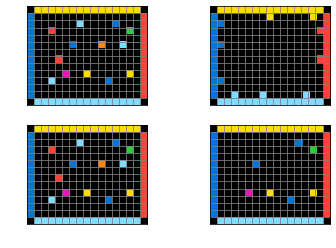

Average test loss: 46.75685119628906
Failed to solve task d687bc17.json.
Attempted 223 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']
Training model d6ad076f.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


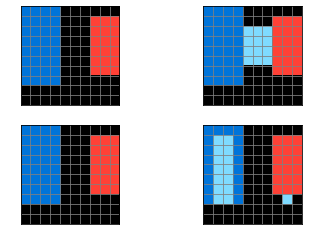

Average test loss: 53.66929244995117
Failed to solve task d6ad076f.json.
Attempted 224 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']
Training model d89b689b.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


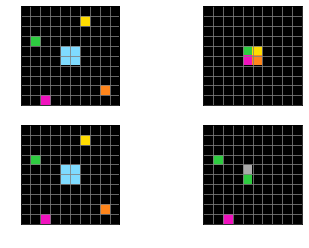

Average test loss: 10.783689498901367
Failed to solve task d89b689b.json.
Attempted 225 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']
Training model d8c310e9.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


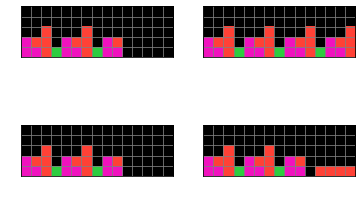

Average test loss: 28.319820404052734
Failed to solve task d8c310e9.json.
Attempted 226 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']
Training model d90796e8.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


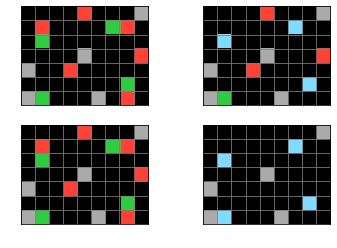

Average test loss: 12.13510513305664
Failed to solve task d90796e8.json.
Attempted 227 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']
Training model d9f24cd1.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


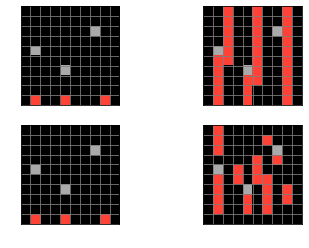

Average test loss: 45.1144905090332
Failed to solve task d9f24cd1.json.
Attempted 228 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']
Training model db3e9e38.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


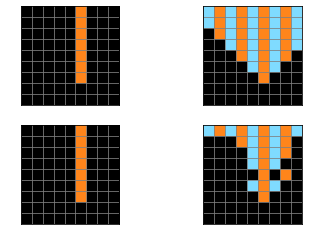

Average test loss: 48.0196533203125
Failed to solve task db3e9e38.json.
Attempted 229 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']
Training model db93a21d.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


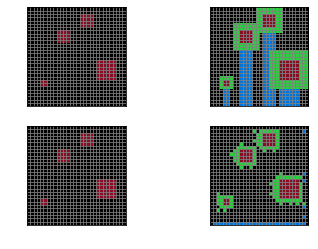

Average test loss: 486.4813232421875
Failed to solve task db93a21d.json.
Attempted 230 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']
Training model dbc1a6ce.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


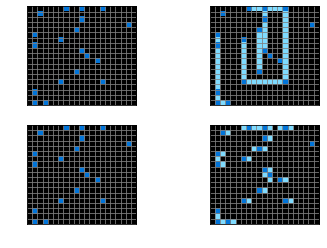

Average test loss: 109.21672821044922
Failed to solve task dbc1a6ce.json.
Attempted 231 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']
Training model dc1df850.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


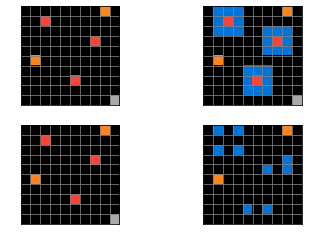

Average test loss: 67.08384704589844
Failed to solve task dc1df850.json.
Attempted 232 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']
Training model dc433765.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


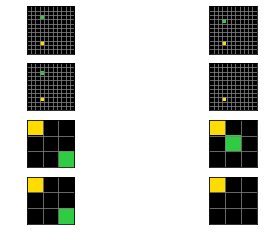

Average test loss: 3.833750009536743
Failed to solve task dc433765.json.
Attempted 233 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']
Training model ddf7fa4f.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


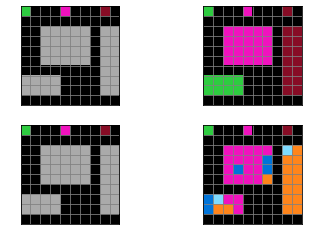

Average test loss: 47.73075866699219
Failed to solve task ddf7fa4f.json.
Attempted 234 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']
Training model ded97339.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


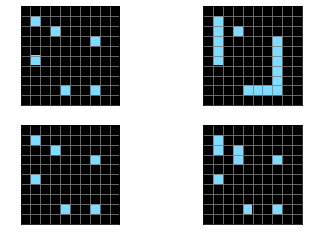

Average test loss: 20.076772689819336
Failed to solve task ded97339.json.
Attempted 235 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']
Training model e179c5f4.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


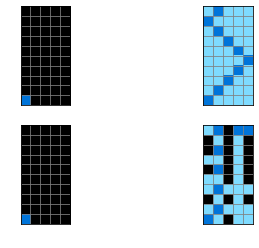

Average test loss: 66.9421615600586
Failed to solve task e179c5f4.json.
Attempted 236 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']
Training model e21d9049.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


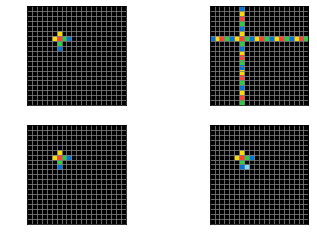

Average test loss: 82.61083984375
Failed to solve task e21d9049.json.
Attempted 237 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']
Training model e26a3af2.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


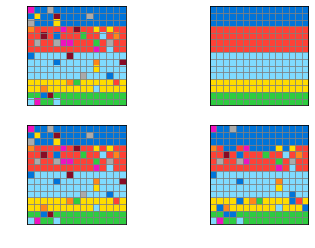

Average test loss: 91.83056640625
Failed to solve task e26a3af2.json.
Attempted 238 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']
Training model e40b9e2f.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


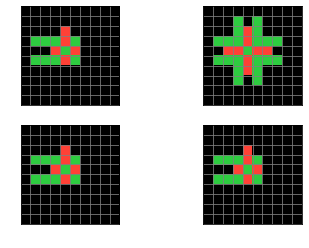

Average test loss: 43.066986083984375
Failed to solve task e40b9e2f.json.
Attempted 239 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']
Training model e48d4e1a.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


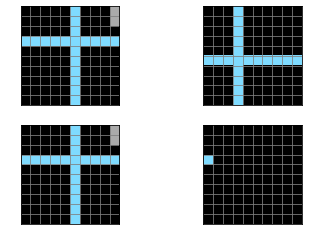

Average test loss: 66.25924682617188
Failed to solve task e48d4e1a.json.
Attempted 240 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']
Training model e5062a87.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


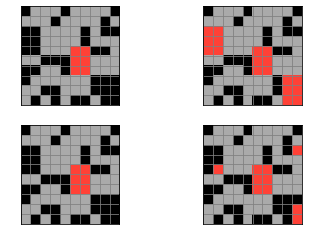

Average test loss: 24.754196166992188
Failed to solve task e5062a87.json.
Attempted 241 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']
Training model e509e548.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


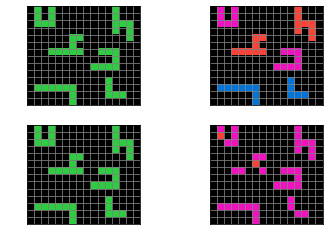

Average test loss: 44.346622467041016
Failed to solve task e509e548.json.
Attempted 242 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']
Training model e73095fd.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


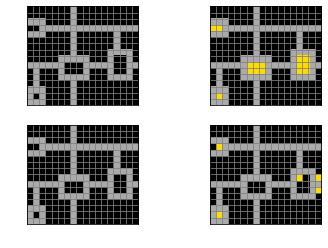

Average test loss: 40.61464309692383
Failed to solve task e73095fd.json.
Attempted 243 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']
Training model e76a88a6.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


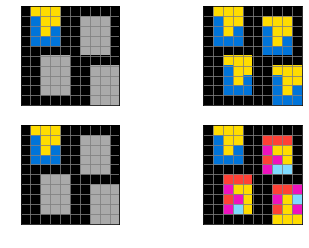

Average test loss: 58.07440948486328
Failed to solve task e76a88a6.json.
Attempted 244 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']
Training model e8593010.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


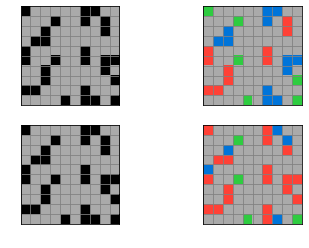

Average test loss: 24.16006088256836
Failed to solve task e8593010.json.
Attempted 245 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']
Training model e8dc4411.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


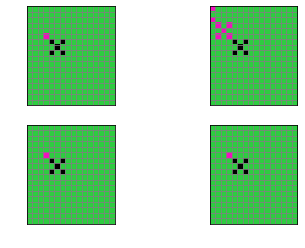

Average test loss: 104.43634796142578
Failed to solve task e8dc4411.json.
Attempted 246 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']
Training model e9614598.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


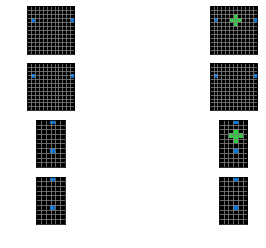

Average test loss: 13.268437385559082
Failed to solve task e9614598.json.
Attempted 247 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']
Training model e9afcf9a.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


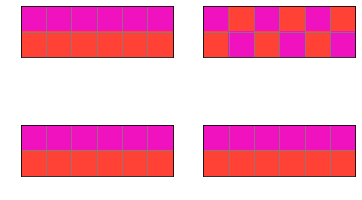

Average test loss: 16.139339447021484
Failed to solve task e9afcf9a.json.
Attempted 248 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']
Training model ea32f347.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


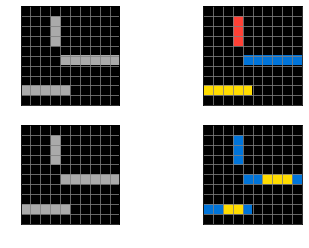

Average test loss: 16.938722610473633
Failed to solve task ea32f347.json.
Attempted 249 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']
Training model ea786f4a.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


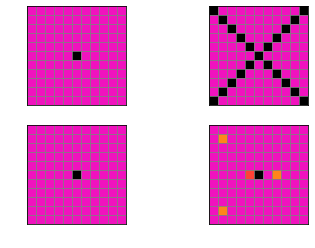

Average test loss: 99.9926528930664
Failed to solve task ea786f4a.json.
Attempted 250 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']
Training model ec883f72.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


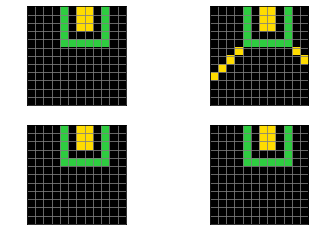

Average test loss: 21.46156120300293
Failed to solve task ec883f72.json.
Attempted 251 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']
Training model ecdecbb3.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


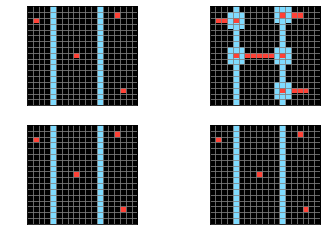

Average test loss: 87.74302673339844
Failed to solve task ecdecbb3.json.
Attempted 252 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']
Training model ed36ccf7.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


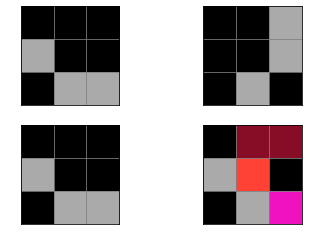

Average test loss: 16.72653579711914
Failed to solve task ed36ccf7.json.
Attempted 253 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']
Training model ef135b50.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


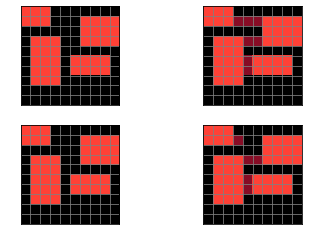

Average test loss: 14.602477073669434
Failed to solve task ef135b50.json.
Attempted 254 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']
Training model f15e1fac.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


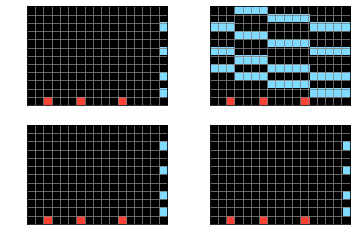

Average test loss: 101.8053970336914
Failed to solve task f15e1fac.json.
Attempted 255 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']
Training model f1cefba8.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


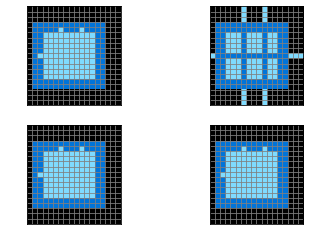

Average test loss: 129.59011840820312
Failed to solve task f1cefba8.json.
Attempted 256 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']
Training model f25ffba3.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


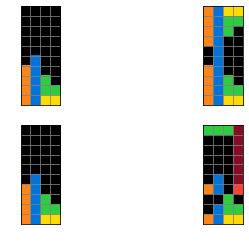

Average test loss: 43.73725891113281
Failed to solve task f25ffba3.json.
Attempted 257 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']
Training model f35d900a.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


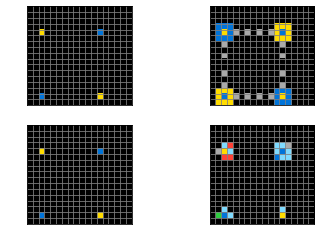

Average test loss: 93.60554504394531
Failed to solve task f35d900a.json.
Attempted 258 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']
Training model f76d97a5.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


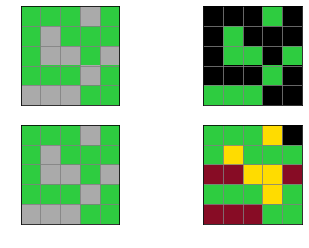

Average test loss: 57.45235824584961
Failed to solve task f76d97a5.json.
Attempted 259 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']
Training model f8a8fe49.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


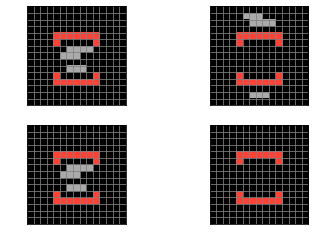

Average test loss: 34.10874557495117
Failed to solve task f8a8fe49.json.
Attempted 260 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']
Training model f8c80d96.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


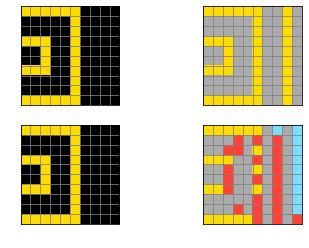

Average test loss: 77.91862487792969
Failed to solve task f8c80d96.json.
Attempted 261 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']
Training model fcc82909.json for a max of 30 epochs, with 64 iterations per epoch...

Evaluation result:


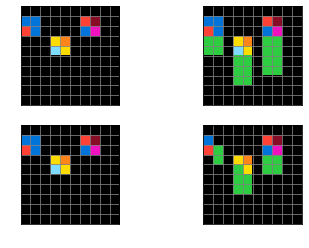

Average test loss: 37.62251663208008
Failed to solve task fcc82909.json.
Attempted 262 out of 262 tasks.

Solved 14 tasks so far:
['0ca9ddb6.json', '32597951.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', 'a699fb00.json', 'a79310a0.json', 'a9f96cdd.json', 'aedd82e4.json', 'b1948b0a.json', 'c8f0f002.json', 'd037b0a7.json', 'd364b489.json']


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
# This block runs the Neural Cellular Automata model on all training tasks

# Define the number of iterations of the cellular automata rule over the grid
# before updating weights (when training) or before calculating loss
# (when evaluating)
num_iterations = 64

optimizer = keras.optimizers.Adam(learning_rate=3e-4)
initializer = keras.initializers.RandomNormal(mean=0.0, stddev=1.5e-2, seed=1337)
max_epochs = 30

solved_count = 0
solved_tasks = []

for i, task in enumerate(vectorized_tasks):
    task_name = task_names[i]
    model = createAutomataModel(initializer, name=task_name)
    success = train(model, task, num_iterations, optimizer, max_epochs)
    evaluate(model, task["test_x"], task["test_y"], num_iterations, display_result=True)
    if success:
        print(f"Solved task {task_name} successfully!")
        solved_count += 1
        solved_tasks.append(task_name)
    else:
        print(f"Failed to solve task {task_name}.")
    print(f"Attempted {i+1} out of {len(vectorized_tasks)} tasks.\n")
    print(f"Solved {solved_count} tasks so far:")
    print(solved_tasks)

print(f"Finished. Solved {solved_count} out of {vectorized_tasks} tasks.")



In [ ]:
# This block runs the Neural Cellular Automata model on a single task

# Define the number of iterations of the cellular automata rule over the grid
# before updating weights (when training) or before calculating loss
# (when evaluating)
num_iterations = 64

optimizer = keras.optimizers.Adam(learning_rate=3e-4)
initializer = keras.initializers.RandomNormal(mean=0.0, stddev=1.5e-2, seed=1337)
max_epochs = 10000

# task = vectorized_tasks[0]
# task_name = task_names[0]

task_name = "3ac3eb23.json"
i = task_names.index(task_name)
task = vectorized_tasks[i]

model = createAutomataModel(initializer, name=task_name)

success = train(model, task, num_iterations, optimizer, max_epochs, display_result=True)
if success:
    print(f"Solved task {task_name} successfully!")
else:
    print(f"Failed to solve task {task_name}.")


In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
model.save("")

# Running a baseline convolutional model

Model: "Baseline Convolutional Model for ARC"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, None, 3 15712       input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, None, None, 6 51264       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, None, None, 1 73856       conv2d_3[0][0]                   
_______________________________________________________________

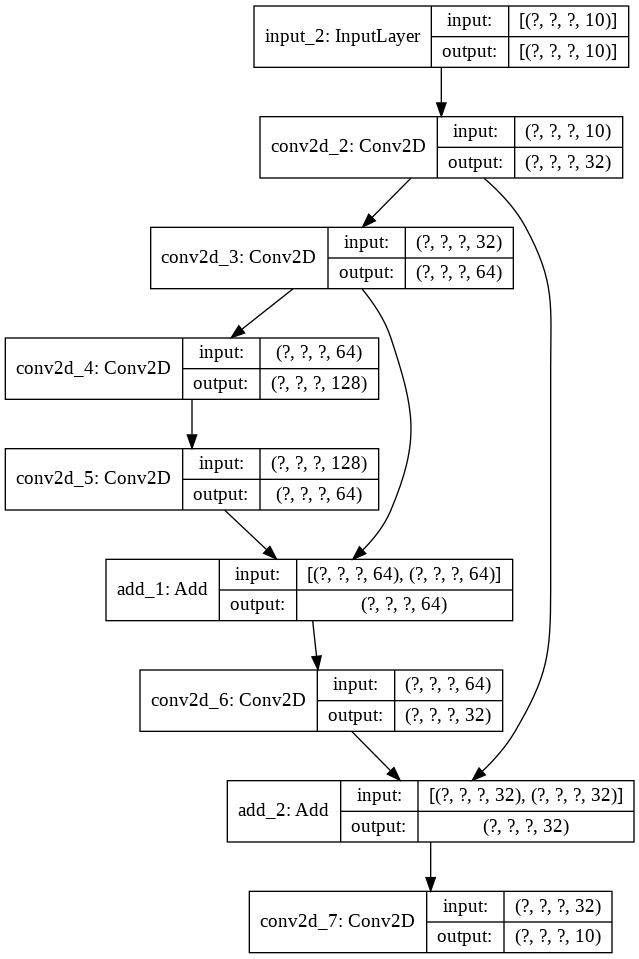

In [ ]:
def createBaselineModel(initializer, name="Baseline Convolutional Model for ARC"):
    input = keras.Input(shape=(None, None, 10))

    x = input
    filters = [32, 64, 128, 64, 32]
    kernel_sizes = [7, 5, 3, 5, 7]

    for i in range(3) :
        x = layers.Conv2D(
            filters=filters[i],
            kernel_size=kernel_sizes[i],
            padding="same",
            activation="relu",
            kernel_initializer=initializer,
            bias_initializer=initializer
        )(x)
        if i == 0:
            thirtytwo = x
        if i == 1:
            sixtyfour = x

    x = layers.Conv2D(
        filters=filters[3],
        kernel_size=kernel_sizes[3],
        padding="same",
        activation="relu",
        kernel_initializer=initializer,
        bias_initializer=initializer
    )(x)
    x = layers.Add()([x, sixtyfour])

    x = layers.Conv2D(
        filters=filters[4],
        kernel_size=kernel_sizes[4],
        padding="same",
        activation="relu",
        kernel_initializer=initializer,
        bias_initializer=initializer
    )(x)
    x = layers.add([x, thirtytwo])

    x = layers.Conv2D(
        filters=10,
        kernel_size=1,
        padding="valid",
        activation=None,
        kernel_initializer=initializer,
        bias_initializer=initializer
    )(x)

    return keras.Model(inputs=input, outputs=x, name=name)

# Create a model just to display a summary (it won't be used)
initializer = keras.initializers.RandomNormal(mean=0.0, stddev=3e-3, seed=1337)
model = createBaselineModel(initializer)
model.summary()
display(keras.utils.plot_model(model, show_shapes=True))

Training model 00d62c1b.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


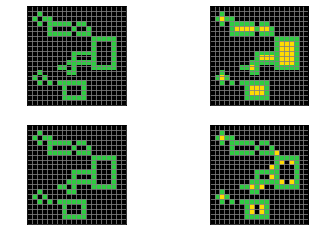

Average test loss: 57.00337600708008
Failed to solve task 00d62c1b.json.
Attempted 1 out of 262 tasks.

Solved 0 tasks so far:
[]
Training model 025d127b.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


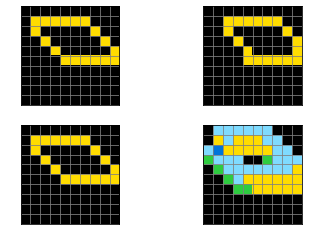

Average test loss: 435.91314697265625
Failed to solve task 025d127b.json.
Attempted 2 out of 262 tasks.

Solved 0 tasks so far:
[]
Training model 045e512c.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


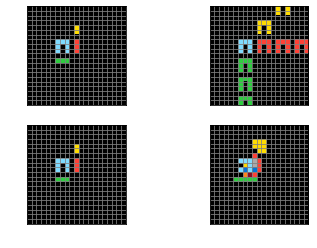

Average test loss: 188.0378875732422
Failed to solve task 045e512c.json.
Attempted 3 out of 262 tasks.

Solved 0 tasks so far:
[]
Training model 05269061.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


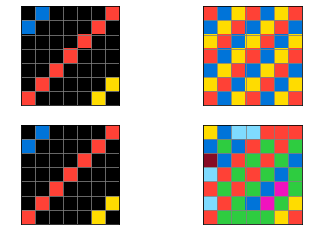

Average test loss: 120.52665710449219
Failed to solve task 05269061.json.
Attempted 4 out of 262 tasks.

Solved 0 tasks so far:
[]
Training model 05f2a901.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


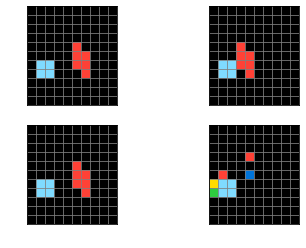

Average test loss: 25.46756362915039
Failed to solve task 05f2a901.json.
Attempted 5 out of 262 tasks.

Solved 0 tasks so far:
[]
Training model 06df4c85.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


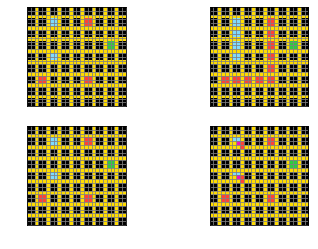

Average test loss: 141.79400634765625
Failed to solve task 06df4c85.json.
Attempted 6 out of 262 tasks.

Solved 0 tasks so far:
[]
Training model 08ed6ac7.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


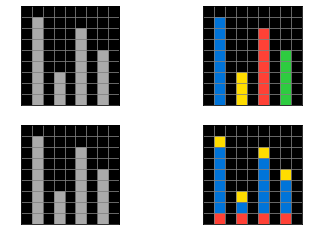

Average test loss: 16.5195369720459
Failed to solve task 08ed6ac7.json.
Attempted 7 out of 262 tasks.

Solved 0 tasks so far:
[]
Training model 09629e4f.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


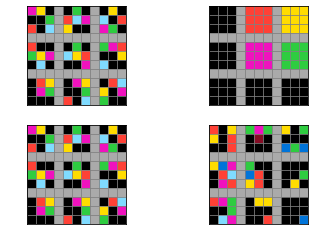

Average test loss: 147.82545471191406
Failed to solve task 09629e4f.json.
Attempted 8 out of 262 tasks.

Solved 0 tasks so far:
[]
Training model 0962bcdd.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


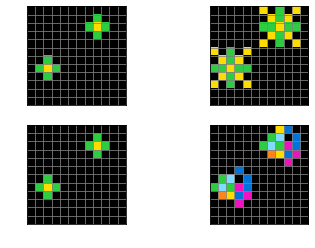

Average test loss: 258.2238464355469
Failed to solve task 0962bcdd.json.
Attempted 9 out of 262 tasks.

Solved 0 tasks so far:
[]
Training model 0a938d79.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


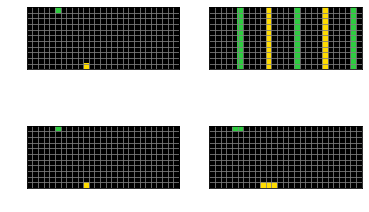

Average test loss: 129.10035705566406
Failed to solve task 0a938d79.json.
Attempted 10 out of 262 tasks.

Solved 0 tasks so far:
[]
Training model 0ca9ddb6.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


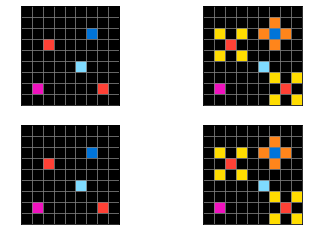

Average test loss: 31.55839729309082
Solved task 0ca9ddb6.json successfully!
Attempted 11 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 0d3d703e.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


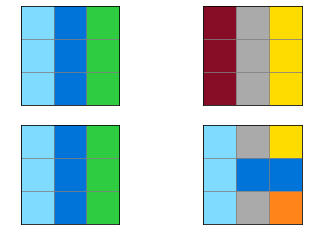

Average test loss: 44.602783203125
Failed to solve task 0d3d703e.json.
Attempted 12 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 0dfd9992.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


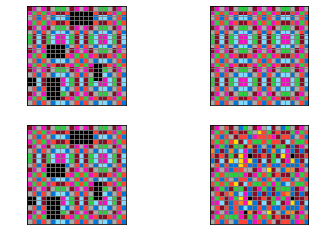

Average test loss: 1602.80712890625
Failed to solve task 0dfd9992.json.
Attempted 13 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 0e206a2e.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


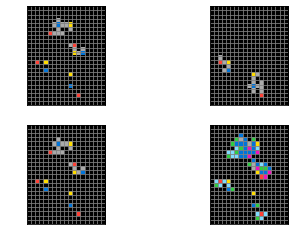

Average test loss: 380.48382568359375
Failed to solve task 0e206a2e.json.
Attempted 14 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 11852cab.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


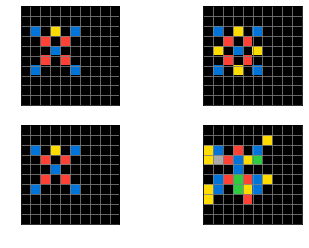

Average test loss: 72.61998748779297
Failed to solve task 11852cab.json.
Attempted 15 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 150deff5.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


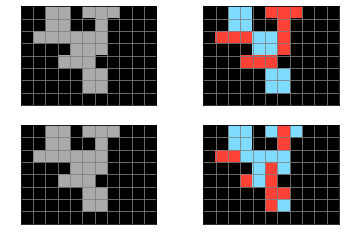

Average test loss: 23.506107330322266
Failed to solve task 150deff5.json.
Attempted 16 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 178fcbfb.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


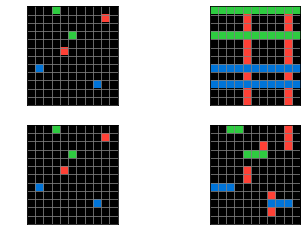

Average test loss: 83.01834106445312
Failed to solve task 178fcbfb.json.
Attempted 17 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 1a07d186.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


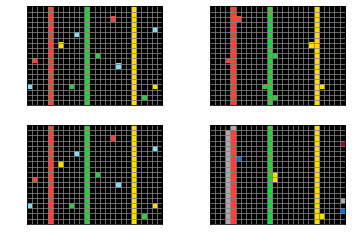

Average test loss: 121.25238037109375
Failed to solve task 1a07d186.json.
Attempted 18 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 1b60fb0c.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


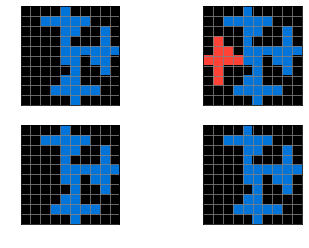

Average test loss: 15.267613410949707
Failed to solve task 1b60fb0c.json.
Attempted 19 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 1bfc4729.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


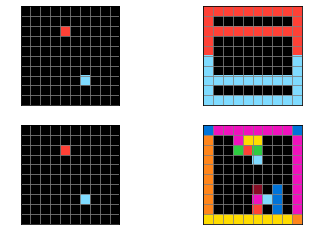

Average test loss: 132.8255615234375
Failed to solve task 1bfc4729.json.
Attempted 20 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 1caeab9d.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


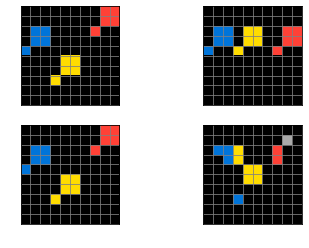

Average test loss: 59.62752151489258
Failed to solve task 1caeab9d.json.
Attempted 21 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 1e0a9b12.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


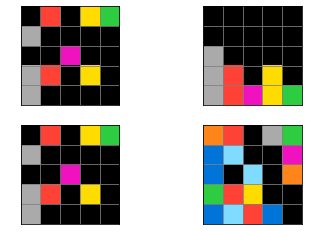

Average test loss: 96.03857421875
Failed to solve task 1e0a9b12.json.
Attempted 22 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 1e32b0e9.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


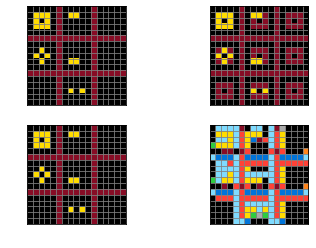

Average test loss: 2457.230712890625
Failed to solve task 1e32b0e9.json.
Attempted 23 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 1f0c79e5.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


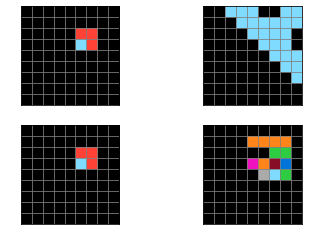

Average test loss: 76.70297241210938
Failed to solve task 1f0c79e5.json.
Attempted 24 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 1f642eb9.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


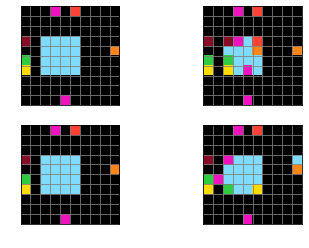

Average test loss: 56.95539855957031
Failed to solve task 1f642eb9.json.
Attempted 25 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 1f876c06.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


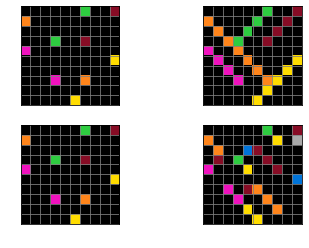

Average test loss: 55.93125915527344
Failed to solve task 1f876c06.json.
Attempted 26 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 2204b7a8.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


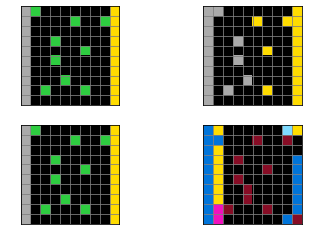

Average test loss: 215.51463317871094
Failed to solve task 2204b7a8.json.
Attempted 27 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 22168020.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


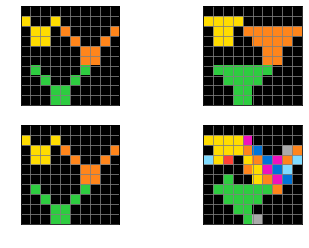

Average test loss: 202.25498962402344
Failed to solve task 22168020.json.
Attempted 28 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 22233c11.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


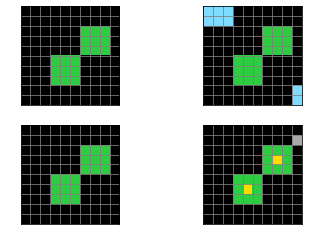

Average test loss: 54.57480239868164
Failed to solve task 22233c11.json.
Attempted 29 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 2281f1f4.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


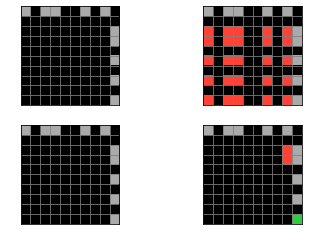

Average test loss: 38.77765655517578
Failed to solve task 2281f1f4.json.
Attempted 30 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 228f6490.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


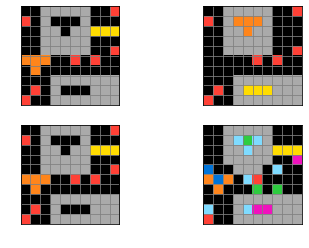

Average test loss: 98.1298828125
Failed to solve task 228f6490.json.
Attempted 31 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 22eb0ac0.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


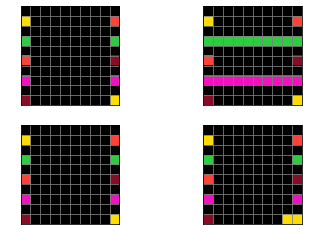

Average test loss: 52.61057662963867
Failed to solve task 22eb0ac0.json.
Attempted 32 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 23581191.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


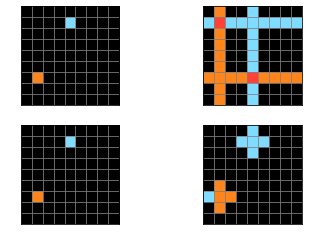

Average test loss: 36.28540802001953
Failed to solve task 23581191.json.
Attempted 33 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 253bf280.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


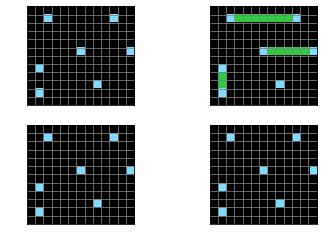

Average test loss: 23.01465606689453
Failed to solve task 253bf280.json.
Attempted 34 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 25d487eb.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


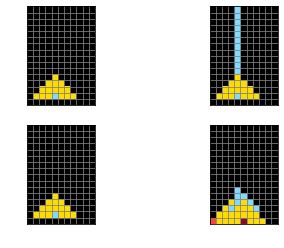

Average test loss: 522.4212646484375
Failed to solve task 25d487eb.json.
Attempted 35 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 25d8a9c8.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


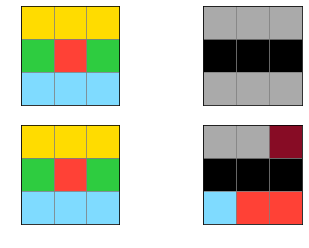

Average test loss: 50.7613525390625
Failed to solve task 25d8a9c8.json.
Attempted 36 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 25ff71a9.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


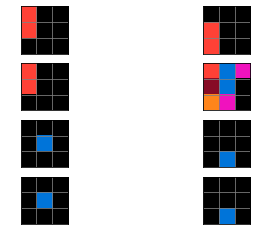

Average test loss: 12.747856140136719
Failed to solve task 25ff71a9.json.
Attempted 37 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 264363fd.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


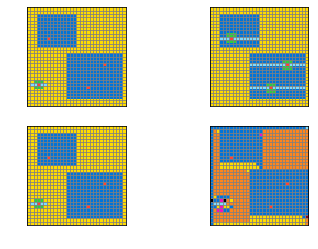

Average test loss: 17168.8984375
Failed to solve task 264363fd.json.
Attempted 38 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 272f95fa.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


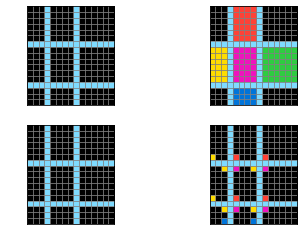

Average test loss: 149.66954040527344
Failed to solve task 272f95fa.json.
Attempted 39 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 28e73c20.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


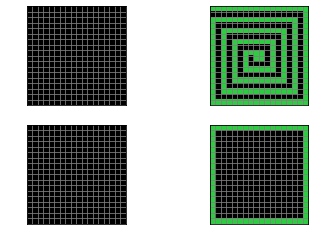

Average test loss: 128.84963989257812
Failed to solve task 28e73c20.json.
Attempted 40 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 29623171.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


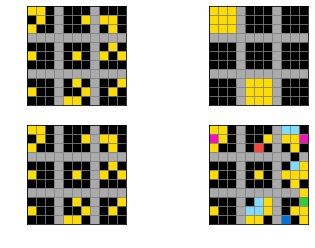

Average test loss: 384.3401184082031
Failed to solve task 29623171.json.
Attempted 41 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 29c11459.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


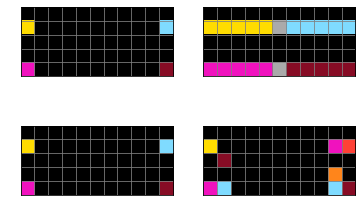

Average test loss: 85.25687408447266
Failed to solve task 29c11459.json.
Attempted 42 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 29ec7d0e.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


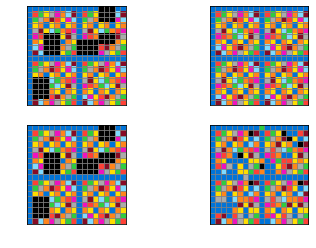

Average test loss: 401.4614562988281
Failed to solve task 29ec7d0e.json.
Attempted 43 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 2bcee788.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


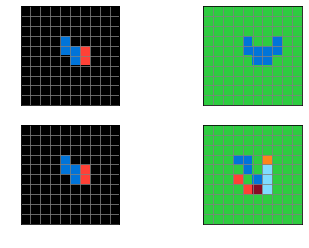

Average test loss: 103.61731719970703
Failed to solve task 2bcee788.json.
Attempted 44 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 2bee17df.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


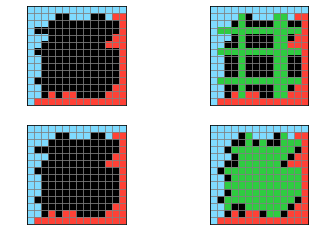

Average test loss: 106.01010131835938
Failed to solve task 2bee17df.json.
Attempted 45 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 2c608aff.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


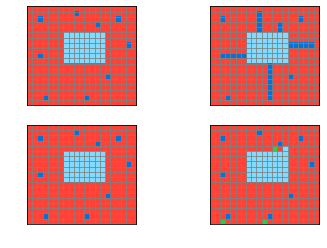

Average test loss: 167.39134216308594
Failed to solve task 2c608aff.json.
Attempted 46 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 2dd70a9a.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


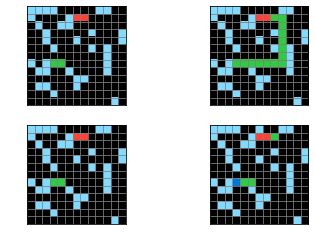

Average test loss: 34.1690559387207
Failed to solve task 2dd70a9a.json.
Attempted 47 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 31aa019c.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


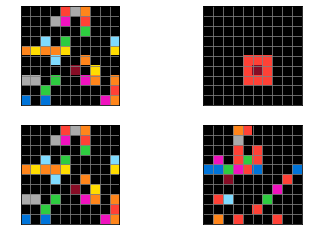

Average test loss: 138.36285400390625
Failed to solve task 31aa019c.json.
Attempted 48 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 321b1fc6.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


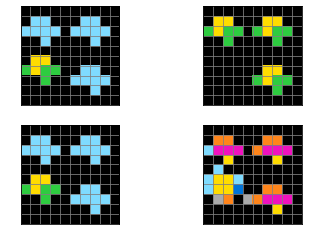

Average test loss: 167.37789916992188
Failed to solve task 321b1fc6.json.
Attempted 49 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 32597951.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


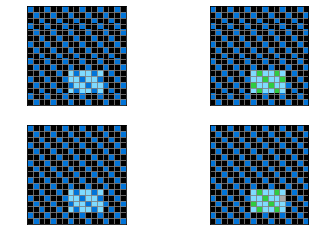

Average test loss: 41.833412170410156
Failed to solve task 32597951.json.
Attempted 50 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 3345333e.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


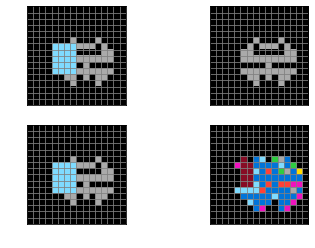

Average test loss: 1214.115234375
Failed to solve task 3345333e.json.
Attempted 51 out of 262 tasks.

Solved 1 tasks so far:
['0ca9ddb6.json']
Training model 3618c87e.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


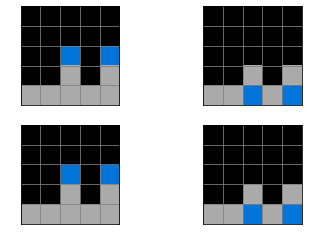

Average test loss: 9.698090553283691
Solved task 3618c87e.json successfully!
Attempted 52 out of 262 tasks.

Solved 2 tasks so far:
['0ca9ddb6.json', '3618c87e.json']
Training model 3631a71a.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


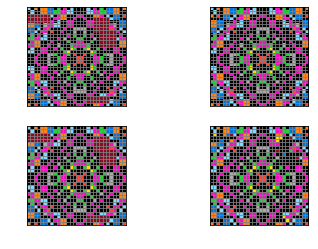

Average test loss: 112.14024353027344
Failed to solve task 3631a71a.json.
Attempted 53 out of 262 tasks.

Solved 2 tasks so far:
['0ca9ddb6.json', '3618c87e.json']
Training model 363442ee.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


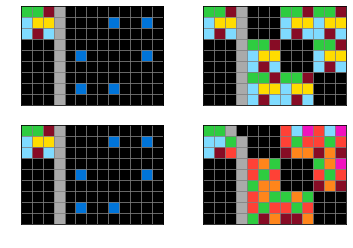

Average test loss: 152.39181518554688
Failed to solve task 363442ee.json.
Attempted 54 out of 262 tasks.

Solved 2 tasks so far:
['0ca9ddb6.json', '3618c87e.json']
Training model 36d67576.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


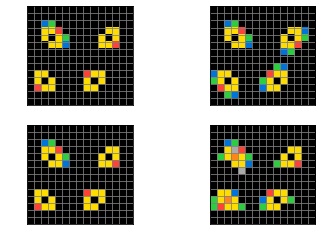

Average test loss: 68.57633972167969
Failed to solve task 36d67576.json.
Attempted 55 out of 262 tasks.

Solved 2 tasks so far:
['0ca9ddb6.json', '3618c87e.json']
Training model 36fdfd69.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


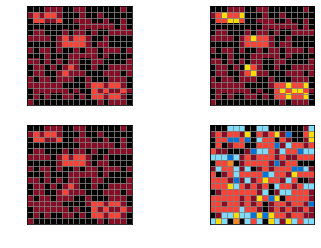

Average test loss: 2493.624755859375
Failed to solve task 36fdfd69.json.
Attempted 56 out of 262 tasks.

Solved 2 tasks so far:
['0ca9ddb6.json', '3618c87e.json']
Training model 3906de3d.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


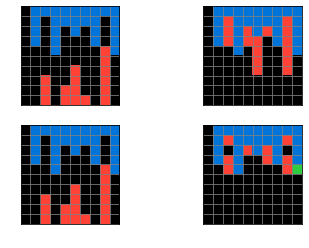

Average test loss: 35.76725387573242
Failed to solve task 3906de3d.json.
Attempted 57 out of 262 tasks.

Solved 2 tasks so far:
['0ca9ddb6.json', '3618c87e.json']
Training model 39e1d7f9.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


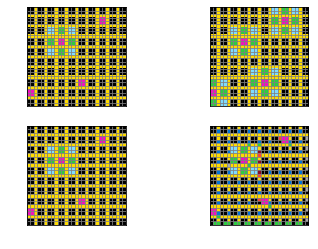

Average test loss: 1453.1282958984375
Failed to solve task 39e1d7f9.json.
Attempted 58 out of 262 tasks.

Solved 2 tasks so far:
['0ca9ddb6.json', '3618c87e.json']
Training model 3aa6fb7a.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


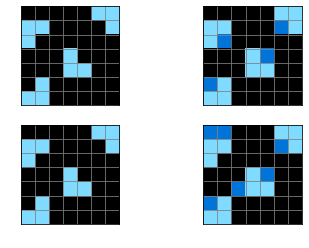

Average test loss: 14.542899131774902
Failed to solve task 3aa6fb7a.json.
Attempted 59 out of 262 tasks.

Solved 2 tasks so far:
['0ca9ddb6.json', '3618c87e.json']
Training model 3ac3eb23.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


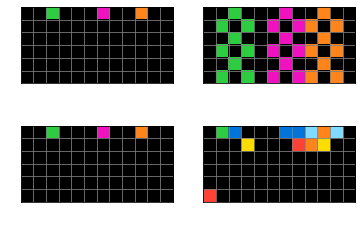

Average test loss: 89.64474487304688
Failed to solve task 3ac3eb23.json.
Attempted 60 out of 262 tasks.

Solved 2 tasks so far:
['0ca9ddb6.json', '3618c87e.json']
Training model 3bd67248.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


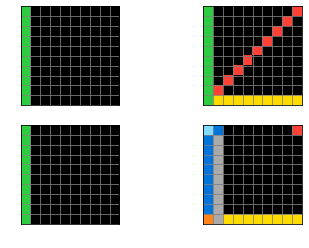

Average test loss: 231.16119384765625
Failed to solve task 3bd67248.json.
Attempted 61 out of 262 tasks.

Solved 2 tasks so far:
['0ca9ddb6.json', '3618c87e.json']
Training model 3bdb4ada.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


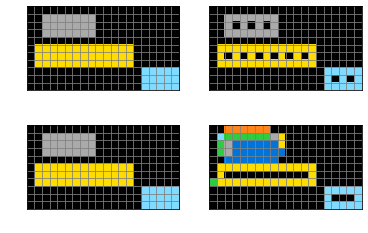

Average test loss: 521.392578125
Failed to solve task 3bdb4ada.json.
Attempted 62 out of 262 tasks.

Solved 2 tasks so far:
['0ca9ddb6.json', '3618c87e.json']
Training model 3befdf3e.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


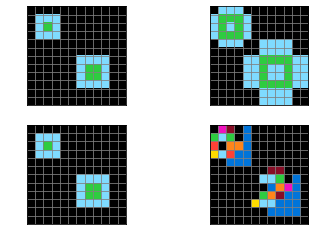

Average test loss: 588.193603515625
Failed to solve task 3befdf3e.json.
Attempted 63 out of 262 tasks.

Solved 2 tasks so far:
['0ca9ddb6.json', '3618c87e.json']
Training model 3c9b0459.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


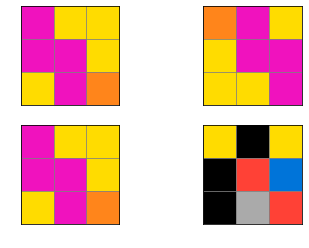

Average test loss: 88.27743530273438
Failed to solve task 3c9b0459.json.
Attempted 64 out of 262 tasks.

Solved 2 tasks so far:
['0ca9ddb6.json', '3618c87e.json']
Training model 3e980e27.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


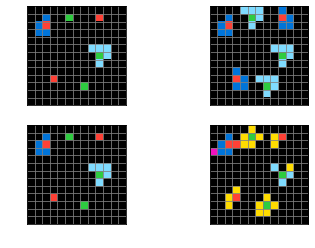

Average test loss: 78.82573699951172
Failed to solve task 3e980e27.json.
Attempted 65 out of 262 tasks.

Solved 2 tasks so far:
['0ca9ddb6.json', '3618c87e.json']
Training model 3eda0437.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


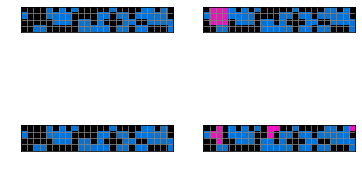

Average test loss: 18.733108520507812
Failed to solve task 3eda0437.json.
Attempted 66 out of 262 tasks.

Solved 2 tasks so far:
['0ca9ddb6.json', '3618c87e.json']
Training model 40853293.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


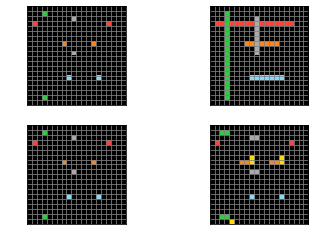

Average test loss: 100.19986724853516
Failed to solve task 40853293.json.
Attempted 67 out of 262 tasks.

Solved 2 tasks so far:
['0ca9ddb6.json', '3618c87e.json']
Training model 4093f84a.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


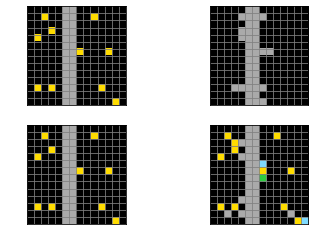

Average test loss: 186.27088928222656
Failed to solve task 4093f84a.json.
Attempted 68 out of 262 tasks.

Solved 2 tasks so far:
['0ca9ddb6.json', '3618c87e.json']
Training model 41e4d17e.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


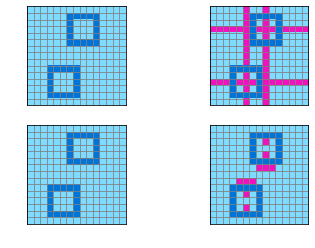

Average test loss: 64.46500396728516
Failed to solve task 41e4d17e.json.
Attempted 69 out of 262 tasks.

Solved 2 tasks so far:
['0ca9ddb6.json', '3618c87e.json']
Training model 4258a5f9.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


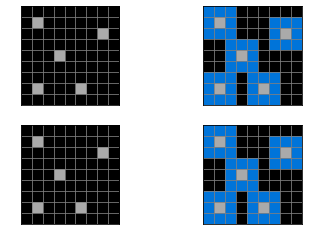

Average test loss: 31.9376220703125
Solved task 4258a5f9.json successfully!
Attempted 70 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json']
Training model 42a50994.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


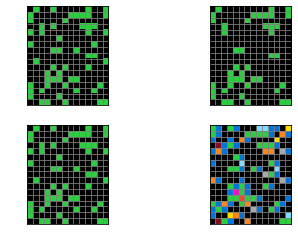

Average test loss: 729.3385620117188
Failed to solve task 42a50994.json.
Attempted 71 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json']
Training model 4347f46a.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


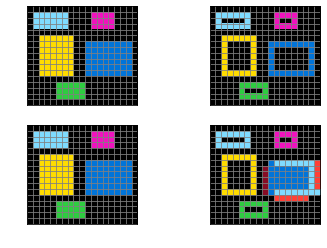

Average test loss: 1074.736572265625
Failed to solve task 4347f46a.json.
Attempted 72 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json']
Training model 444801d8.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


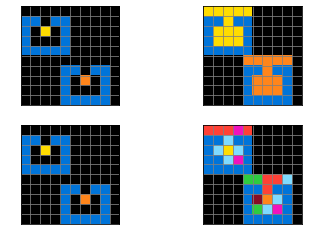

Average test loss: 82.73062133789062
Failed to solve task 444801d8.json.
Attempted 73 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json']
Training model 447fd412.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


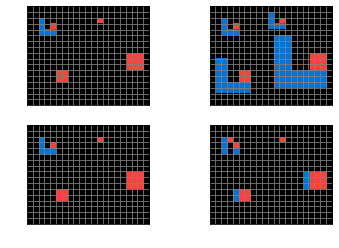

Average test loss: 128.73336791992188
Failed to solve task 447fd412.json.
Attempted 74 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json']
Training model 44d8ac46.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


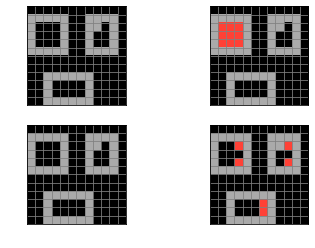

Average test loss: 18.50766372680664
Failed to solve task 44d8ac46.json.
Attempted 75 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json']
Training model 4612dd53.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


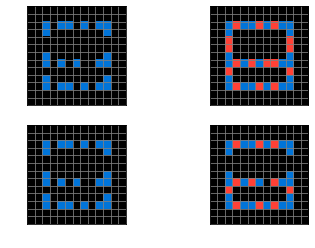

Average test loss: 11.410283088684082
Failed to solve task 4612dd53.json.
Attempted 76 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json']
Training model 484b58aa.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


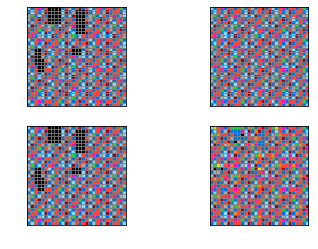

Average test loss: 1959.1953125
Failed to solve task 484b58aa.json.
Attempted 77 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json']
Training model 4938f0c2.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


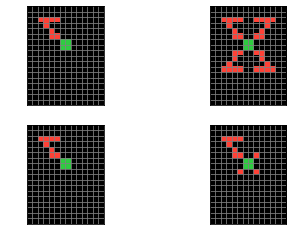

Average test loss: 41.87029266357422
Failed to solve task 4938f0c2.json.
Attempted 78 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json']
Training model 496994bd.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


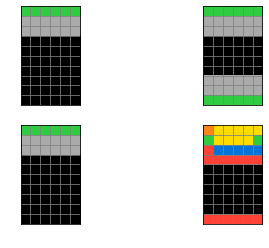

Average test loss: 357.11700439453125
Failed to solve task 496994bd.json.
Attempted 79 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json']
Training model 4c5c2cf0.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


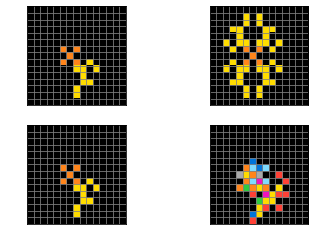

Average test loss: 213.7272491455078
Failed to solve task 4c5c2cf0.json.
Attempted 80 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json']
Training model 50846271.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


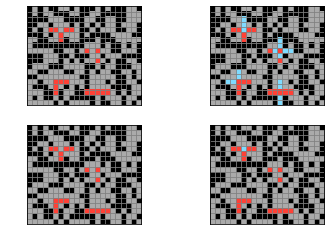

Average test loss: 39.33591842651367
Failed to solve task 50846271.json.
Attempted 81 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json']
Training model 508bd3b6.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


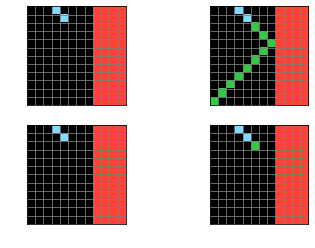

Average test loss: 24.92801856994629
Failed to solve task 508bd3b6.json.
Attempted 82 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json']
Training model 50cb2852.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


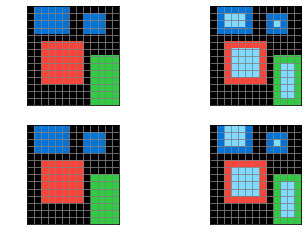

Average test loss: 25.471839904785156
Failed to solve task 50cb2852.json.
Attempted 83 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json']
Training model 5168d44c.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


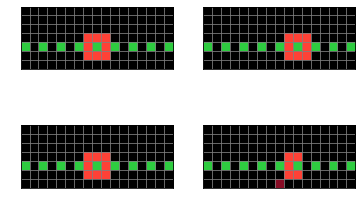

Average test loss: 18.048660278320312
Failed to solve task 5168d44c.json.
Attempted 84 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json']
Training model 543a7ed5.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


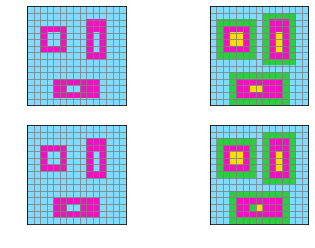

Average test loss: 8.790990829467773
Failed to solve task 543a7ed5.json.
Attempted 85 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json']
Training model 54d82841.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


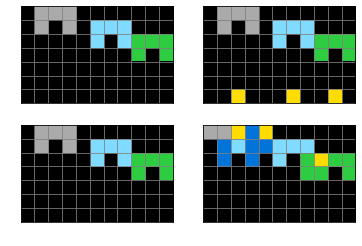

Average test loss: 121.84542083740234
Failed to solve task 54d82841.json.
Attempted 86 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json']
Training model 54d9e175.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


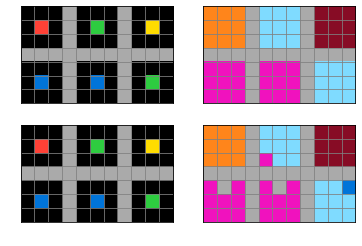

Average test loss: 18.019725799560547
Failed to solve task 54d9e175.json.
Attempted 87 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json']
Training model 5521c0d9.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


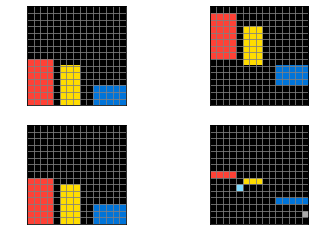

Average test loss: 158.67205810546875
Failed to solve task 5521c0d9.json.
Attempted 88 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json']
Training model 5582e5ca.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


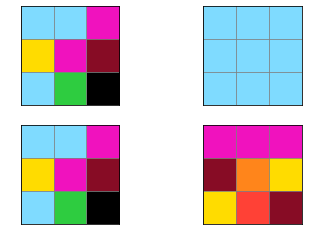

Average test loss: 44.52195358276367
Failed to solve task 5582e5ca.json.
Attempted 89 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json']
Training model 56dc2b01.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


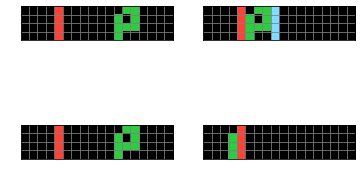

Average test loss: 36.299110412597656
Failed to solve task 56dc2b01.json.
Attempted 90 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json']
Training model 56ff96f3.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


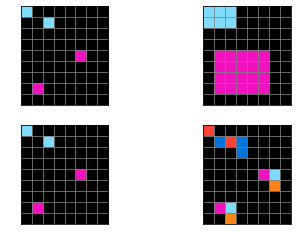

Average test loss: 130.0468292236328
Failed to solve task 56ff96f3.json.
Attempted 91 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json']
Training model 57aa92db.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


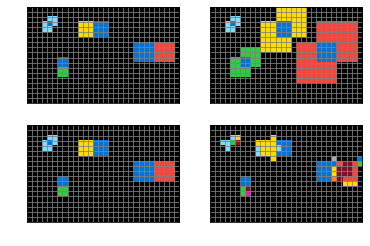

Average test loss: 518.3663940429688
Failed to solve task 57aa92db.json.
Attempted 92 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json']
Training model 5c0a986e.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


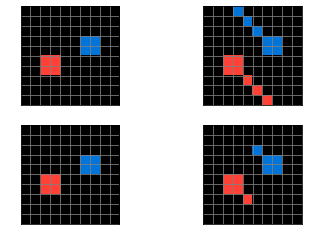

Average test loss: 8.978730201721191
Failed to solve task 5c0a986e.json.
Attempted 93 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json']
Training model 5c2c9af4.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


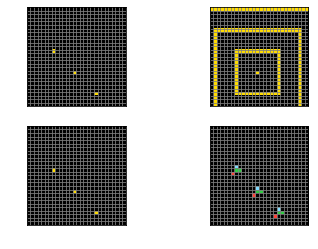

Average test loss: 376.030029296875
Failed to solve task 5c2c9af4.json.
Attempted 94 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json']
Training model 60b61512.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


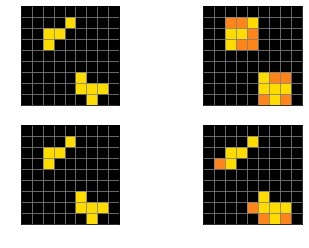

Average test loss: 24.649337768554688
Failed to solve task 60b61512.json.
Attempted 95 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json']
Training model 6150a2bd.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


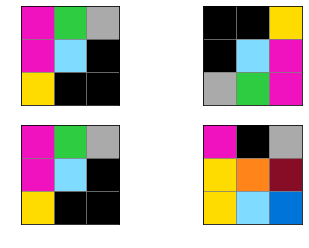

Average test loss: 96.36405944824219
Failed to solve task 6150a2bd.json.
Attempted 96 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json']
Training model 623ea044.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


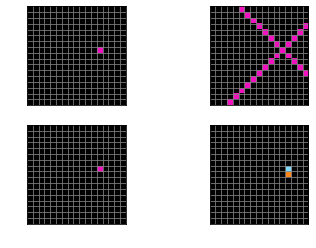

Average test loss: 73.86540222167969
Failed to solve task 623ea044.json.
Attempted 97 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json']
Training model 63613498.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


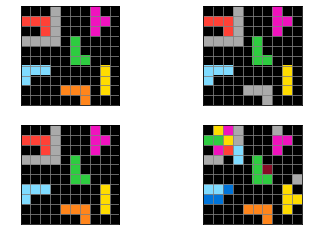

Average test loss: 127.00888061523438
Failed to solve task 63613498.json.
Attempted 98 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json']
Training model 6455b5f5.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


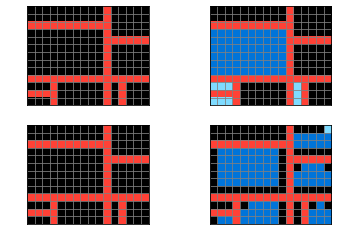

Average test loss: 105.1553955078125
Failed to solve task 6455b5f5.json.
Attempted 99 out of 262 tasks.

Solved 3 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json']
Training model 67385a82.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


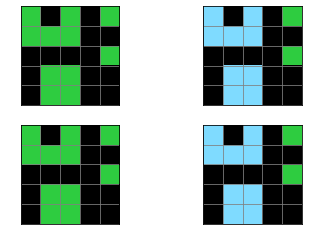

Average test loss: 20.631202697753906
Solved task 67385a82.json successfully!
Attempted 100 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json']
Training model 673ef223.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


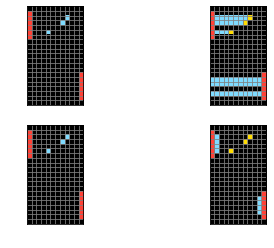

Average test loss: 75.15326690673828
Failed to solve task 673ef223.json.
Attempted 101 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json']
Training model 67a3c6ac.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


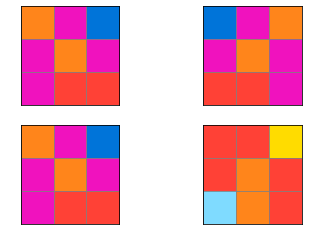

Average test loss: 25.376924514770508
Failed to solve task 67a3c6ac.json.
Attempted 102 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json']
Training model 67a423a3.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


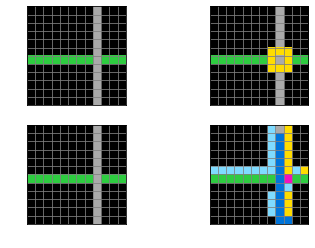

Average test loss: 332.40875244140625
Failed to solve task 67a423a3.json.
Attempted 103 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json']
Training model 6855a6e4.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


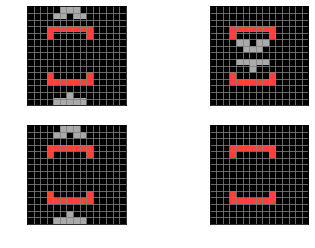

Average test loss: 45.02881622314453
Failed to solve task 6855a6e4.json.
Attempted 104 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json']
Training model 68b16354.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


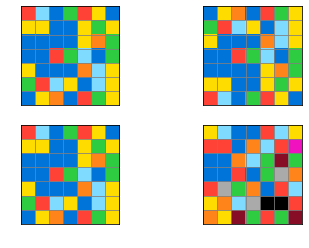

Average test loss: 211.2303009033203
Failed to solve task 68b16354.json.
Attempted 105 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json']
Training model 694f12f3.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


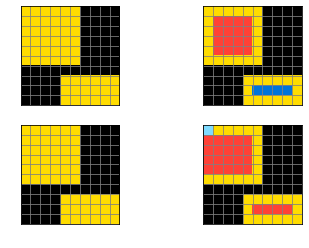

Average test loss: 30.894512176513672
Failed to solve task 694f12f3.json.
Attempted 106 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json']
Training model 6a1e5592.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


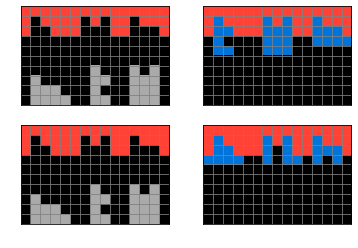

Average test loss: 28.666534423828125
Failed to solve task 6a1e5592.json.
Attempted 107 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json']
Training model 6aa20dc0.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


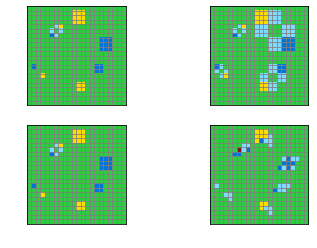

Average test loss: 1871.22314453125
Failed to solve task 6aa20dc0.json.
Attempted 108 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json']
Training model 6c434453.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


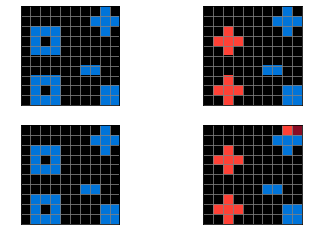

Average test loss: 10.425729751586914
Failed to solve task 6c434453.json.
Attempted 109 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json']
Training model 6cdd2623.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


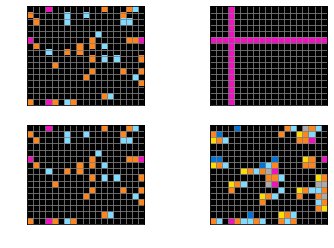

Average test loss: 495.17083740234375
Failed to solve task 6cdd2623.json.
Attempted 110 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json']
Training model 6cf79266.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


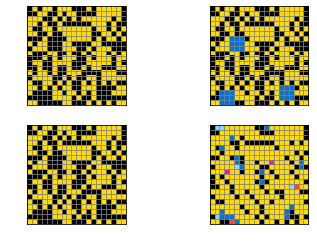

Average test loss: 3298.938720703125
Failed to solve task 6cf79266.json.
Attempted 111 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json']
Training model 6d0160f0.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


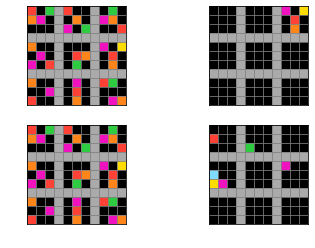

Average test loss: 89.14326477050781
Failed to solve task 6d0160f0.json.
Attempted 112 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json']
Training model 6d58a25d.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


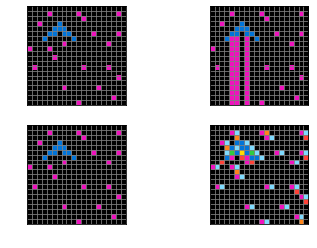

Average test loss: 672.7840576171875
Failed to solve task 6d58a25d.json.
Attempted 113 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json']
Training model 6d75e8bb.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


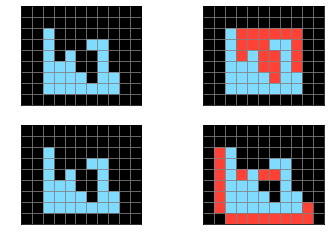

Average test loss: 53.58078384399414
Failed to solve task 6d75e8bb.json.
Attempted 114 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json']
Training model 6e02f1e3.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


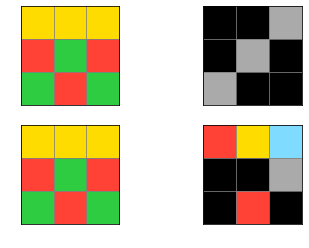

Average test loss: 33.70733642578125
Failed to solve task 6e02f1e3.json.
Attempted 115 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json']
Training model 6e19193c.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


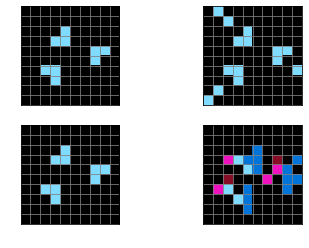

Average test loss: 210.3471221923828
Failed to solve task 6e19193c.json.
Attempted 116 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json']
Training model 6e82a1ae.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


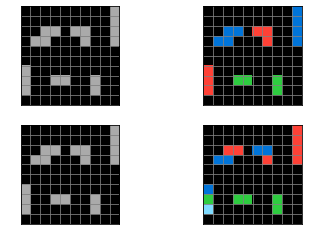

Average test loss: 21.69816780090332
Failed to solve task 6e82a1ae.json.
Attempted 117 out of 262 tasks.

Solved 4 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json']
Training model 6f8cd79b.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


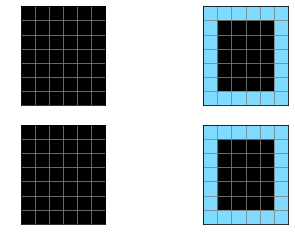

Average test loss: 36.562477111816406
Solved task 6f8cd79b.json successfully!
Attempted 118 out of 262 tasks.

Solved 5 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 72322fa7.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


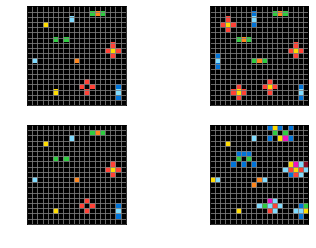

Average test loss: 185.06097412109375
Failed to solve task 72322fa7.json.
Attempted 119 out of 262 tasks.

Solved 5 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 73251a56.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


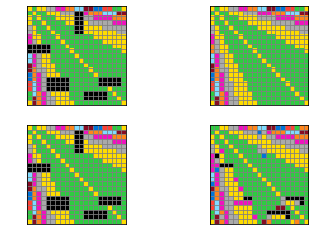

Average test loss: 385.8435363769531
Failed to solve task 73251a56.json.
Attempted 120 out of 262 tasks.

Solved 5 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 7447852a.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


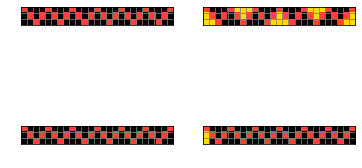

Average test loss: 25.19002914428711
Failed to solve task 7447852a.json.
Attempted 121 out of 262 tasks.

Solved 5 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 74dd1130.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


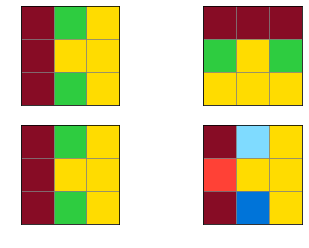

Average test loss: 135.92608642578125
Failed to solve task 74dd1130.json.
Attempted 122 out of 262 tasks.

Solved 5 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 760b3cac.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


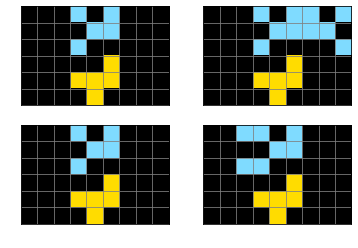

Average test loss: 12.204972267150879
Failed to solve task 760b3cac.json.
Attempted 123 out of 262 tasks.

Solved 5 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 776ffc46.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


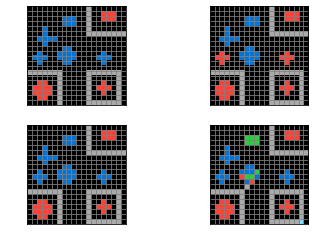

Average test loss: 71.70289611816406
Failed to solve task 776ffc46.json.
Attempted 124 out of 262 tasks.

Solved 5 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 794b24be.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


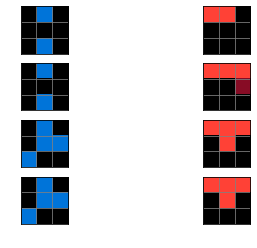

Average test loss: 5.4599409103393555
Failed to solve task 794b24be.json.
Attempted 125 out of 262 tasks.

Solved 5 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 7b6016b9.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


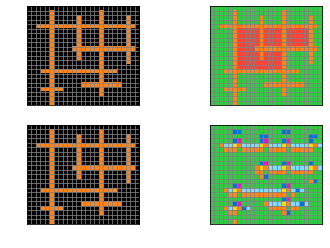

Average test loss: 2409.31103515625
Failed to solve task 7b6016b9.json.
Attempted 126 out of 262 tasks.

Solved 5 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 7ddcd7ec.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


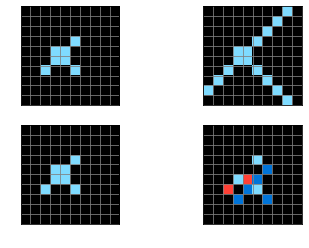

Average test loss: 171.97601318359375
Failed to solve task 7ddcd7ec.json.
Attempted 127 out of 262 tasks.

Solved 5 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 7df24a62.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


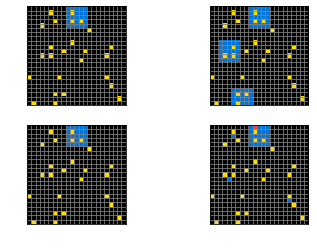

Average test loss: 79.81095886230469
Failed to solve task 7df24a62.json.
Attempted 128 out of 262 tasks.

Solved 5 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 7e0986d6.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


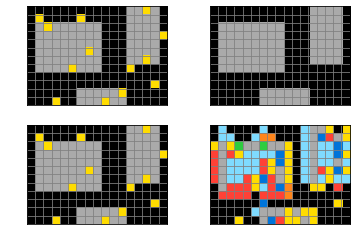

Average test loss: 1458.656982421875
Failed to solve task 7e0986d6.json.
Attempted 129 out of 262 tasks.

Solved 5 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 7f4411dc.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


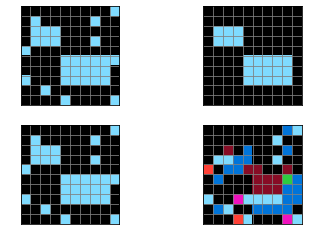

Average test loss: 451.823486328125
Failed to solve task 7f4411dc.json.
Attempted 130 out of 262 tasks.

Solved 5 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 810b9b61.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


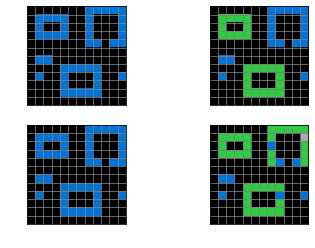

Average test loss: 49.31551742553711
Failed to solve task 810b9b61.json.
Attempted 131 out of 262 tasks.

Solved 5 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 82819916.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


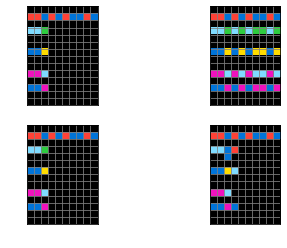

Average test loss: 77.42057800292969
Failed to solve task 82819916.json.
Attempted 132 out of 262 tasks.

Solved 5 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 83302e8f.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


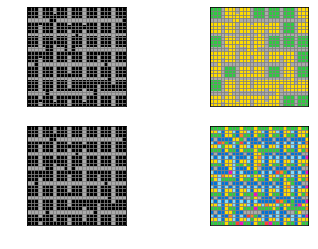

Average test loss: 4346.12939453125
Failed to solve task 83302e8f.json.
Attempted 133 out of 262 tasks.

Solved 5 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 834ec97d.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


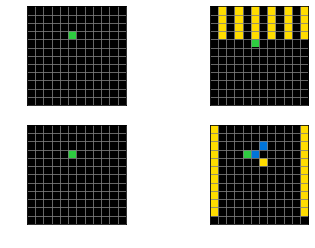

Average test loss: 71.55352020263672
Failed to solve task 834ec97d.json.
Attempted 134 out of 262 tasks.

Solved 5 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 8403a5d5.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


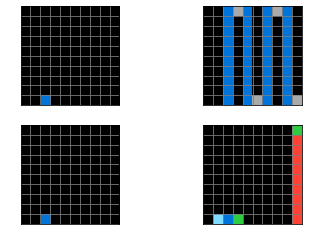

Average test loss: 89.42707824707031
Failed to solve task 8403a5d5.json.
Attempted 135 out of 262 tasks.

Solved 5 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 855e0971.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


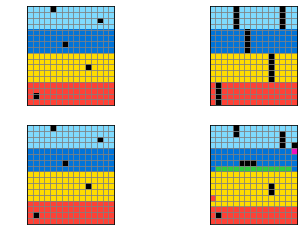

Average test loss: 243.0090789794922
Failed to solve task 855e0971.json.
Attempted 136 out of 262 tasks.

Solved 5 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 85c4e7cd.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


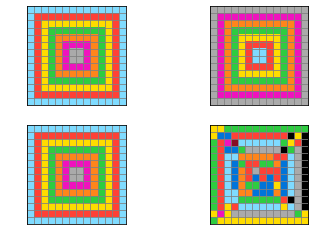

Average test loss: 979.21044921875
Failed to solve task 85c4e7cd.json.
Attempted 137 out of 262 tasks.

Solved 5 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 868de0fa.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


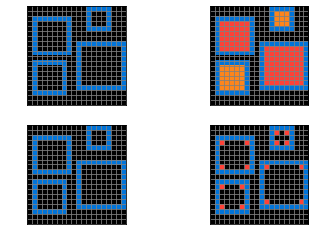

Average test loss: 170.84971618652344
Failed to solve task 868de0fa.json.
Attempted 138 out of 262 tasks.

Solved 5 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 88a10436.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


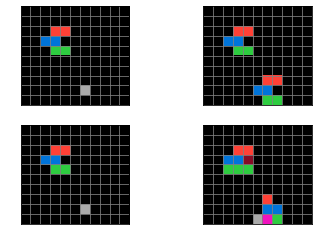

Average test loss: 43.45915985107422
Failed to solve task 88a10436.json.
Attempted 139 out of 262 tasks.

Solved 5 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 890034e9.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


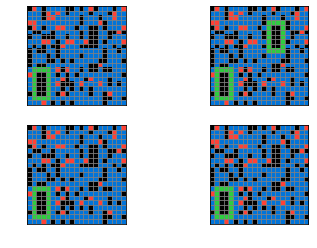

Average test loss: 80.73566436767578
Failed to solve task 890034e9.json.
Attempted 140 out of 262 tasks.

Solved 5 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 8d510a79.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


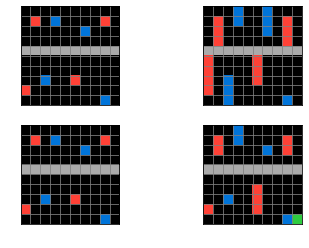

Average test loss: 31.964860916137695
Failed to solve task 8d510a79.json.
Attempted 141 out of 262 tasks.

Solved 5 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 8e5a5113.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


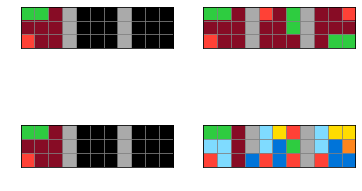

Average test loss: 173.2816925048828
Failed to solve task 8e5a5113.json.
Attempted 142 out of 262 tasks.

Solved 5 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 8eb1be9a.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


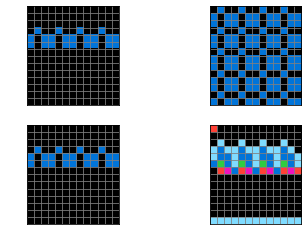

Average test loss: 578.9771728515625
Failed to solve task 8eb1be9a.json.
Attempted 143 out of 262 tasks.

Solved 5 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 8f2ea7aa.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


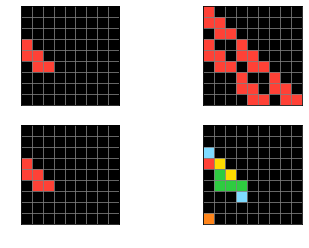

Average test loss: 161.4526824951172
Failed to solve task 8f2ea7aa.json.
Attempted 144 out of 262 tasks.

Solved 5 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 90f3ed37.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


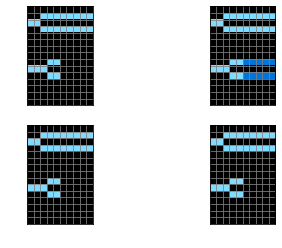

Average test loss: 28.56501007080078
Failed to solve task 90f3ed37.json.
Attempted 145 out of 262 tasks.

Solved 5 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json']
Training model 913fb3ed.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


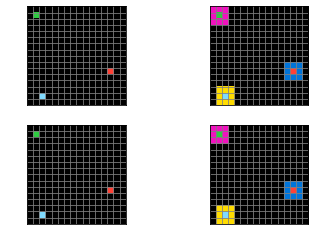

Average test loss: 68.015625
Solved task 913fb3ed.json successfully!
Attempted 146 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json']
Training model 91714a58.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


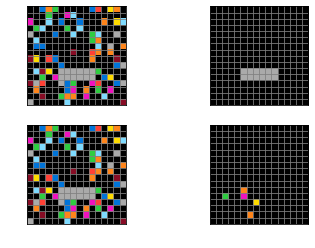

Average test loss: 138.73646545410156
Failed to solve task 91714a58.json.
Attempted 147 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json']
Training model 928ad970.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


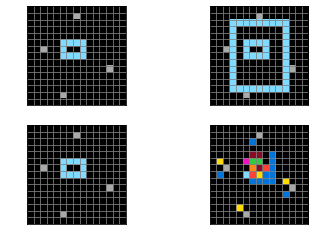

Average test loss: 291.6558532714844
Failed to solve task 928ad970.json.
Attempted 148 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json']
Training model 93b581b8.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


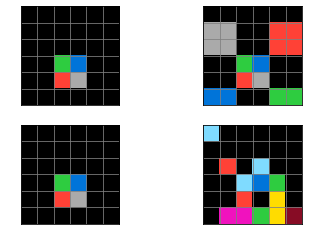

Average test loss: 65.09848022460938
Failed to solve task 93b581b8.json.
Attempted 149 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json']
Training model 941d9a10.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


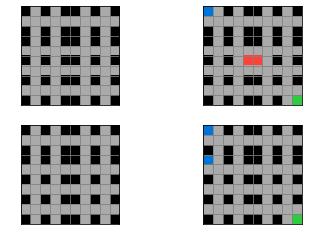

Average test loss: 9.826801300048828
Failed to solve task 941d9a10.json.
Attempted 150 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json']
Training model 952a094c.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


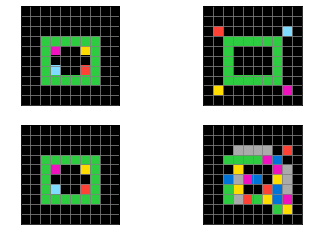

Average test loss: 204.2662353515625
Failed to solve task 952a094c.json.
Attempted 151 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json']
Training model 9565186b.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


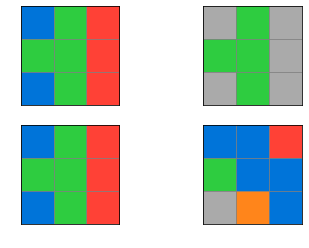

Average test loss: 36.20862579345703
Failed to solve task 9565186b.json.
Attempted 152 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json']
Training model 95990924.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


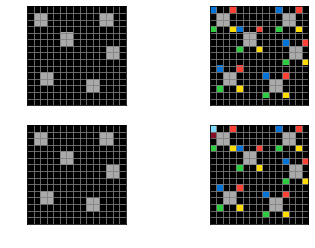

Average test loss: 18.056835174560547
Failed to solve task 95990924.json.
Attempted 153 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json']
Training model 97999447.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


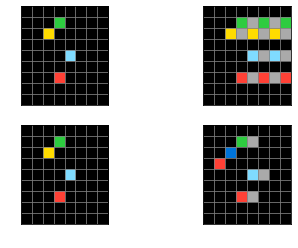

Average test loss: 43.585899353027344
Failed to solve task 97999447.json.
Attempted 154 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json']
Training model 98cf29f8.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


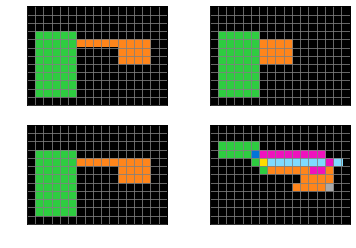

Average test loss: 469.8326416015625
Failed to solve task 98cf29f8.json.
Attempted 155 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json']
Training model 99fa7670.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


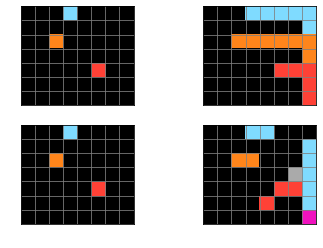

Average test loss: 25.918136596679688
Failed to solve task 99fa7670.json.
Attempted 156 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json']
Training model 9d9215db.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


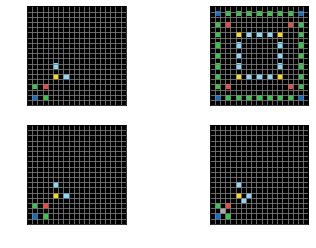

Average test loss: 107.07636260986328
Failed to solve task 9d9215db.json.
Attempted 157 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json']
Training model 9dfd6313.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


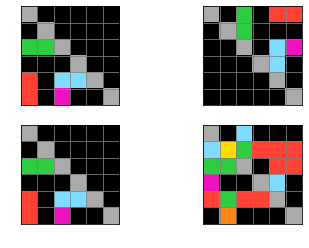

Average test loss: 73.675048828125
Failed to solve task 9dfd6313.json.
Attempted 158 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json']
Training model 9edfc990.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


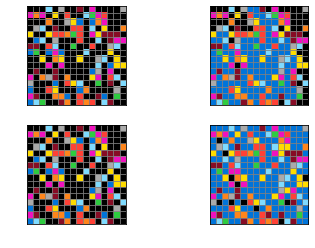

Average test loss: 184.21267700195312
Failed to solve task 9edfc990.json.
Attempted 159 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json']
Training model a1570a43.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


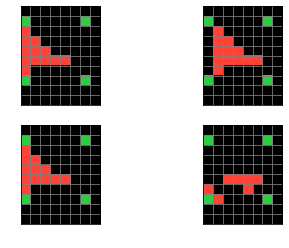

Average test loss: 27.59003448486328
Failed to solve task a1570a43.json.
Attempted 160 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json']
Training model a2fd1cf0.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


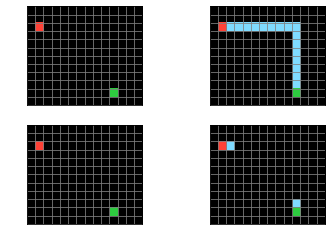

Average test loss: 24.717540740966797
Failed to solve task a2fd1cf0.json.
Attempted 161 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json']
Training model a3df8b1e.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


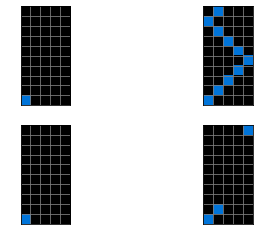

Average test loss: 15.299728393554688
Failed to solve task a3df8b1e.json.
Attempted 162 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json']
Training model a48eeaf7.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


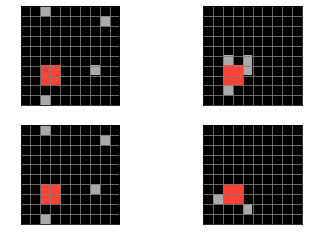

Average test loss: 13.31233024597168
Failed to solve task a48eeaf7.json.
Attempted 163 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json']
Training model a5313dff.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


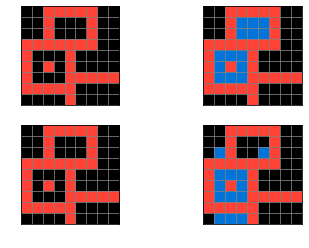

Average test loss: 24.671276092529297
Failed to solve task a5313dff.json.
Attempted 164 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json']
Training model a5f85a15.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


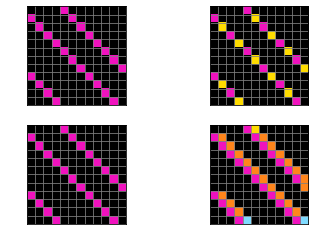

Average test loss: 305.7083740234375
Failed to solve task a5f85a15.json.
Attempted 165 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json']
Training model a61f2674.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


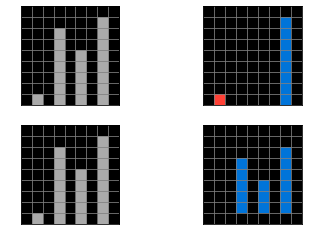

Average test loss: 17.33405113220215
Failed to solve task a61f2674.json.
Attempted 166 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json']
Training model a64e4611.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


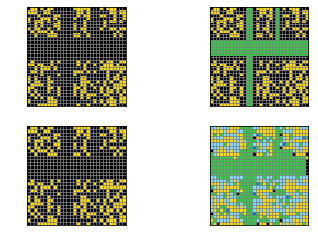

Average test loss: 6093.81494140625
Failed to solve task a64e4611.json.
Attempted 167 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json']
Training model a65b410d.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


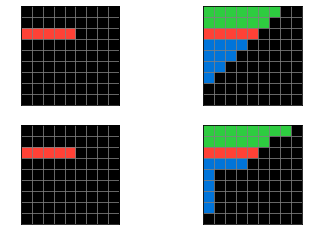

Average test loss: 10.13148021697998
Failed to solve task a65b410d.json.
Attempted 168 out of 262 tasks.

Solved 6 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json']
Training model a699fb00.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


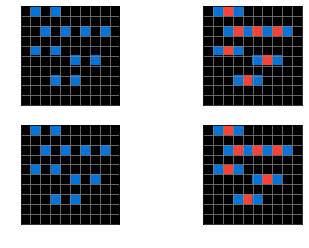

Average test loss: 11.097116470336914
Solved task a699fb00.json successfully!
Attempted 169 out of 262 tasks.

Solved 7 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json']
Training model a78176bb.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


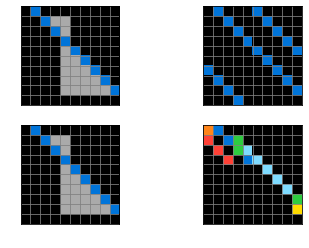

Average test loss: 133.3525390625
Failed to solve task a78176bb.json.
Attempted 170 out of 262 tasks.

Solved 7 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json']
Training model a79310a0.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


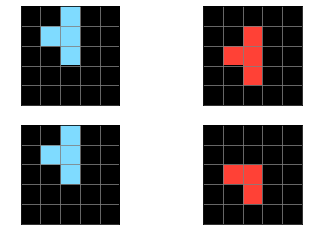

Average test loss: 9.02133560180664
Failed to solve task a79310a0.json.
Attempted 171 out of 262 tasks.

Solved 7 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json']
Training model a85d4709.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


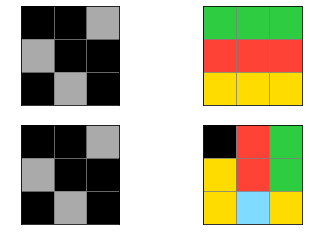

Average test loss: 13.829350471496582
Failed to solve task a85d4709.json.
Attempted 172 out of 262 tasks.

Solved 7 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json']
Training model a8d7556c.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


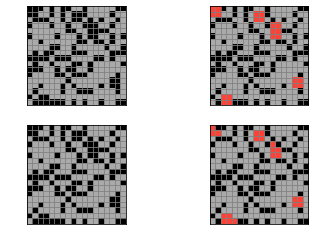

Average test loss: 18.41553497314453
Failed to solve task a8d7556c.json.
Attempted 173 out of 262 tasks.

Solved 7 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json']
Training model a9f96cdd.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


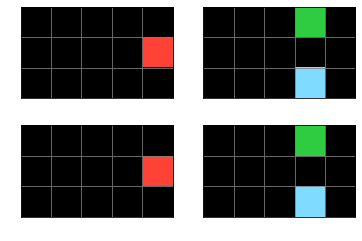

Average test loss: 14.218440055847168
Solved task a9f96cdd.json successfully!
Attempted 174 out of 262 tasks.

Solved 8 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json']
Training model aabf363d.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


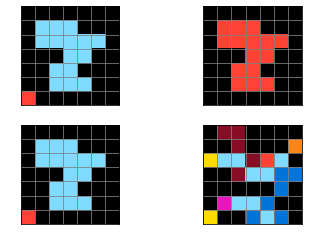

Average test loss: 273.0884704589844
Failed to solve task aabf363d.json.
Attempted 175 out of 262 tasks.

Solved 8 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json']
Training model aba27056.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


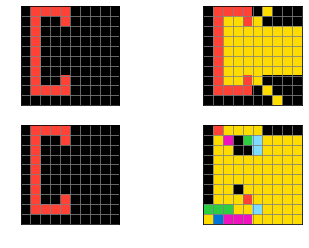

Average test loss: 410.7346496582031
Failed to solve task aba27056.json.
Attempted 176 out of 262 tasks.

Solved 8 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json']
Training model ae3edfdc.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


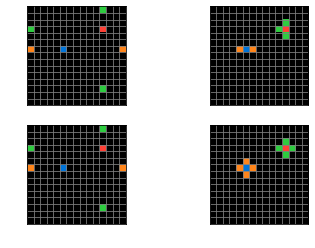

Average test loss: 4.259517669677734
Failed to solve task ae3edfdc.json.
Attempted 177 out of 262 tasks.

Solved 8 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json']
Training model aedd82e4.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


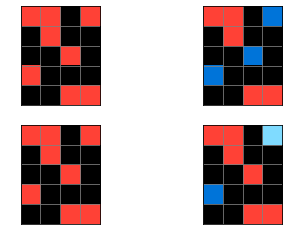

Average test loss: 13.63687515258789
Failed to solve task aedd82e4.json.
Attempted 178 out of 262 tasks.

Solved 8 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json']
Training model af902bf9.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


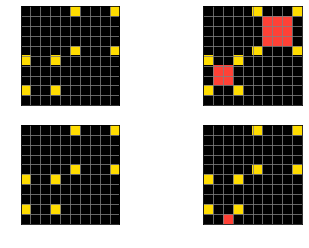

Average test loss: 31.867246627807617
Failed to solve task af902bf9.json.
Attempted 179 out of 262 tasks.

Solved 8 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json']
Training model b1948b0a.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


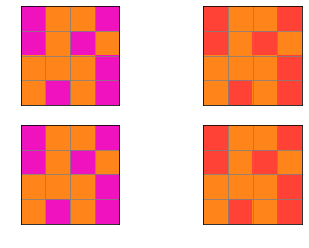

Average test loss: 15.312260627746582
Solved task b1948b0a.json successfully!
Attempted 180 out of 262 tasks.

Solved 9 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json']
Training model b230c067.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


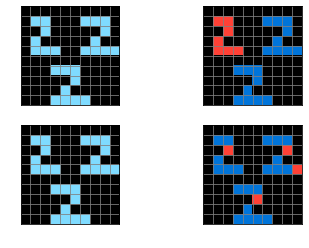

Average test loss: 27.885936737060547
Failed to solve task b230c067.json.
Attempted 181 out of 262 tasks.

Solved 9 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json']
Training model b27ca6d3.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


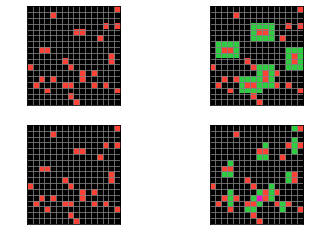

Average test loss: 90.72438049316406
Failed to solve task b27ca6d3.json.
Attempted 182 out of 262 tasks.

Solved 9 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json']
Training model b2862040.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


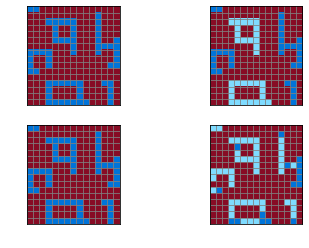

Average test loss: 49.20185852050781
Failed to solve task b2862040.json.
Attempted 183 out of 262 tasks.

Solved 9 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json']
Training model b527c5c6.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


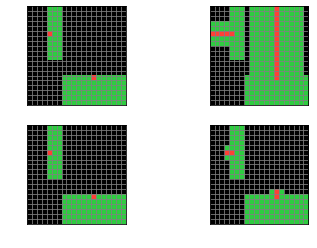

Average test loss: 186.6484375
Failed to solve task b527c5c6.json.
Attempted 184 out of 262 tasks.

Solved 9 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json']
Training model b548a754.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


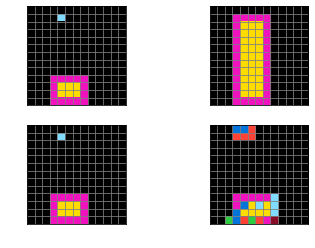

Average test loss: 323.9463806152344
Failed to solve task b548a754.json.
Attempted 185 out of 262 tasks.

Solved 9 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json']
Training model b60334d2.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


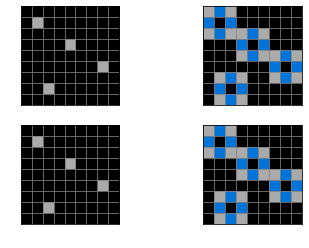

Average test loss: 32.23949432373047
Solved task b60334d2.json successfully!
Attempted 186 out of 262 tasks.

Solved 10 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json']
Training model b6afb2da.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


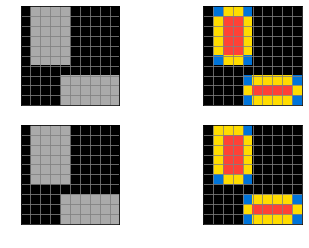

Average test loss: 2.3433737754821777
Failed to solve task b6afb2da.json.
Attempted 187 out of 262 tasks.

Solved 10 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json']
Training model b7249182.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


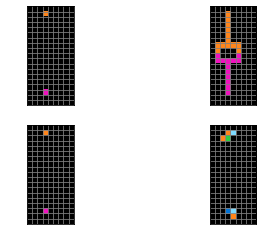

Average test loss: 90.09073638916016
Failed to solve task b7249182.json.
Attempted 188 out of 262 tasks.

Solved 10 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json']
Training model b775ac94.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


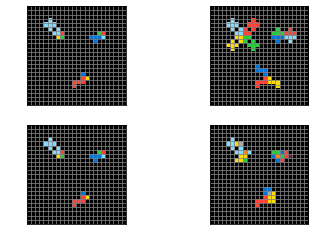

Average test loss: 162.14645385742188
Failed to solve task b775ac94.json.
Attempted 189 out of 262 tasks.

Solved 10 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json']
Training model b782dc8a.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


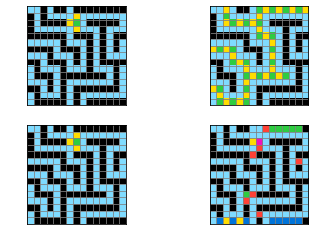

Average test loss: 137.90762329101562
Failed to solve task b782dc8a.json.
Attempted 190 out of 262 tasks.

Solved 10 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json']
Training model b8825c91.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


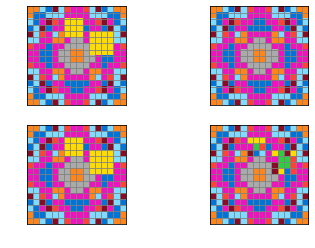

Average test loss: 82.97007751464844
Failed to solve task b8825c91.json.
Attempted 191 out of 262 tasks.

Solved 10 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json']
Training model b8cdaf2b.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


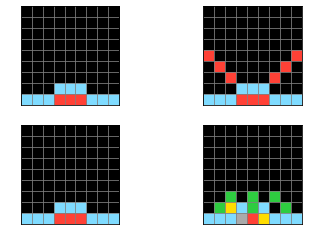

Average test loss: 44.63175964355469
Failed to solve task b8cdaf2b.json.
Attempted 192 out of 262 tasks.

Solved 10 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json']
Training model ba26e723.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


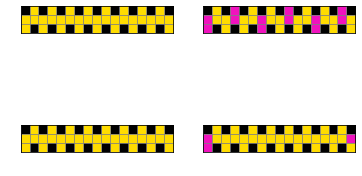

Average test loss: 14.468409538269043
Failed to solve task ba26e723.json.
Attempted 193 out of 262 tasks.

Solved 10 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json']
Training model ba97ae07.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


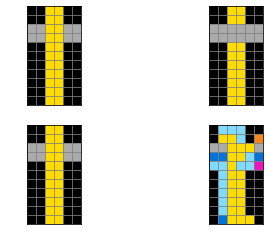

Average test loss: 863.3053588867188
Failed to solve task ba97ae07.json.
Attempted 194 out of 262 tasks.

Solved 10 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json']
Training model bb43febb.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


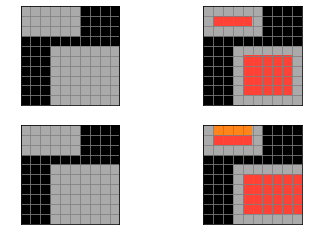

Average test loss: 20.56810188293457
Failed to solve task bb43febb.json.
Attempted 195 out of 262 tasks.

Solved 10 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json']
Training model bd4472b8.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


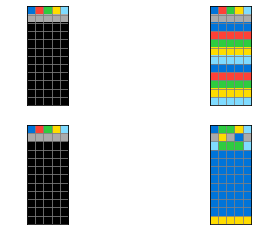

Average test loss: 81.74040985107422
Failed to solve task bd4472b8.json.
Attempted 196 out of 262 tasks.

Solved 10 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json']
Training model bda2d7a6.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


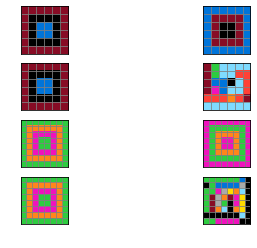

Average test loss: 401.5988464355469
Failed to solve task bda2d7a6.json.
Attempted 197 out of 262 tasks.

Solved 10 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json']
Training model bdad9b1f.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


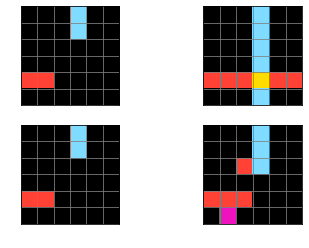

Average test loss: 13.437874794006348
Failed to solve task bdad9b1f.json.
Attempted 198 out of 262 tasks.

Solved 10 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json']
Training model beb8660c.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


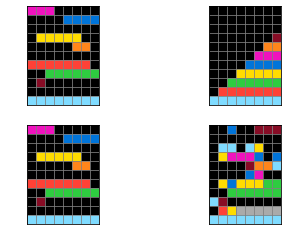

Average test loss: 229.54359436035156
Failed to solve task beb8660c.json.
Attempted 199 out of 262 tasks.

Solved 10 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json']
Training model c0f76784.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


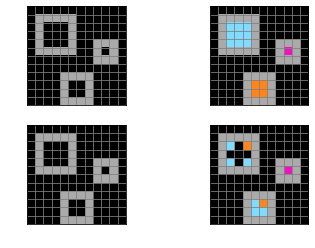

Average test loss: 20.965518951416016
Failed to solve task c0f76784.json.
Attempted 200 out of 262 tasks.

Solved 10 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json']
Training model c1d99e64.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


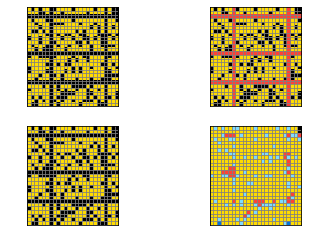

Average test loss: 11410.0234375
Failed to solve task c1d99e64.json.
Attempted 201 out of 262 tasks.

Solved 10 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json']
Training model c3f564a4.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


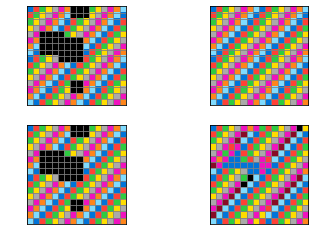

Average test loss: 398.0162048339844
Failed to solve task c3f564a4.json.
Attempted 202 out of 262 tasks.

Solved 10 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json']
Training model c444b776.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


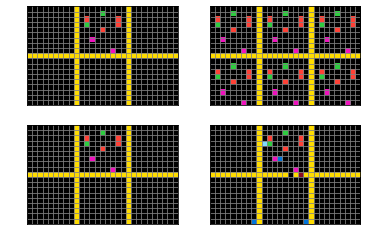

Average test loss: 137.29481506347656
Failed to solve task c444b776.json.
Attempted 203 out of 262 tasks.

Solved 10 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json']
Training model c8f0f002.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


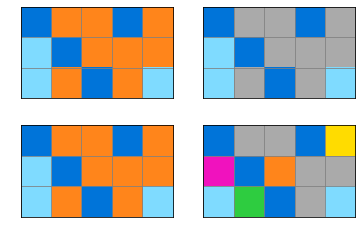

Average test loss: 22.16549301147461
Failed to solve task c8f0f002.json.
Attempted 204 out of 262 tasks.

Solved 10 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json']
Training model c9f8e694.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


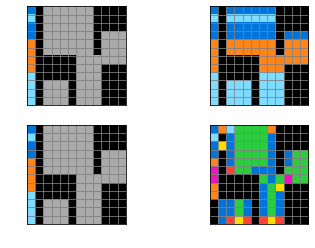

Average test loss: 225.02975463867188
Failed to solve task c9f8e694.json.
Attempted 205 out of 262 tasks.

Solved 10 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json']
Training model caa06a1f.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


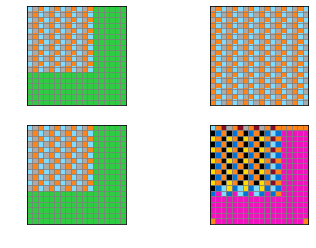

Average test loss: 2024.17919921875
Failed to solve task caa06a1f.json.
Attempted 206 out of 262 tasks.

Solved 10 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json']
Training model cbded52d.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


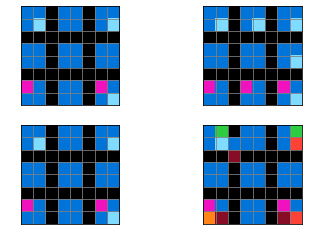

Average test loss: 102.8752212524414
Failed to solve task cbded52d.json.
Attempted 207 out of 262 tasks.

Solved 10 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json']
Training model ce22a75a.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


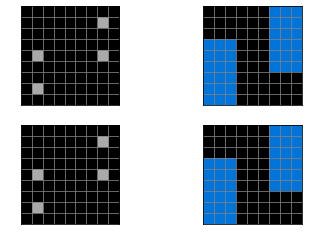

Average test loss: 32.43467712402344
Solved task ce22a75a.json successfully!
Attempted 208 out of 262 tasks.

Solved 11 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json']
Training model ce9e57f2.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


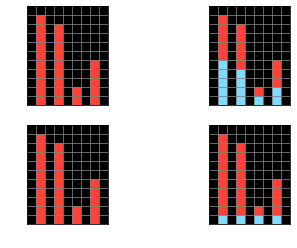

Average test loss: 9.065393447875977
Failed to solve task ce9e57f2.json.
Attempted 209 out of 262 tasks.

Solved 11 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json']
Training model d037b0a7.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


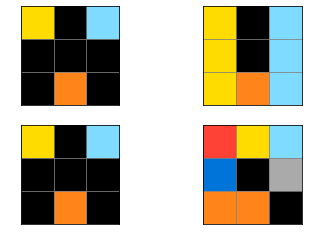

Average test loss: 22.325496673583984
Failed to solve task d037b0a7.json.
Attempted 210 out of 262 tasks.

Solved 11 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json']
Training model d06dbe63.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


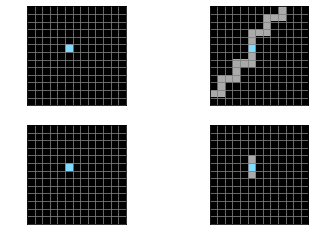

Average test loss: 31.807262420654297
Failed to solve task d06dbe63.json.
Attempted 211 out of 262 tasks.

Solved 11 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json']
Training model d07ae81c.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


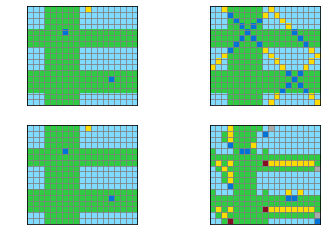

Average test loss: 423.5770568847656
Failed to solve task d07ae81c.json.
Attempted 212 out of 262 tasks.

Solved 11 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json']
Training model d22278a0.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


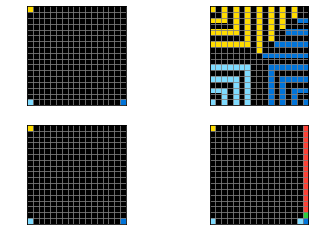

Average test loss: 205.3353729248047
Failed to solve task d22278a0.json.
Attempted 213 out of 262 tasks.

Solved 11 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json']
Training model d23f8c26.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


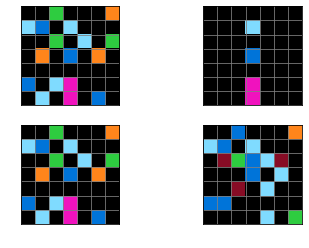

Average test loss: 160.06671142578125
Failed to solve task d23f8c26.json.
Attempted 214 out of 262 tasks.

Solved 11 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json']
Training model d2abd087.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


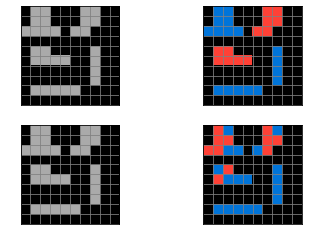

Average test loss: 22.51156234741211
Failed to solve task d2abd087.json.
Attempted 215 out of 262 tasks.

Solved 11 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json']
Training model d364b489.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


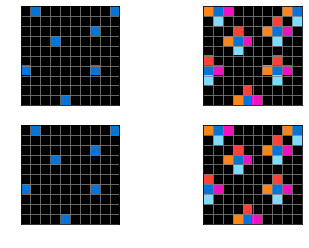

Average test loss: 17.6846923828125
Solved task d364b489.json successfully!
Attempted 216 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']
Training model d406998b.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


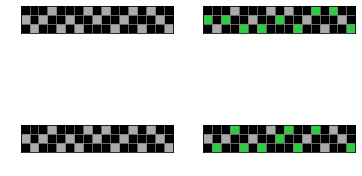

Average test loss: 7.657714366912842
Failed to solve task d406998b.json.
Attempted 217 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']
Training model d43fd935.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


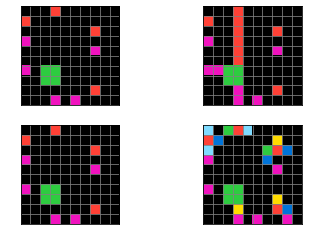

Average test loss: 79.85057067871094
Failed to solve task d43fd935.json.
Attempted 218 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']
Training model d4a91cb9.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


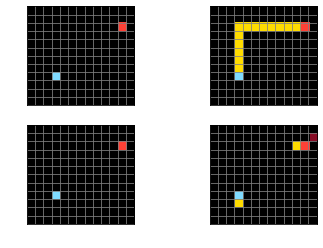

Average test loss: 27.412080764770508
Failed to solve task d4a91cb9.json.
Attempted 219 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']
Training model d4f3cd78.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


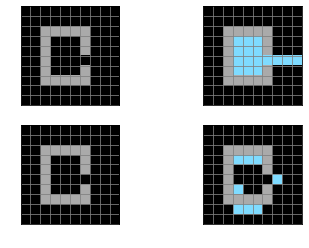

Average test loss: 21.551952362060547
Failed to solve task d4f3cd78.json.
Attempted 220 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']
Training model d511f180.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


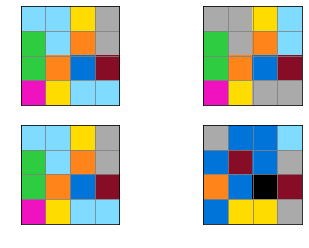

Average test loss: 89.1131591796875
Failed to solve task d511f180.json.
Attempted 221 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']
Training model d5d6de2d.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


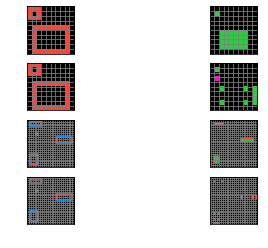

Average test loss: 53.2381591796875
Failed to solve task d5d6de2d.json.
Attempted 222 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']
Training model d687bc17.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


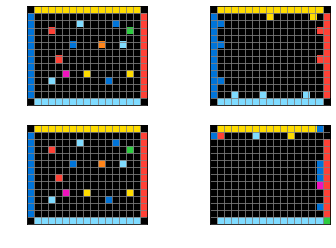

Average test loss: 170.37326049804688
Failed to solve task d687bc17.json.
Attempted 223 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']
Training model d6ad076f.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


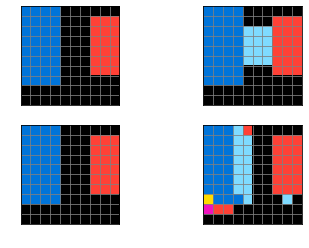

Average test loss: 503.66680908203125
Failed to solve task d6ad076f.json.
Attempted 224 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']
Training model d89b689b.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


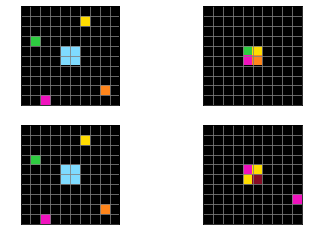

Average test loss: 25.082386016845703
Failed to solve task d89b689b.json.
Attempted 225 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']
Training model d8c310e9.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


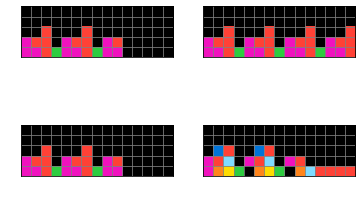

Average test loss: 152.01361083984375
Failed to solve task d8c310e9.json.
Attempted 226 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']
Training model d90796e8.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


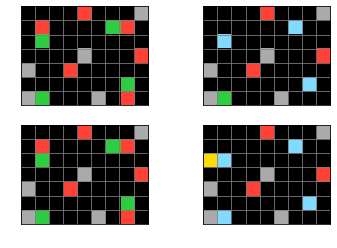

Average test loss: 39.7961540222168
Failed to solve task d90796e8.json.
Attempted 227 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']
Training model d9f24cd1.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


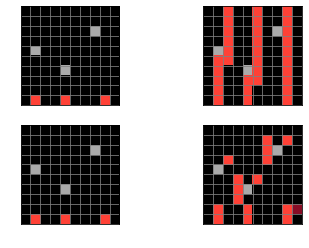

Average test loss: 34.74494934082031
Failed to solve task d9f24cd1.json.
Attempted 228 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']
Training model db3e9e38.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


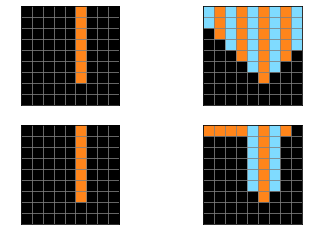

Average test loss: 29.352872848510742
Failed to solve task db3e9e38.json.
Attempted 229 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']
Training model db93a21d.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


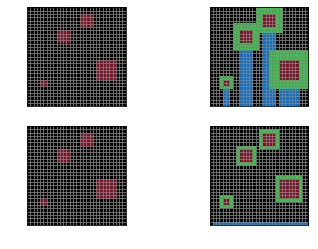

Average test loss: 431.164306640625
Failed to solve task db93a21d.json.
Attempted 230 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']
Training model dbc1a6ce.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


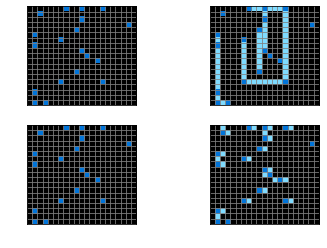

Average test loss: 94.77540588378906
Failed to solve task dbc1a6ce.json.
Attempted 231 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']
Training model dc1df850.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


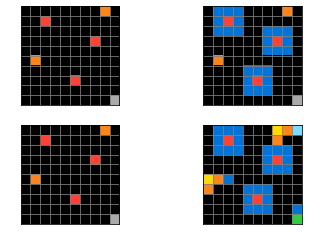

Average test loss: 50.20654296875
Failed to solve task dc1df850.json.
Attempted 232 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']
Training model dc433765.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


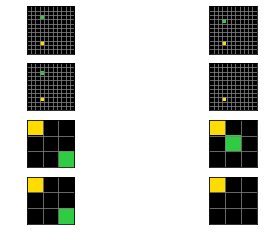

Average test loss: 5.577763557434082
Failed to solve task dc433765.json.
Attempted 233 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']
Training model ddf7fa4f.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


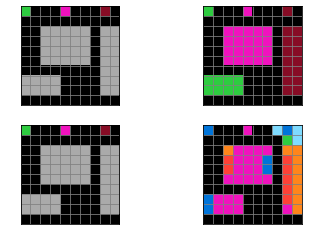

Average test loss: 77.2916030883789
Failed to solve task ddf7fa4f.json.
Attempted 234 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']
Training model ded97339.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


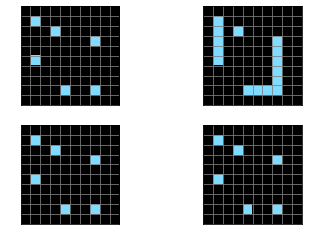

Average test loss: 14.692943572998047
Failed to solve task ded97339.json.
Attempted 235 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']
Training model e179c5f4.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


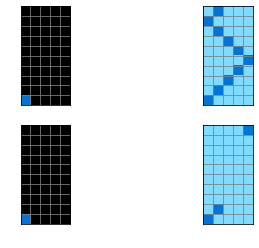

Average test loss: 15.300515174865723
Failed to solve task e179c5f4.json.
Attempted 236 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']
Training model e21d9049.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


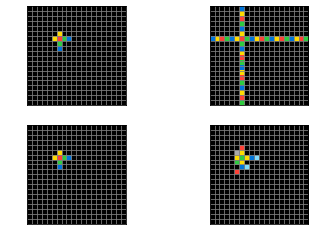

Average test loss: 149.95936584472656
Failed to solve task e21d9049.json.
Attempted 237 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']
Training model e26a3af2.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


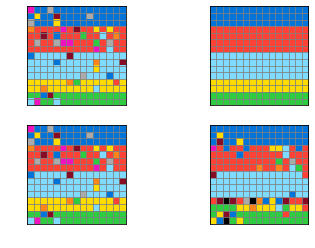

Average test loss: 197.25723266601562
Failed to solve task e26a3af2.json.
Attempted 238 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']
Training model e40b9e2f.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


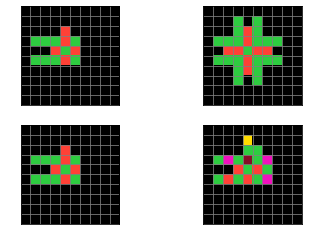

Average test loss: 226.60836791992188
Failed to solve task e40b9e2f.json.
Attempted 239 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']
Training model e48d4e1a.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


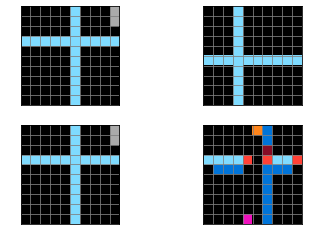

Average test loss: 309.2564697265625
Failed to solve task e48d4e1a.json.
Attempted 240 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']
Training model e5062a87.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


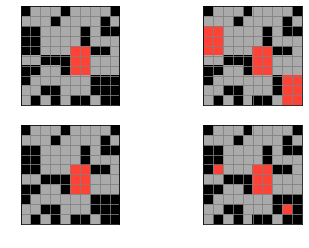

Average test loss: 36.88677978515625
Failed to solve task e5062a87.json.
Attempted 241 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']
Training model e509e548.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


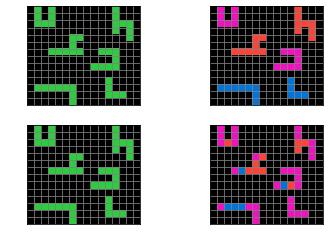

Average test loss: 41.51665496826172
Failed to solve task e509e548.json.
Attempted 242 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']
Training model e73095fd.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


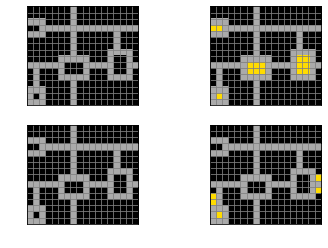

Average test loss: 32.95180892944336
Failed to solve task e73095fd.json.
Attempted 243 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']
Training model e76a88a6.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


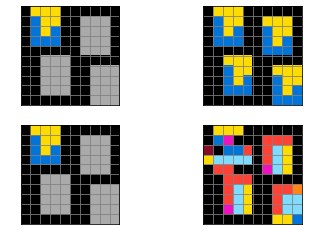

Average test loss: 184.37371826171875
Failed to solve task e76a88a6.json.
Attempted 244 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']
Training model e8593010.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


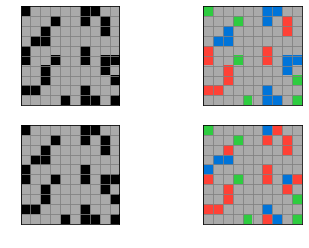

Average test loss: 18.295379638671875
Failed to solve task e8593010.json.
Attempted 245 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']
Training model e8dc4411.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


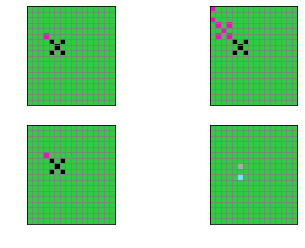

Average test loss: 6727.8896484375
Failed to solve task e8dc4411.json.
Attempted 246 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']
Training model e9614598.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


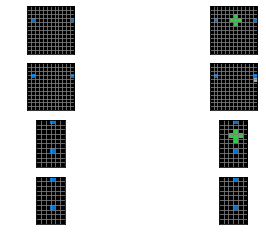

Average test loss: 10.319856643676758
Failed to solve task e9614598.json.
Attempted 247 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']
Training model e9afcf9a.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


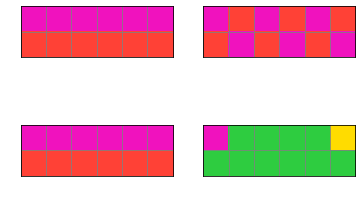

Average test loss: 193.1844482421875
Failed to solve task e9afcf9a.json.
Attempted 248 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']
Training model ea32f347.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


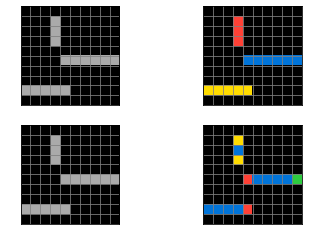

Average test loss: 23.353321075439453
Failed to solve task ea32f347.json.
Attempted 249 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']
Training model ea786f4a.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


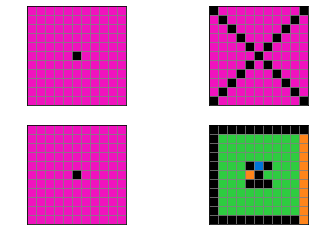

Average test loss: 1480.2735595703125
Failed to solve task ea786f4a.json.
Attempted 250 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']
Training model ec883f72.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


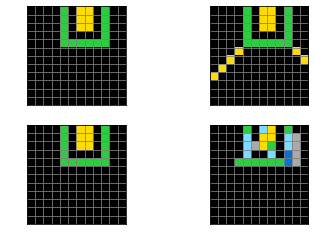

Average test loss: 143.24636840820312
Failed to solve task ec883f72.json.
Attempted 251 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']
Training model ecdecbb3.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


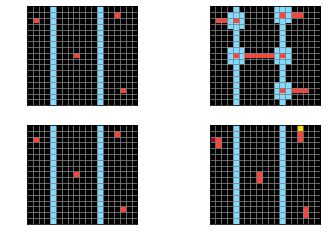

Average test loss: 68.96063232421875
Failed to solve task ecdecbb3.json.
Attempted 252 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']
Training model ed36ccf7.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


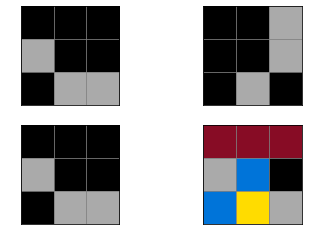

Average test loss: 35.64136505126953
Failed to solve task ed36ccf7.json.
Attempted 253 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']
Training model ef135b50.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


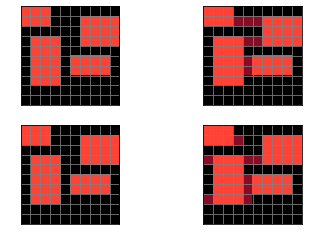

Average test loss: 12.091625213623047
Failed to solve task ef135b50.json.
Attempted 254 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']
Training model f15e1fac.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


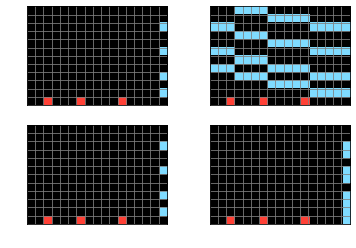

Average test loss: 127.61164093017578
Failed to solve task f15e1fac.json.
Attempted 255 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']
Training model f1cefba8.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


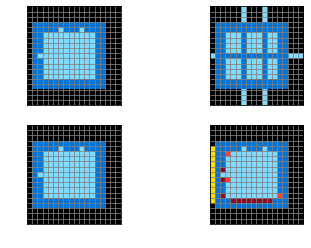

Average test loss: 263.779541015625
Failed to solve task f1cefba8.json.
Attempted 256 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']
Training model f25ffba3.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


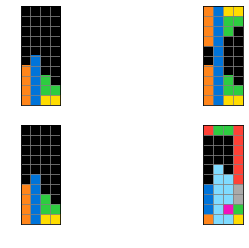

Average test loss: 257.94134521484375
Failed to solve task f25ffba3.json.
Attempted 257 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']
Training model f35d900a.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


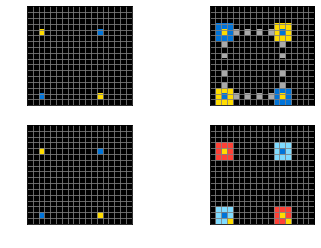

Average test loss: 99.86470794677734
Failed to solve task f35d900a.json.
Attempted 258 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']
Training model f76d97a5.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


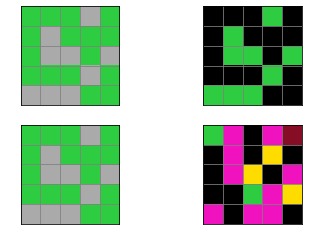

Average test loss: 215.7109832763672
Failed to solve task f76d97a5.json.
Attempted 259 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']
Training model f8a8fe49.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


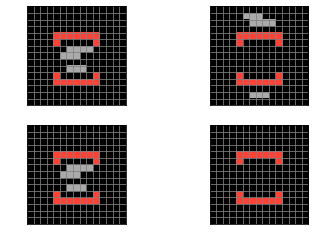

Average test loss: 31.84126853942871
Failed to solve task f8a8fe49.json.
Attempted 260 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']
Training model f8c80d96.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


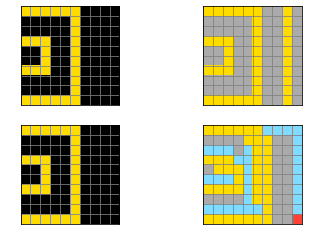

Average test loss: 604.7950439453125
Failed to solve task f8c80d96.json.
Attempted 261 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']
Training model fcc82909.json for a max of 1000 epochs, with 1 iterations per epoch...

Evaluation result:


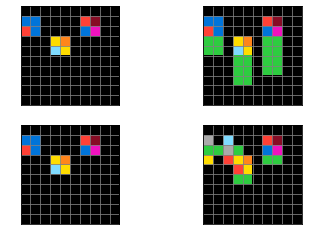

Average test loss: 84.0710678100586
Failed to solve task fcc82909.json.
Attempted 262 out of 262 tasks.

Solved 12 tasks so far:
['0ca9ddb6.json', '3618c87e.json', '4258a5f9.json', '67385a82.json', '6f8cd79b.json', '913fb3ed.json', 'a699fb00.json', 'a9f96cdd.json', 'b1948b0a.json', 'b60334d2.json', 'ce22a75a.json', 'd364b489.json']


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
# This block runs the baseline convolutional model on all training tasks

# Baseline model does not iterate over grid
num_iterations = 1

optimizer = keras.optimizers.Adam(learning_rate=3e-3)
initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.3, seed=1337)
max_epochs = 1000

solved_count = 0
solved_tasks = []

for i, task in enumerate(vectorized_tasks):
    task_name = task_names[i]
    model = createAutomataModel(initializer, name=task_name)
    success = train(model, task, num_iterations, optimizer, max_epochs)
    evaluate(model, task["test_x"], task["test_y"], num_iterations, display_result=True)
    if success:
        print(f"Solved task {task_name} successfully!")
        solved_count += 1
        solved_tasks.append(task_name)
    else:
        print(f"Failed to solve task {task_name}.")
    print(f"Attempted {i+1} out of {len(vectorized_tasks)} tasks.\n")
    print(f"Solved {solved_count} tasks so far:")
    print(solved_tasks)

print(f"Finished. Solved {solved_count} out of {vectorized_tasks} tasks.")

